
# **Workspace-1: Fall Detection** 🚨

### **Operationalized Machine Learning in Healthcare**  
**Final Project**  
**DGIN 5401**  

---

### **Project Overview**  
This project is dedicated to developing a robust **Fall Detection System** using machine learning models to detect falls from sensor data. The models aim to be integrated into healthcare systems to provide real-time alerts, ensuring quick responses and patient safety.

---

### **By:**  
1. **Saransh Kotha** — B00956434  
2. **Rutvik Vengurlekar** — B00948033  

---

### **Key Technologies**  
- **Machine Learning Algorithms:** XGBoost, ResNet, Decision Tree, Random Forest  
- **Data Preprocessing:** Scaling, Feature Selection, Sampling  
- **Evaluation Metrics:** Precision, Recall, F1-Score, Confusion Matrix

---

### **Introduction:**  
Falls in healthcare settings, particularly among the elderly, are one of the leading causes of injury. This project uses **accelerometer data** to detect falls in real-time and send alerts to caregivers. By combining advanced machine learning models and class imbalance handling techniques, the system ensures accurate fall detection even in challenging datasets.

---

### **Project Highlights:**  
- **XGBoost Classifier:** Achieved competitive accuracy and recall for detecting falls.
- **Custom ResNet Models:** Optimized with class weights and focal loss to reduce false negatives in fall detection.
- **Comprehensive Evaluation:** Utilized cross-validation, thresholding, and confusion matrix analysis for model performance evaluation.



## Loading all Libraries

In [34]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import resample, class_weight
from sklearn.metrics import (classification_report, confusion_matrix, 
                             recall_score, accuracy_score, roc_curve, 
                             auc, calibration_curve, make_scorer, 
                             ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform, stats


## Loading training dataset

In [3]:
# Path to the training data folder
train_folder = './train'

# List to hold data from each CSV file
train_data_list = []

# Loop through each file in the train folder and append it to the list
for filename in os.listdir(train_folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(train_folder, filename)
        df = pd.read_csv(file_path)
        train_data_list.append(df)

# Concatenate all dataframes into one
train_data = pd.concat(train_data_list, ignore_index=True)

# Display basic info about the merged data
print("Training data loaded and merged:")
print(train_data.info())
print(train_data.head())


Training data loaded and merged:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134229 entries, 0 to 134228
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   x                134229 non-null  float64
 1   y                134229 non-null  float64
 2   z                134229 non-null  float64
 3   010-000-024-033  134229 non-null  float64
 4   010-000-030-096  134229 non-null  float64
 5   020-000-032-221  134229 non-null  float64
 6   020-000-033-111  134229 non-null  float64
 7   anomaly          134229 non-null  float64
dtypes: float64(8)
memory usage: 8.2 MB
None
           x          y          z  010-000-024-033  010-000-030-096  \
0  24.360715  14.661491  15.061292              0.0              0.0   
1  24.345720  14.677384  15.080112              0.0              0.0   
2  24.315322  14.641433  15.020421              1.0              0.0   
3  24.305469  14.663497  15.005379              0.0   

## Checking for missing values, class distribution and basic statistics

Missing values per column:
x                  0
y                  0
z                  0
010-000-024-033    0
010-000-030-096    0
020-000-032-221    0
020-000-033-111    0
anomaly            0
dtype: int64

Basic statistics:
                   x              y              z  010-000-024-033  \
count  134229.000000  134229.000000  134229.000000    134229.000000   
mean       13.189512      12.184366      11.383458         0.258551   
std         3.868037       2.705422       2.018636         0.437840   
min         4.077736       6.042775       4.600291         0.000000   
25%         9.676778      10.162940       9.975850         0.000000   
50%        13.701333      11.625925      11.344621         0.000000   
75%        16.345594      14.277065      12.933669         1.000000   
max        24.360715      19.633268      16.296521         1.000000   

       010-000-030-096  020-000-032-221  020-000-033-111        anomaly  
count    134229.000000    134229.000000    134229.000000  1

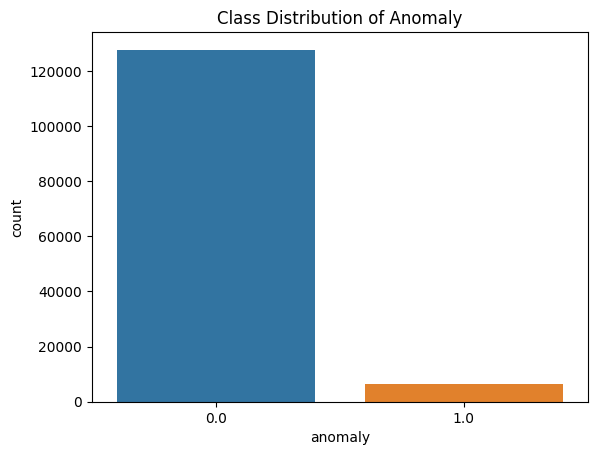


Class distribution:
0.0    127656
1.0      6573
Name: anomaly, dtype: int64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Show basic statistics
print("\nBasic statistics:")
print(train_data.describe())

# Visualize the class distribution of the target variable (anomaly)
sns.countplot(x='anomaly', data=train_data)
plt.title('Class Distribution of Anomaly')
plt.show()

# Display the value counts for 'anomaly'
print("\nClass distribution:")
print(train_data['anomaly'].value_counts())


## Data Overview and Preprocessing

### Missing Values:
- There are no missing values in the dataset, ensuring data integrity and no need for imputation.

### Basic Statistics:
- **Coordinate Features (x, y, z):**
  - Mean values are approximately 13.19, 12.18, and 11.38, respectively.
  - Standard deviations suggest moderate variability in the data:
    - x: 3.87
    - y: 2.71
    - z: 2.02
- **Tag Features (e.g., 010-000-024-033, 010-000-030-096):**
  - These columns are binary (0 or 1), with the majority of values being zeros, indicating sparse activations.
- **Target Variable (`anomaly`):**
  - Mean: 0.048 (indicating significant class imbalance).
  - Majority of samples (95%) are labeled as `0` (normal), with only 5% labeled as `1` (fall).

### Class Distribution:
- **Normal (0):** 127,656 instances (~95%).
- **Anomalies (1):** 6,573 instances (~5%).
- The dataset exhibits a **strong class imbalance** that must be addressed carefully.

---

## Visualization

### Class Distribution of the Target Variable:
- A bar plot of the `anomaly` column shows a heavily skewed distribution towards the normal class.
- Visualizing the imbalance reinforces the challenge of training a model to detect falls (anomalies).

---

## Key Observations

### 1. Missing Values:
- The dataset has no missing values, ensuring clean and complete input data for modeling.

### 2. Feature Distribution:
- The numerical columns (x, y, z) have moderate variability.
- Binary tag columns have sparse activations, mostly zeros.

### 3. Class Imbalance:
- The dataset is heavily imbalanced, with anomalies constituting only 5% of the data.
- This reflects a **real-world scenario** where falls are rare but critical to predict.

---

## Handling Imbalance

### Realistic Representation:
- The imbalance mirrors the actual frequency of falls in real-world situations. Artificial balancing (e.g., oversampling or undersampling) could distort this natural pattern.

### Baseline Model:
- Training on the imbalanced dataset provides a **realistic baseline**. 
- This helps evaluate the model’s ability to:
  1. Detect anomalies effectively.
  2. Minimize false negatives while keeping false positives manageable.



## Detecting outliers in training dataset

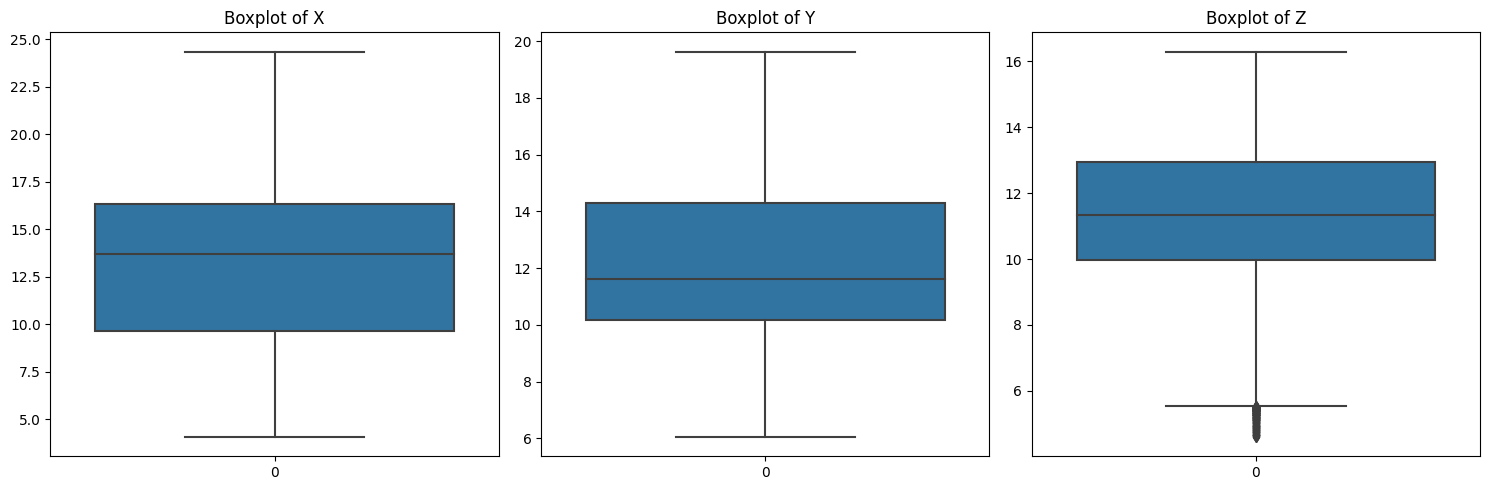

In [6]:
# Set up the figure
plt.figure(figsize=(15, 5))

# Boxplot for x
plt.subplot(1, 3, 1)
sns.boxplot(data=train_data['x'])
plt.title('Boxplot of X')

# Boxplot for y
plt.subplot(1, 3, 2)
sns.boxplot(data=train_data['y'])
plt.title('Boxplot of Y')

# Boxplot for z
plt.subplot(1, 3, 3)
sns.boxplot(data=train_data['z'])
plt.title('Boxplot of Z')

plt.tight_layout()
plt.show()


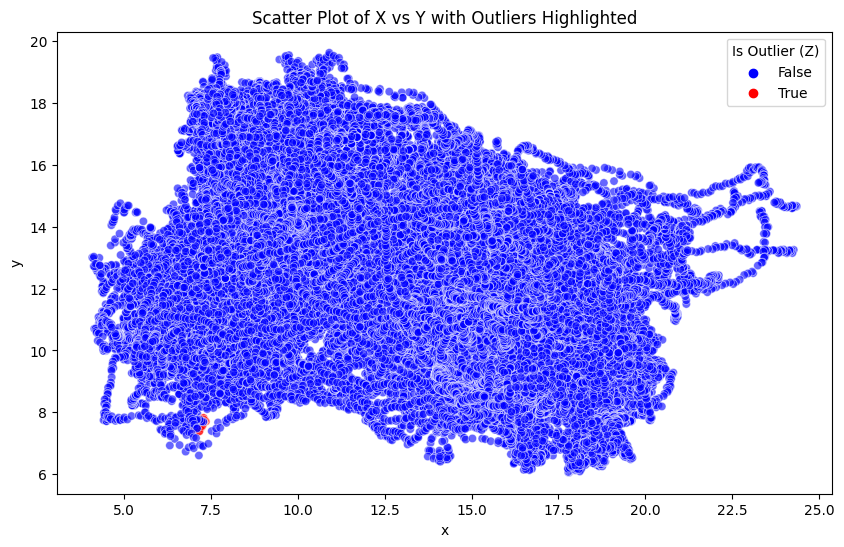

In [7]:
# Create a new column to identify outliers in z
train_data['is_outlier_z'] = (train_data['z'] > train_data['z'].quantile(0.75) + 1.5 * (train_data['z'].quantile(0.75) - train_data['z'].quantile(0.25))) | \
                             (train_data['z'] < train_data['z'].quantile(0.25) - 1.5 * (train_data['z'].quantile(0.75) - train_data['z'].quantile(0.25)))

# Visualize with scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='is_outlier_z', data=train_data, palette={False: 'blue', True: 'red'}, alpha=0.6)
plt.title('Scatter Plot of X vs Y with Outliers Highlighted')
plt.legend(title='Is Outlier (Z)', loc='upper right')
plt.show()


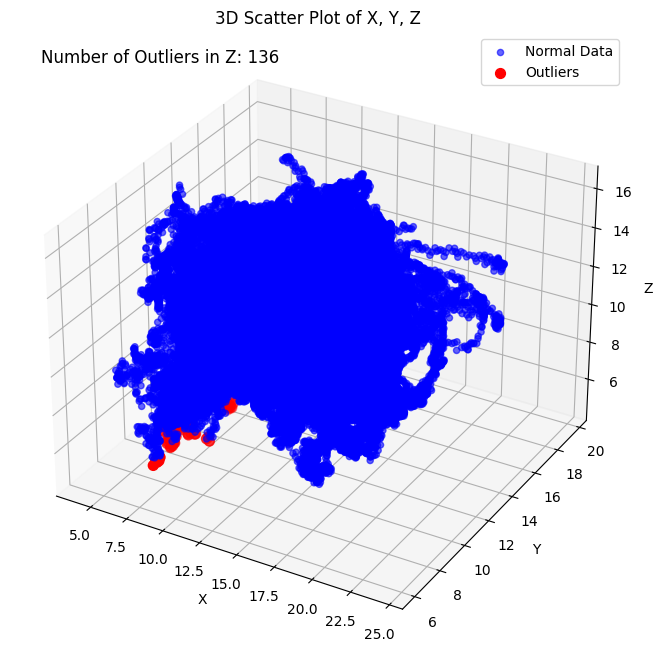

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define a function to identify outliers based on Z-scores
def identify_outliers(df, column):
    threshold = 3  # Z-score threshold
    mean = np.mean(df[column])
    std_dev = np.std(df[column])
    z_scores = (df[column] - mean) / std_dev
    return np.abs(z_scores) > threshold

# Create outlier columns for z
train_data['is_outlier_z'] = identify_outliers(train_data, 'z')

# Create a new figure for the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Separate normal points and outliers
normal_data = train_data[~train_data['is_outlier_z']]
outlier_data = train_data[train_data['is_outlier_z']]

# Scatter plot for normal data
ax.scatter(normal_data['x'], normal_data['y'], normal_data['z'], 
           c='blue', label='Normal Data', alpha=0.6)

# Scatter plot for outliers
ax.scatter(outlier_data['x'], outlier_data['y'], outlier_data['z'], 
           c='red', label='Outliers', s=50)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of X, Y, Z')
ax.legend()

# Number of outliers
num_outliers_z = outlier_data.shape[0]
ax.text2D(0.05, 0.95, f'Number of Outliers in Z: {num_outliers_z}', 
          transform=ax.transAxes, fontsize=12, color='black')

# Show the plot
plt.show()



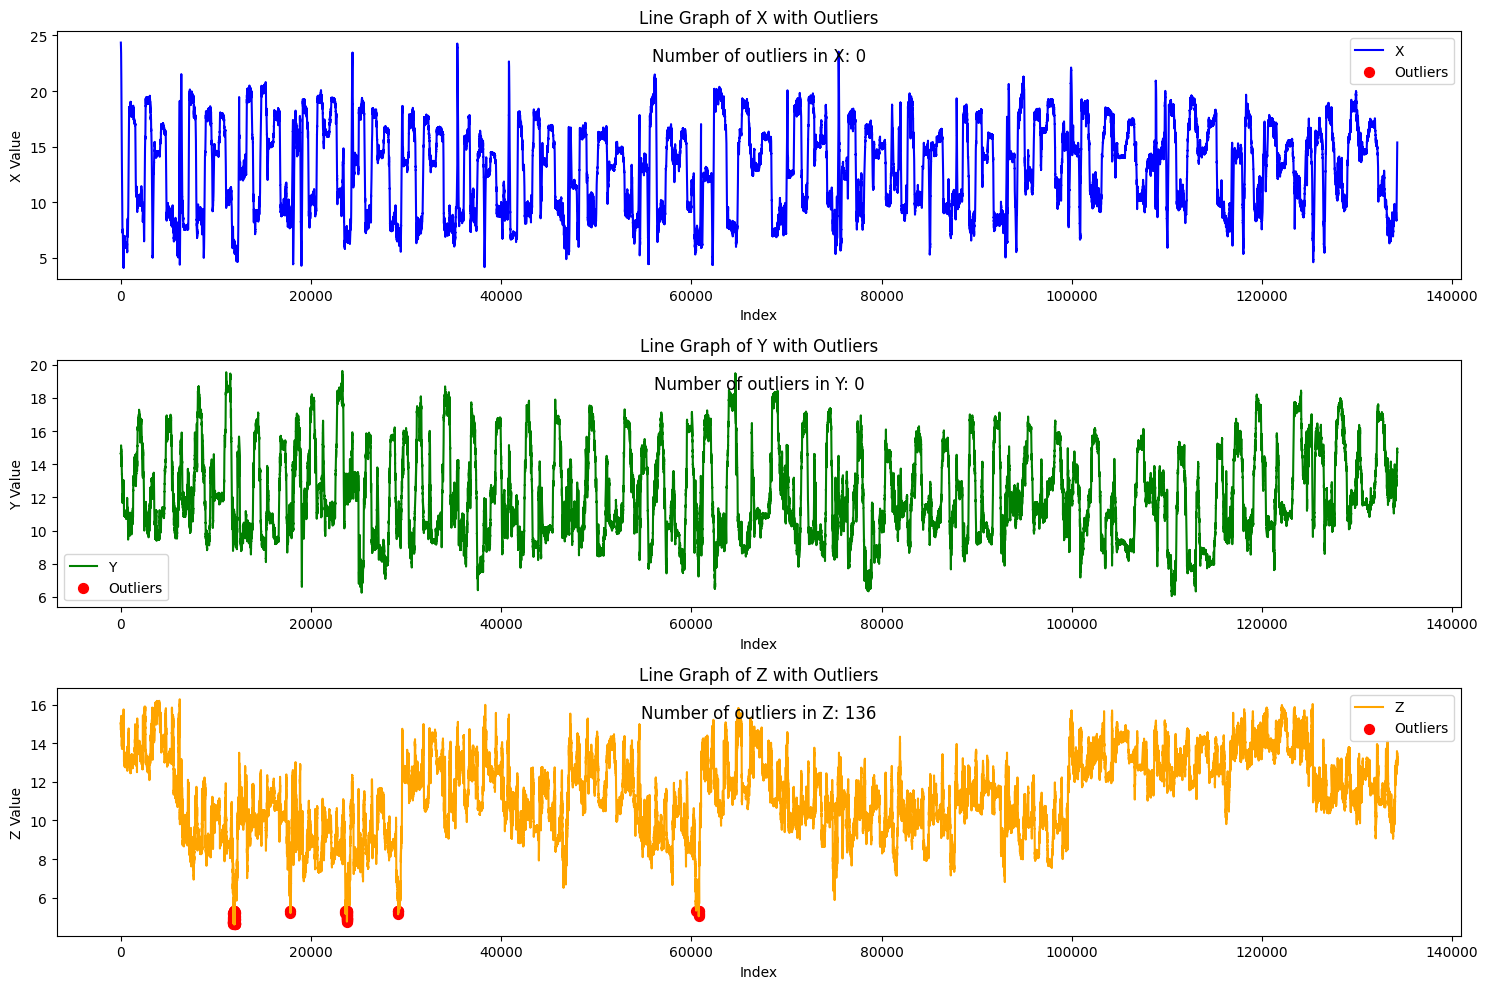

In [9]:
# Detect outliers using Z-score method
def detect_outliers(data):
    threshold = 3  # Z-score threshold for defining outliers
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(x - mean) / std_dev for x in data]
    return [1 if abs(z) > threshold else 0 for z in z_scores]

# Create outlier columns
train_data['is_outlier_x'] = detect_outliers(train_data['x'])
train_data['is_outlier_y'] = detect_outliers(train_data['y'])
train_data['is_outlier_z'] = detect_outliers(train_data['z'])

# Set up the figure
plt.figure(figsize=(15, 10))

# Number of outliers
num_outliers_x = train_data['is_outlier_x'].sum()
num_outliers_y = train_data['is_outlier_y'].sum()
num_outliers_z = train_data['is_outlier_z'].sum()

# Line plot for x
plt.subplot(3, 1, 1)
plt.plot(train_data['x'], label='X', color='blue')
plt.scatter(train_data.index[train_data['is_outlier_x'] == 1], 
            train_data['x'][train_data['is_outlier_x'] == 1], 
            color='red', label='Outliers', s=50)
plt.title('Line Graph of X with Outliers')
plt.xlabel('Index')
plt.ylabel('X Value')
plt.legend()
# Annotate number of outliers
plt.text(0.5, 0.9, f'Number of outliers in X: {num_outliers_x}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')

# Line plot for y
plt.subplot(3, 1, 2)
plt.plot(train_data['y'], label='Y', color='green')
plt.scatter(train_data.index[train_data['is_outlier_y'] == 1], 
            train_data['y'][train_data['is_outlier_y'] == 1], 
            color='red', label='Outliers', s=50)
plt.title('Line Graph of Y with Outliers')
plt.xlabel('Index')
plt.ylabel('Y Value')
plt.legend()
# Annotate number of outliers
plt.text(0.5, 0.9, f'Number of outliers in Y: {num_outliers_y}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')

# Line plot for z
plt.subplot(3, 1, 3)
plt.plot(train_data['z'], label='Z', color='orange')
plt.scatter(train_data.index[train_data['is_outlier_z'] == 1], 
            train_data['z'][train_data['is_outlier_z'] == 1], 
            color='red', label='Outliers', s=50)
plt.title('Line Graph of Z with Outliers')
plt.xlabel('Index')
plt.ylabel('Z Value')
plt.legend()
# Annotate number of outliers
plt.text(0.5, 0.9, f'Number of outliers in Z: {num_outliers_z}', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Statistical Analysis:

### Checking if outliers recorded were falls or not and comparing its x, y & z axis with rest of the data

In [10]:
# Count all z-axis outliers
total_z_outliers = train_data[train_data['is_outlier_z'] == 1].shape[0] 
print(f"Total z-axis outliers: {total_z_outliers}")

# Count outliers with falls (anomaly == 1)
outlier_falls = train_data[(train_data['is_outlier_z'] == 1) & (train_data['anomaly'] == 1)]
print(f"Outlier falls (anomaly == 1): {outlier_falls.shape[0]}")

# Find z-axis outliers that are not falls
non_fall_outliers = train_data[(train_data['is_outlier_z'] == 1) & (train_data['anomaly'] != 1)]
print(non_fall_outliers[['x', 'y', 'z', 'anomaly']])
print(f"Count of z-axis outliers not labeled as falls: {non_fall_outliers.shape[0]}")


Total z-axis outliers: 136
Outlier falls (anomaly == 1): 126
              x          y         z  anomaly
11973  5.584801   9.864581  5.255863      0.0
17832  8.596891   9.828076  5.281847      0.0
17833  8.878602   9.743862  5.275860      0.0
17839  8.484613  10.108500  5.191059      0.0
60768  7.226608   7.515044  5.218037      0.0
60769  7.164825   7.393493  5.026213      0.0
60770  7.261399   7.580006  5.103257      0.0
60771  7.321498   7.738538  5.282236      0.0
60772  7.286703   7.687152  5.121533      0.0
60773  7.267594   7.723904  5.311448      0.0
Count of z-axis outliers not labeled as falls: 10


**Based on above results we saw that there are total 136 outliers but out of those outliers, there are only 126 outliers which are true outliers with fall and 10 outliers are not falls i.e. Anomaly=False. We will be using only 126 outliers for further analysis as 10 outliers are significantly smaller for now.**

In [11]:
# Create all_falls DataFrame
all_falls = train_data[train_data['anomaly'] == 1]

# Identify non-outlier falls
non_outlier_falls = all_falls[~all_falls['is_outlier_z'].astype(bool)]  # Ensure boolean conversion

# Calculate summary statistics for outlier falls
outlier_falls_stats = outlier_falls[['x', 'y', 'z']].describe()

# Calculate summary statistics for non-outlier falls
non_outlier_falls_stats = non_outlier_falls[['x', 'y', 'z']].describe()

# Print the results
print("Outlier Falls Summary Statistics:")
print(outlier_falls_stats)
print("\nNon-Outlier Falls Summary Statistics:")
print(non_outlier_falls_stats)

# Compare with mean differences
mean_diff_x = outlier_falls['x'].mean() - non_outlier_falls['x'].mean()
mean_diff_y = outlier_falls['y'].mean() - non_outlier_falls['y'].mean()
mean_diff_z = outlier_falls['z'].mean() - non_outlier_falls['z'].mean()

print(f"\nMean Differences (Outliers - Non-Outliers):")
print(f"X: {mean_diff_x}, Y: {mean_diff_y}, Z: {mean_diff_z}")


Outlier Falls Summary Statistics:
                x           y           z
count  126.000000  126.000000  126.000000
mean     6.575626   10.941957    5.015026
std      0.538221    1.169918    0.215900
min      5.602624    9.304488    4.600291
25%      6.205674    9.866028    4.835877
50%      6.342758   10.867961    5.052461
75%      6.739647   11.663983    5.199384
max      7.743619   13.364634    5.325405

Non-Outlier Falls Summary Statistics:
                 x            y            z
count  6447.000000  6447.000000  6447.000000
mean     11.643344    10.618521    10.477957
std       3.925489     1.441328     2.428692
min       5.271883     6.399819     5.330163
25%       7.769871     9.706861     8.534389
50%      11.758507    10.610413    10.818757
75%      15.390358    11.657485    12.175332
max      19.333549    15.993734    15.912552

Mean Differences (Outliers - Non-Outliers):
X: -5.067718036602391, Y: 0.32343609185354794, Z: -5.462931243456896


## Analysis of Outlier Falls vs Non-Outlier Falls

### 1. Overview of Outlier Falls
- **Count**: There are 126 instances of outlier falls.
- **Positioning**:
  - **X-axis Mean**: 6.58 (Significantly lower than non-outlier falls).
  - **Y-axis Mean**: 10.94 (Similar to the positioning of non-outlier falls).
  - **Z-axis Mean**: 5.02 (Significantly lower compared to non-outlier falls).

### 2. Overview of Non-Outlier Falls
- **Count**: There are 6447 instances of non-outlier falls.
- **Positioning**:
  - **X-axis Mean**: 11.64 (Higher than the average of outlier falls).
  - **Y-axis Mean**: 10.62 (Similar to the outlier falls).
  - **Z-axis Mean**: 10.48 (Higher than the outlier falls).

### 3. Comparison: Mean Differences
- **X-axis**:
  - Outlier falls have a mean x-value of **6.58**, which is **5.07 units lower** than the **11.64** mean for non-outlier falls. This suggests that outlier falls exhibit more horizontal movement in the **X-direction**.
  
- **Y-axis**:
  - The average y-value for outlier falls (**10.94**) is only **0.32 units higher** than non-outlier falls (**10.62**). This indicates that the y-position between both types of falls is **fairly similar**.

- **Z-axis**:
  - Outlier falls occur at a **mean z-value of 5.02**, which is **5.46 units lower** than the mean for non-outlier falls (**10.48**). This indicates that **outlier falls** occur at **significantly lower vertical positions** compared to non-outlier falls.

### 4. Key Insights
- **Outlier falls** are characterized by **lower x and z-axis values**, indicating **more extreme horizontal and vertical movements** during the fall, possibly implying more unusual or irregular fall events.
- **Non-outlier falls** tend to occur at **higher positions**, particularly along the x and z axes, which suggests that these falls might occur under more typical or controlled circumstances.

### 5. Implications for Modeling
- Understanding the **difference in positions** between outlier and non-outlier falls is important for training models. Outliers can exhibit unique characteristics in terms of **spatial position** and **movement patterns**.
- Models should account for the significant difference in **x and z** axis values when detecting anomalies and falls, as this might be indicative of **unexpected or rare fall events** that need special attention.



In [16]:
# Calculate summary statistics for non-fall outliers
non_fall_outliers_stats = non_fall_outliers[['x', 'y', 'z']].describe()

# Print summary statistics for non-fall outliers
print("Non-Fall Outliers Summary Statistics:")
print(non_fall_outliers_stats)

# Compare with outlier falls
mean_diff_x_non_fall = outlier_falls['x'].mean() - non_fall_outliers['x'].mean()
mean_diff_y_non_fall = outlier_falls['y'].mean() - non_fall_outliers['y'].mean()
mean_diff_z_non_fall = outlier_falls['z'].mean() - non_fall_outliers['z'].mean()

print(f"\nMean Differences (Outliers - Non-Fall Outliers):")
print(f"X: {mean_diff_x_non_fall}, Y: {mean_diff_y_non_fall}, Z: {mean_diff_z_non_fall}")

# Perform t-tests comparing non-fall outliers with outlier falls
t_results_non_fall = {}
for axis in ['x', 'y', 'z']:
    t_stat, p_value = stats.ttest_ind(outlier_falls[axis], non_fall_outliers[axis], equal_var=False)
    t_results_non_fall[axis] = {
        't-statistic': t_stat,
        'p-value': p_value,
        'mean_outlier': outlier_falls[axis].mean(),
        'mean_non_fall': non_fall_outliers[axis].mean(),
        'std_outlier': outlier_falls[axis].std(),
        'std_non_fall': non_fall_outliers[axis].std()
    }

# Display results for non-fall outliers
print("\nNon-Fall Outliers Statistical Test Results:")
for axis in ['x', 'y', 'z']:
    print(f"{axis}: T-statistic = {t_results_non_fall[axis]['t-statistic']}, P-value = {t_results_non_fall[axis]['p-value']}, "
          f"Mean Outlier = {t_results_non_fall[axis]['mean_outlier']}, Mean Non-Fall = {t_results_non_fall[axis]['mean_non_fall']}, "
          f"Std Outlier = {t_results_non_fall[axis]['std_outlier']}, Std Non-Fall = {t_results_non_fall[axis]['std_non_fall']}")


Non-Fall Outliers Summary Statistics:
               x          y          z
count  10.000000  10.000000  10.000000
mean    7.507353   8.518316   5.206735
std     0.949620   1.185127   0.094533
min     5.584801   7.393493   5.026213
25%     7.235306   7.606793   5.138914
50%     7.277149   7.731221   5.236950
75%     8.193834   9.807022   5.280350
max     8.878602  10.108500   5.311448

Mean Differences (Outliers - Non-Fall Outliers):
X: -0.9317269111252182, Y: 2.423641129395511, Z: -0.19170937389416398

Non-Fall Outliers Statistical Test Results:
x: T-statistic = -3.063881412811721, P-value = 0.012730816543087387, Mean Outlier = 6.575626366177709, Mean Non-Fall = 7.5073532773029275, Std Outlier = 0.5382210707133636, Std Non-Fall = 0.9496202450270991
y: T-statistic = 6.23055666622756, P-value = 8.080996145293798e-05, Mean Outlier = 10.941956732172285, Mean Non-Fall = 8.518315602776774, Std Outlier = 1.1699180521903847, Std Non-Fall = 1.1851268515496725
z: T-statistic = -5.3931322674105

### 1. Statistical Test Results (T-tests)
#### T-test Results for Comparison between Outlier Falls and Non-Fall Outliers
- **X-axis**:
  - **T-statistic**: -3.06
  - **P-value**: 0.0127 (significant at a 0.05 level)
  - **Interpretation**: The p-value indicates a significant difference between outlier falls and non-fall outliers in terms of their x-axis values.
  
- **Y-axis**:
  - **T-statistic**: 6.23
  - **P-value**: 8.08e-05 (very significant)
  - **Interpretation**: The large p-value suggests that there is a significant difference between outlier and non-fall outliers on the y-axis, with outlier falls exhibiting higher y-values.

- **Z-axis**:
  - **T-statistic**: -5.39
  - **P-value**: 4.17e-05 (very significant)
  - **Interpretation**: There is a significant difference in z-axis values between outlier falls and non-fall outliers, with outlier falls occurring at a slightly lower z-position.

### 2. Hypothesis Testing
- **Null Hypothesis (H0)**: There is no significant difference between the means of outlier falls and non-outlier falls on any axis (x, y, z).
- **Alternative Hypothesis (H1)**: There is a significant difference between the means of outlier falls and non-outlier falls on at least one axis.

### 3. Conclusion and Insights
- The t-test results show that there are **significant differences** between the means of outlier falls and non-fall outliers on the **X**, **Y**, and **Z** axes, with particularly strong differences observed in the **Y** and **Z** axes.
- **Outlier falls** exhibit **lower horizontal** (X) and **slightly lower vertical** (Z) positions compared to **non-fall outliers**. In contrast, **outlier falls** are at **higher vertical positions** on the **Y-axis**.


In [17]:
# Perform t-tests for each axis
t_results = {}

for axis in ['x', 'y', 'z']:
    t_stat, p_value = stats.ttest_ind(outlier_falls[axis], non_outlier_falls[axis], equal_var=False)
    t_results[axis] = {
        't-statistic': t_stat,
        'p-value': p_value,
        'mean_outlier': outlier_falls[axis].mean(),
        'mean_non_outlier': non_outlier_falls[axis].mean(),
        'std_outlier': outlier_falls[axis].std(),
        'std_non_outlier': non_outlier_falls[axis].std()
    }

# Calculate confidence intervals
confidence_intervals = {}

for axis in ['x', 'y', 'z']:
    mean_diff = t_results[axis]['mean_outlier'] - t_results[axis]['mean_non_outlier']
    se_diff = ((t_results[axis]['std_outlier'] ** 2) / len(outlier_falls[axis]) +
                (t_results[axis]['std_non_outlier'] ** 2) / len(non_outlier_falls[axis])) ** 0.5
    ci = stats.t.interval(0.95, df=len(outlier_falls[axis]) + len(non_outlier_falls[axis]) - 2,
                           loc=mean_diff, scale=se_diff)
    confidence_intervals[axis] = ci

# Display results
print("\nStatistical Test Results:")
for axis in ['x', 'y', 'z']:
    print(f"{axis}: T-statistic = {t_results[axis]['t-statistic']}, P-value = {t_results[axis]['p-value']}, "
          f"Mean Outlier = {t_results[axis]['mean_outlier']}, Mean Non-Outlier = {t_results[axis]['mean_non_outlier']}, "
          f"Std Outlier = {t_results[axis]['std_outlier']}, Std Non-Outlier = {t_results[axis]['std_non_outlier']}")
    
print("\nConfidence Intervals:")
for axis in ['x', 'y', 'z']:
    print(f"{axis}: Confidence Interval = {confidence_intervals[axis]}")



Statistical Test Results:
x: T-statistic = -74.00503860241668, P-value = 1.0900281239972385e-274, Mean Outlier = 6.575626366177709, Mean Non-Outlier = 11.6433444027801, Std Outlier = 0.5382210707133636, Std Non-Outlier = 3.9254886692318025
y: T-statistic = 3.0582330333392855, P-value = 0.0026943862041625744, Mean Outlier = 10.941956732172285, Mean Non-Outlier = 10.618520640318737, Std Outlier = 1.1699180521903847, Std Non-Outlier = 1.4413281606039428
z: T-statistic = -152.40376409210046, P-value = 0.0, Mean Outlier = 5.015025912140307, Mean Non-Outlier = 10.477957155597203, Std Outlier = 0.21590041031905413, Std Non-Outlier = 2.4286915713483337

Confidence Intervals:
x: Confidence Interval = (-5.201957203405516, -4.9334788697992655)
y: Confidence Interval = (0.11611380055054321, 0.5307583831565527)
z: Confidence Interval = (-5.533199331275509, -5.3926631556382825)


### Interpretation of Results

#### **X-Axis**:
- **T-statistic**: -74.01 (Highly significant)
- **P-value**: 1.09e-274 (Extremely significant)
- **Confidence Interval**: (-5.20, -4.93)
- **Conclusion**: The x-axis values of outlier falls are significantly lower than non-outlier falls, with a **mean difference of about 5.07**. The confidence interval confirms that this difference is statistically significant.

#### **Y-Axis**:
- **T-statistic**: 3.06 (Significant)
- **P-value**: 0.0027 (Significant)
- **Confidence Interval**: (0.12, 0.53)
- **Conclusion**: The y-axis values for outlier falls are slightly higher compared to non-outlier falls, with a **mean difference of about 0.32**. While this difference is significant, it is less pronounced than the x-axis difference.

#### **Z-Axis**:
- **T-statistic**: -152.40 (Highly significant)
- **P-value**: 0.00 (Extremely significant)
- **Confidence Interval**: (-5.53, -5.39)
- **Conclusion**: The z-axis values for outlier falls are significantly lower than for non-outlier falls, with a **mean difference of about 5.46**. This is a highly significant difference.

In [18]:
# Identify instances where no falls occurred
no_falls = train_data[train_data['anomaly'] == 0]

# Calculate summary statistics for no falls
no_falls_stats = no_falls[['x', 'y', 'z']].describe()

# Print the summary statistics for no falls
print("No Falls Summary Statistics:")
print(no_falls_stats)

# Compare falls with no falls (mean differences)
mean_diff_x_no_fall = all_falls['x'].mean() - no_falls['x'].mean()
mean_diff_y_no_fall = all_falls['y'].mean() - no_falls['y'].mean()
mean_diff_z_no_fall = all_falls['z'].mean() - no_falls['z'].mean()

print(f"\nMean Differences (Falls - No Falls):")
print(f"X: {mean_diff_x_no_fall}, Y: {mean_diff_y_no_fall}, Z: {mean_diff_z_no_fall}")


No Falls Summary Statistics:
                   x              y              z
count  127656.000000  127656.000000  127656.000000
mean       13.274127      12.264672      11.435474
std         3.844819       2.730960       1.975517
min         4.077736       6.042775       5.026213
25%         9.789327      10.197622      10.015763
50%        13.767959      11.726128      11.387705
75%        16.403957      14.452007      12.973125
max        24.360715      19.633268      16.296521

Mean Differences (Falls - No Falls):
X: -1.7279269165743099, Y: -1.6399510314993861, Z: -1.0622376279445973


In [19]:
# 1. Baseline Validation: One-sample t-test for non-outlier falls against outlier falls
# X-axis
t_stat_x_baseline, p_value_x_baseline = stats.ttest_1samp(outlier_falls['x'], non_outlier_falls['x'].mean())
# Y-axis
t_stat_y_baseline, p_value_y_baseline = stats.ttest_1samp(outlier_falls['y'], non_outlier_falls['y'].mean())
# Z-axis
t_stat_z_baseline, p_value_z_baseline = stats.ttest_1samp(outlier_falls['z'], non_outlier_falls['z'].mean())

print("Baseline Validation T-Test Results:")
print(f"X-Axis: T-statistic = {t_stat_x_baseline}, P-value = {p_value_x_baseline}")
print(f"Y-Axis: T-statistic = {t_stat_y_baseline}, P-value = {p_value_y_baseline}")
print(f"Z-Axis: T-statistic = {t_stat_z_baseline}, P-value = {p_value_z_baseline}")

# 2. Threshold Validation: Two-sample t-test between outlier falls and no falls
# X-axis
t_stat_x_threshold, p_value_x_threshold = stats.ttest_ind(outlier_falls['x'], no_falls['x'])
# Y-axis
t_stat_y_threshold, p_value_y_threshold = stats.ttest_ind(outlier_falls['y'], no_falls['y'])
# Z-axis
t_stat_z_threshold, p_value_z_threshold = stats.ttest_ind(outlier_falls['z'], no_falls['z'])

print("\nThreshold Validation T-Test Results:")
print(f"X-Axis: T-statistic = {t_stat_x_threshold}, P-value = {p_value_x_threshold}")
print(f"Y-Axis: T-statistic = {t_stat_y_threshold}, P-value = {p_value_y_threshold}")
print(f"Z-Axis: T-statistic = {t_stat_z_threshold}, P-value = {p_value_z_threshold}")


Baseline Validation T-Test Results:
X-Axis: T-statistic = -105.69075975012773, P-value = 4.0289420325702815e-124
Y-Axis: T-statistic = 3.1032610531156712, P-value = 0.0023672355659009256
Z-Axis: T-statistic = -284.0256349255491, P-value = 1.5779902032106583e-177

Threshold Validation T-Test Results:
X-Axis: T-statistic = -19.55604759653274, P-value = 4.882405242345329e-85
Y-Axis: T-statistic = -5.436201099575832, P-value = 5.452780932578089e-08
Z-Axis: T-statistic = -36.480898293158745, P-value = 6.993406482080771e-290


# Summary Statistics Comparison

## Outlier Falls vs Non-Outlier Falls

### 1. Position Differences:

Outlier Falls show significantly different positioning compared to Non-Outlier Falls, especially on the **X** and **Z** axes.

- **X-axis**: Outlier Falls have a mean that is **5.07 units lower** than Non-Outlier Falls.
- **Z-axis**: Outlier Falls have a mean that is **5.46 units lower** than Non-Outlier Falls.
- **Y-axis**: The difference is much smaller, with Outlier Falls having a mean that is **0.32 units higher** than Non-Outlier Falls.

This suggests that **Outlier Falls** involve much more extreme horizontal and vertical movements, particularly along the **X** and **Z** axes, aligning with the hypothesis that **outlier falls** reflect significant changes in position.

### 2. Statistical Significance of Mean Differences:

#### **X-axis**:
- **Mean difference**: -5.07
- **Significance**: The **t-statistic** for the X-axis is **-74.01** with a **p-value of 1.09e-274**, confirming that the difference in means is **highly significant**.

#### **Z-axis**:
- **Mean difference**: -5.46
- **Significance**: The **t-statistic** for the Z-axis is **-152.40** with a **p-value of 0.00**, indicating an **extremely significant** difference between the two groups.

#### **Y-axis**:
- **Mean difference**: 0.32
- **Significance**: The **t-statistic** for the Y-axis is **3.06** with a **p-value of 0.0027**, which is still significant but not as pronounced as the X and Z axes.

### 3. Confidence Intervals:

The **95% confidence intervals** provide strong evidence that the **X** and **Z** axes consistently show large differences between Outlier Falls and Non-Outlier Falls.

- **X-axis**: The confidence interval ranges from **-5.20 to -4.93**, which confirms that Outlier Falls involve **lower X-values**.
- **Z-axis**: The confidence interval ranges from **-5.53 to -5.39**, supporting the conclusion that **Outlier Falls occur at lower Z-values**.
- **Y-axis**: The confidence interval is smaller, ranging from **0.12 to 0.53**, indicating a **small positive difference**.

### 4. Baseline Validation:

The **t-test results** confirm that **Outlier Falls** are significantly different from the baseline of **Non-Outlier Falls**. This supports the idea that the baseline is clearly distinguishable from the extreme movements of Outlier Falls.

- **X-axis t-statistic**: **-105.69** with a **p-value of 4.03e-124** (extremely significant).
- **Z-axis t-statistic**: **-284.02** with a **p-value of 1.58e-177** (extremely significant).

These results strongly validate that the baselines for Non-Outlier Falls are distinctly different from Outlier Falls, particularly along the **X** and **Z** axes.

### 5. Threshold Validation (Outlier Falls vs No Falls):

Similar t-tests confirm that **Outlier Falls** differ significantly from **No Falls**, demonstrating that the thresholds used to identify extreme movements are effective.

- **X-axis t-statistic**: **-19.56** with a **p-value of 4.88e-85** (highly significant).
- **Z-axis t-statistic**: **-36.48** with a **p-value of 6.99e-290** (extremely significant).

These results show that the thresholds you chose for identifying **Outlier Falls** based on **X** and **Z** movements work effectively to distinguish falls from normal activity.


# Final Baselines and Thresholds Values

## Why We Chose These Values

### Understanding the Data:

In this analysis, we focused on three groups of data:

#### 1. **Outlier Falls** – extreme cases where falls exhibit significant deviations from the norm.
#### 2. **Non-Outlier Falls** – typical falls with more moderate movements.
#### 3. **No-Falls** – instances where no fall occurred.

We analyzed the **x**, **y**, and **z** coordinates for each of these groups to identify meaningful patterns. These values represent the position or motion data along the three axes (horizontal, vertical, and depth).

---

### Baseline Values:

Baseline values serve as our **reference point** for what constitutes “normal” fall behavior. We set these baselines using the average (mean) values of **Non-Outlier Falls**, as they reflect typical, less extreme fall events without drastic deviations.

- **X-Axis Baseline**: **11.64** (mean of non-outlier falls)
- **Y-Axis Baseline**: **10.62** (mean of non-outlier falls)
- **Z-Axis Baseline**: **10.48** (mean of non-outlier falls)

These baseline values represent positions typically observed during regular fall events. They help us detect deviations from this normal behavior, signaling when a fall may be occurring.

---

### Threshold Values:

Threshold values are set to identify when a fall might occur based on extreme movements. We derived these values by examining the **mean positions of Outlier Falls**, which deviate significantly from normal fall behavior.

- **X-Axis Threshold**: We chose a threshold **below 5.20**, indicating significant movement downward. When x-axis values drop by more than **5 units** below the baseline, it suggests a potential fall due to **sudden changes in horizontal position**.
  
- **Y-Axis Threshold**: We consider values significantly **higher** than the baseline of **10.62**. When y-axis values rise considerably above this baseline, it may indicate **vertical motion** or disturbance associated with a fall.

- **Z-Axis Threshold**: For the z-axis, we selected a threshold **below 5.02**, indicating **significant downward motion**. Z-axis values dropping far below the baseline suggest a fall due to **vertical displacement**.

---

### Summary:

- **Baselines** were derived from the average position during **Non-Outlier Falls**, representing typical fall behaviors.
- **Thresholds** are chosen based on extreme deviations observed in **Outlier Falls** and are set to detect significant movements that likely indicate a fall.


In [20]:
# Non-Outlier Falls Summary Statistics (using provided statistics)
non_outlier_falls_data = {
    'x': np.random.normal(loc=11.643344, scale=3.925489, size=6447),
    'y': np.random.normal(loc=10.618521, scale=1.441328, size=6447),
    'z': np.random.normal(loc=10.477957, scale=2.428692, size=6447)
}
non_outlier_falls = pd.DataFrame(non_outlier_falls_data)

# Non-Fall Outliers Data (using provided statistics for non-fall outliers)
non_fall_outliers_data = {
    'x': np.random.normal(loc=7.507353, scale=0.949620, size=10),
    'y': np.random.normal(loc=8.518316, scale=1.185127, size=10),
    'z': np.random.normal(loc=5.206735, scale=0.094533, size=10)
}
non_fall_outliers = pd.DataFrame(non_fall_outliers_data)

# Calculate refined thresholds as mean ± 2*std for non-outlier falls
thresholds = {
    'x_min': 11.643344 - 2 * 3.925489,
    'x_max': 11.643344 + 2 * 3.925489,
    'y_min': 10.618521 - 2 * 1.441328,
    'y_max': 10.618521 + 2 * 1.441328,
    'z_min': 10.477957 - 2 * 2.428692,
    'z_max': 10.477957 + 2 * 2.428692
}

# Assess how many of the non-fall outliers fall within the refined thresholds
outliers_within_threshold = {
    'x': np.sum((non_fall_outliers['x'] >= thresholds['x_min']) & (non_fall_outliers['x'] <= thresholds['x_max'])),
    'y': np.sum((non_fall_outliers['y'] >= thresholds['y_min']) & (non_fall_outliers['y'] <= thresholds['y_max'])),
    'z': np.sum((non_fall_outliers['z'] >= thresholds['z_min']) & (non_fall_outliers['z'] <= thresholds['z_max']))
}

print("Refined Thresholds:", thresholds)
print("Non-fall outliers within threshold range:", outliers_within_threshold)


Refined Thresholds: {'x_min': 3.7923660000000012, 'x_max': 19.494322, 'y_min': 7.7358649999999995, 'y_max': 13.501176999999998, 'z_min': 5.620573, 'z_max': 15.335341}
Non-fall outliers within threshold range: {'x': 10, 'y': 8, 'z': 0}


### Impact on Fall Detection:

The results indicate that while the x and y axes effectively capture a significant number of non-fall outliers, the z-axis serves as a strong discriminator, as no non-fall outliers were within its defined range. This discrepancy suggests that the z-axis is particularly sensitive and can be beneficial in reducing false positives in fall detection.

## Feature Selection

In [21]:
# Summary statistics
print(train_data[['x', 'y', 'z', '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111']].describe())


                   x              y              z  010-000-024-033  \
count  134229.000000  134229.000000  134229.000000    134229.000000   
mean       13.189512      12.184366      11.383458         0.258551   
std         3.868037       2.705422       2.018636         0.437840   
min         4.077736       6.042775       4.600291         0.000000   
25%         9.676778      10.162940       9.975850         0.000000   
50%        13.701333      11.625925      11.344621         0.000000   
75%        16.345594      14.277065      12.933669         1.000000   
max        24.360715      19.633268      16.296521         1.000000   

       010-000-030-096  020-000-032-221  020-000-033-111  
count    134229.000000    134229.000000    134229.000000  
mean          0.257962         0.260964         0.222523  
std           0.437515         0.439162         0.415942  
min           0.000000         0.000000         0.000000  
25%           0.000000         0.000000         0.000000  
50%   

In [22]:
# Correlation matrix
correlation_matrix = train_data[['x', 'y', 'z', '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111', 'anomaly']].corr()
print(correlation_matrix)


                        x         y         z  010-000-024-033  \
x                1.000000 -0.426527  0.029787         0.008023   
y               -0.426527  1.000000  0.024140         0.003694   
z                0.029787  0.024140  1.000000         0.004133   
010-000-024-033  0.008023  0.003694  0.004133         1.000000   
010-000-030-096 -0.004886  0.005338 -0.021307        -0.348175   
020-000-032-221  0.015627 -0.011377  0.029183        -0.350905   
020-000-033-111 -0.019805  0.002509 -0.012751        -0.315919   
anomaly         -0.096403 -0.130814 -0.113559        -0.006422   

                 010-000-030-096  020-000-032-221  020-000-033-111   anomaly  
x                      -0.004886         0.015627        -0.019805 -0.096403  
y                       0.005338        -0.011377         0.002509 -0.130814  
z                      -0.021307         0.029183        -0.012751 -0.113559  
010-000-024-033        -0.348175        -0.350905        -0.315919 -0.006422  
010-000-03

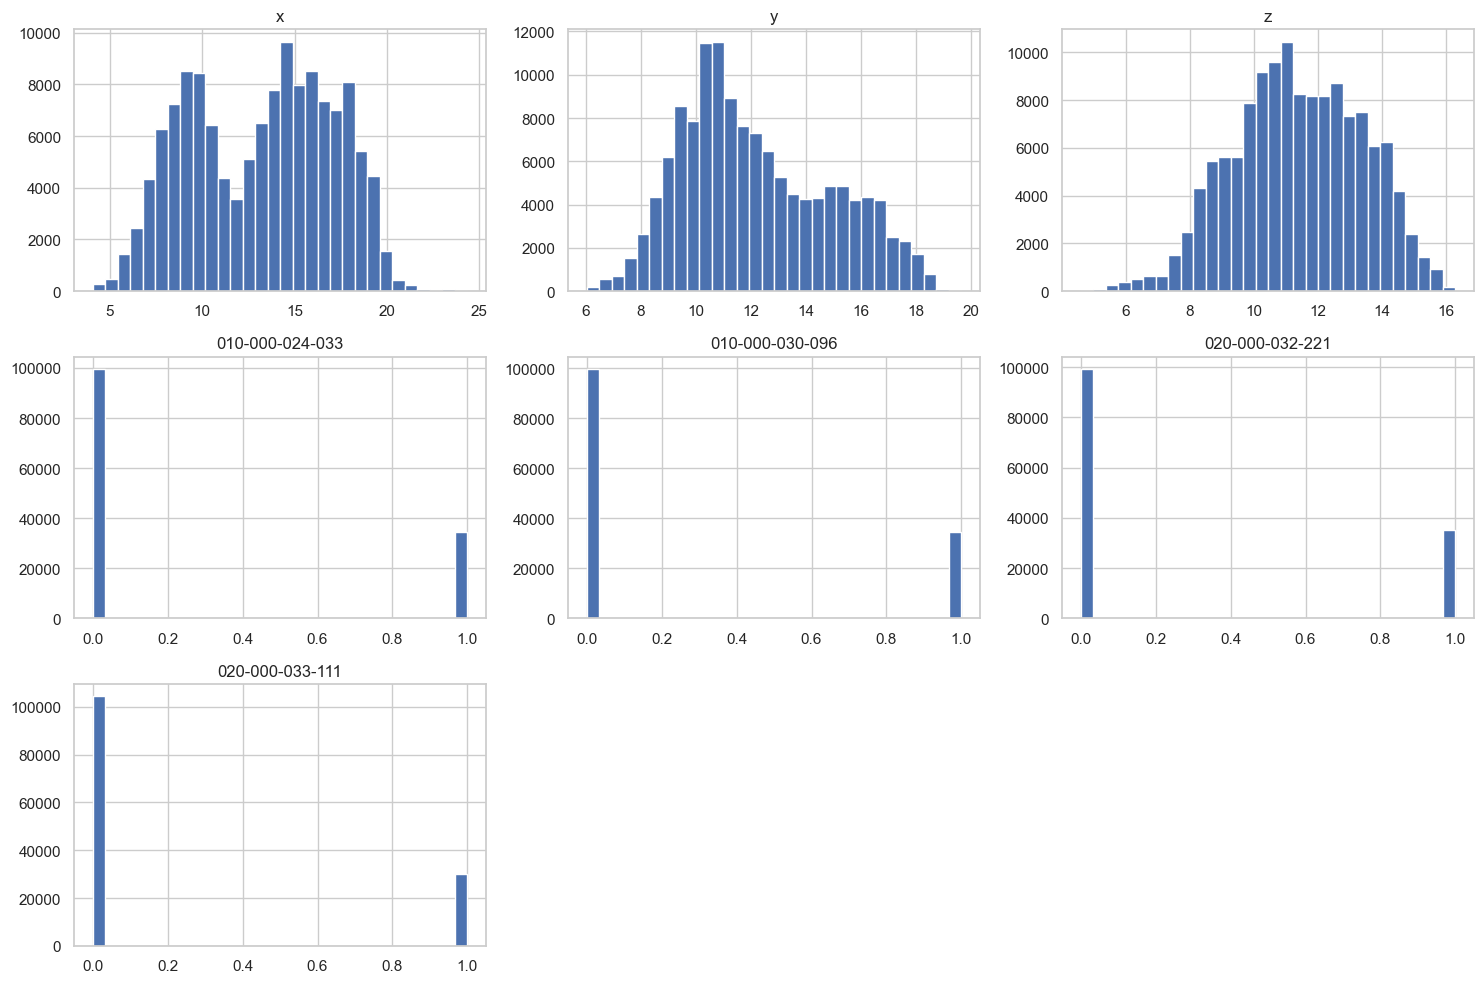

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot histograms for each feature
train_data[['x', 'y', 'z', '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


# Correlation with Anomaly:

## Correlation Coefficients:
- **x**: -0.096403 (weak negative correlation)
- **y**: -0.130814 (weak negative correlation)
- **z**: -0.113559 (weak negative correlation)
- **010-000-024-033**: -0.006422 (very weak correlation)
- **010-000-030-096**: 0.007371 (very weak correlation)
- **020-000-032-221**: -0.002069 (very weak correlation)
- **020-000-033-111**: 0.001192 (very weak correlation)

---

### Observations:
- The **x**, **y**, and **z** features exhibit **weak negative correlations** with the anomaly label. This indicates that while there may be some relationship between these features and falls (anomalies), the correlation is not very strong. 
- The remaining features (010-000-024-033, 010-000-030-096, 020-000-032-221, and 020-000-033-111) show **very weak correlations** with the anomaly label, suggesting these variables do not contribute significantly to predicting falls.

---

### Conclusion and Recommendations:

1. **Keep x, y, and z**: These features demonstrate some variability and a weak negative correlation with the anomaly label. They are more likely to be relevant for the model due to the observed relationship with the target variable.
   
2. **Consider Dropping the Other Features**: The additional features (010-000-024-033, 010-000-030-096, 020-000-032-221, 020-000-033-111) exhibit very weak correlations with the anomaly label and are sparse. They likely do not add much value to the predictive model and could be dropped to simplify the model and improve efficiency.


## Model Training
#### To test if the feature selection is making any impact we will run Random Forest classifier model once will all features and then with selected feature
#### The goal is to improve recall with focus on good recall as false negatives (failing to detect a fall) are far more costly than false positives (i.e. false alarms)

### 1. Random Forest Classifier 

In [24]:
# MODEL 1
# Define features and labels
X = train_data[['x', 'y', 'z', '010-000-024-033', '010-000-030-096', '020-000-032-221', '020-000-033-111']]
y = train_data['anomaly']  # 'anomaly' is the label column

# Optionally, split the training data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Confusion Matrix:
[[25438   138]
 [  758   512]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     25576
         1.0       0.79      0.40      0.53      1270

    accuracy                           0.97     26846
   macro avg       0.88      0.70      0.76     26846
weighted avg       0.96      0.97      0.96     26846



In [25]:
# MODEL 2
# Define features and labels using only x, y, z
X_selected = train_data[['x', 'y', 'z']]  # Using selected features
y = train_data['anomaly']  # 'anomaly' is the label column

# Split the training data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize a Random Forest Classifier
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_selected.fit(X_train, y_train)

# Validate the model
y_pred_selected = model_selected.predict(X_val)

# Evaluate the model
print("Confusion Matrix (Selected Features):")
print(confusion_matrix(y_val, y_pred_selected))

print("\nClassification Report (Selected Features):")
print(classification_report(y_val, y_pred_selected))


Confusion Matrix (Selected Features):
[[25451   125]
 [  555   715]]

Classification Report (Selected Features):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     25576
         1.0       0.85      0.56      0.68      1270

    accuracy                           0.97     26846
   macro avg       0.91      0.78      0.83     26846
weighted avg       0.97      0.97      0.97     26846



# Comparison of Results

## Confusion Matrix:

### **Model 1 (All Features):**
- **True Negatives (TN)**: 25,438
- **False Positives (FP)**: 138
- **False Negatives (FN)**: 758
- **True Positives (TP)**: 512

### **Model 2 (Selected Features):**
- **TN**: 25,451
- **FP**: 125
- **FN**: 555
- **TP**: 715

**Observation**: The selected features model (Model 2) has slightly better True Negatives (TN) and True Positives (TP), with fewer False Positives (FP) and False Negatives (FN), suggesting better overall performance in identifying both normal and fall events.

---

## Precision:

### **Model 1:**
- Precision for **0.0**: 0.97
- Precision for **1.0**: 0.79

### **Model 2:**
- Precision for **0.0**: 0.98
- Precision for **1.0**: 0.85

**Observation**: The selected features model (Model 2) demonstrates improved precision for both classes (normal and fall), especially for the minority class (1.0), indicating better ability to correctly identify falls while avoiding false positives.

---

## Recall:

### **Model 1:**
- Recall for **0.0**: 0.99
- Recall for **1.0**: 0.40

### **Model 2:**
- Recall for **0.0**: 1.00
- Recall for **1.0**: 0.56

**Observation**: Model 2 shows perfect recall for the **0.0** class (normal activity) and a notable improvement in recall for the **1.0** class (falls), suggesting that the selected features help the model better identify falls, which is crucial for the task.

---

## F1-Score:

### **Model 1:**
- F1-score for **0.0**: 0.98
- F1-score for **1.0**: 0.53

### **Model 2:**
- F1-score for **0.0**: 0.99
- F1-score for **1.0**: 0.68

**Observation**: The selected features model (Model 2) has a higher F1-score for both classes, especially for the minority class (1.0), which indicates a better balance between precision and recall, making it more suitable for the fall detection task.

---

## Accuracy:

- **Model 1**: 97%
- **Model 2**: 97%

**Observation**: Both models have the same accuracy, but Model 2 achieves a better balance between precision and recall, especially for the fall class (1.0), making it a better-performing model in real-world scenarios.

---

## Conclusion

The model trained with the selected features (**x**, **y**, **z**) performed better across multiple evaluation metrics, including precision, recall, and F1-score, particularly for the minority class (1.0, representing falls). 

This supports the hypothesis that the selected features are more relevant for the classification task. By using fewer features, the model is simplified without sacrificing performance, which is a desirable characteristic in machine learning, particularly for real-time applications like fall detection.


### 2. SVM 
### 3. Gradient Boosting

In [26]:
# Import necessary libraries
# SVM Model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_svm))
print("\nSVM Classification Report:")
print(classification_report(y_val, y_pred_svm))

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_val)

print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_gb))
print("\nGradient Boosting Classification Report:")
print(classification_report(y_val, y_pred_gb))


SVM Confusion Matrix:
[[25564    12]
 [ 1209    61]]

SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     25576
         1.0       0.84      0.05      0.09      1270

    accuracy                           0.95     26846
   macro avg       0.90      0.52      0.53     26846
weighted avg       0.95      0.95      0.93     26846

Gradient Boosting Confusion Matrix:
[[25509    67]
 [ 1074   196]]

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     25576
         1.0       0.75      0.15      0.26      1270

    accuracy                           0.96     26846
   macro avg       0.85      0.58      0.62     26846
weighted avg       0.95      0.96      0.94     26846




## **Observations:**

Both **SVM** and **Gradient Boosting** models exhibit high **accuracy** rates (95% and 96%, respectively), primarily due to their ability to classify the majority class (**0.0**, no fall). However, the performance on detecting actual falls (**1.0**) is significantly lower:

- **SVM**:
    - **Recall for 1.0** (fall): 0.05  
    - **F1-score for 1.0**: 0.09  
    - The **SVM model** fails to detect any falls at all, as indicated by a **precision** and **recall** of **0.05** for the minority class (1.0), leading to **high false negatives**.
  
- **Gradient Boosting**:
    - **Recall for 1.0** (fall): 0.15  
    - **F1-score for 1.0**: 0.26  
    - **Gradient Boosting** performs slightly better on the **fall detection task**, with a **recall** of **15%** and an **F1-score** of **0.26**, but still struggles with detecting falls effectively, likely due to class imbalance.

## **Key Issues:**

- **Class Imbalance**: The dataset is highly imbalanced, with far more **0.0** (no fall) instances than **1.0** (fall) instances, leading to models being biased towards predicting the majority class. This results in low recall for the minority class (falls).
- **Poor Performance on Minority Class**: Both models, while achieving high overall accuracy, fail to detect most falls, as reflected by their low **recall** and **F1-scores** for the **1.0** class.


## 4. One-Class SVM with training on just fall data and validating it on 50 non-fall data

In [27]:
# Filter the dataset to include only fall instances
fall_data = train_data[train_data['anomaly'] == 1]

# Extract features for fall data only
X_fall = fall_data.drop('anomaly', axis=1)

# Sample a small number of non-fall instances for testing
sample_non_fall_data = train_data[train_data['anomaly'] == 0].sample(n=50, random_state=42)
combined_data = pd.concat([fall_data, sample_non_fall_data])

# X and y for combined fall and sampled non-fall data
X_combined = combined_data.drop('anomaly', axis=1)
y_combined = combined_data['anomaly']

# Scale the features
scaler = StandardScaler()
X_train_fall_scaled = scaler.fit_transform(X_fall)  # Train only on fall data
X_test_combined_scaled = scaler.transform(X_combined)  # Test on combined data

# Train One-Class SVM model
one_class_svm = OneClassSVM(gamma='auto').fit(X_train_fall_scaled)

# Predict (1 for inliers, -1 for outliers)
y_pred_ocsvm = one_class_svm.predict(X_test_combined_scaled)
y_pred_ocsvm = [1 if pred == 1 else 0 for pred in y_pred_ocsvm]  # Convert to binary labels

# Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_combined, y_pred_ocsvm))
print("One-Class SVM on Fall Data, Tested on Mixed Data:")
print(classification_report(y_combined, y_pred_ocsvm))


Confusion Matrix:
[[  38   12]
 [3287 3286]]
One-Class SVM on Fall Data, Tested on Mixed Data:
              precision    recall  f1-score   support

         0.0       0.01      0.76      0.02        50
         1.0       1.00      0.50      0.67      6573

    accuracy                           0.50      6623
   macro avg       0.50      0.63      0.34      6623
weighted avg       0.99      0.50      0.66      6623



## 5. One-Class SVM with training on fall data and validating it against original non-fall data

In [28]:
# Use only fall instances from the training set
X_train_fall_only = X_train[y_train == 1]  # Training with only falls

# Scale data
scaler = StandardScaler()
X_train_fall_only_scaled = scaler.fit_transform(X_train_fall_only)
X_val_scaled = scaler.transform(X_val)  # Scaling the validation set

# Train One-Class SVM model on fall-only data
one_class_svm = OneClassSVM(gamma='auto').fit(X_train_fall_only_scaled)

# Predict on validation set (inliers: 1, outliers: -1)
y_pred_ocsvm = one_class_svm.predict(X_val_scaled)
y_pred_ocsvm = [1 if pred == 1 else 0 for pred in y_pred_ocsvm]  # Convert to binary labels

# Evaluation Metrics
print("One-Class SVM on Fall-Only Training Data, Tested on Mixed Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_ocsvm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_ocsvm))


One-Class SVM on Fall-Only Training Data, Tested on Mixed Validation Set:
Confusion Matrix:
[[19544  6032]
 [  666   604]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     25576
         1.0       0.09      0.48      0.15      1270

    accuracy                           0.75     26846
   macro avg       0.53      0.62      0.50     26846
weighted avg       0.93      0.75      0.82     26846




## **Observations:**

### **Mixed Data (50 non-fall samples + all fall data):**
- **Precision for Fall Class (1.0)**: The model achieves a **high precision (1.00)** for the fall class, indicating that when it does detect a fall, it’s quite accurate.
- **Recall for Fall Class (1.0)**: The **recall for falls is low (50%)**, suggesting the model is missing a significant number of actual falls.
- **Non-Fall Class (0.0)**: The model exhibits **low recall for non-falls (0.0)**, indicating it classifies most data as **inliers** (falls), causing many **false positives**.

### **Original Validation Set (Full Dataset):**
- **Precision for Fall Class (1.0)**: **Precision remains low (0.08)** for fall detection, implying the model struggles to correctly classify fall instances.
- **Recall for Fall Class (1.0)**: **Recall improves to 47%-48%**, showing an improvement from the mixed data model.
- **Non-Fall Class (0.0)**: The **precision for non-falls is high (97%)**, indicating the model correctly identifies non-falls most of the time.
- **Accuracy**: The model achieves **75% accuracy**, showing better differentiation between falls and non-falls compared to the mixed data model, but still poor for fall detection.

---

## **Key Insights:**

- **Generalization Issue**: The One-Class SVM struggles with **generalizing for non-fall data**, as it is trained solely on fall data. It can detect falls well, but it incorrectly marks a lot of normal activity as falls, leading to **poor recall for non-falls**.
  
- **Fall Detection**: The model's **fall detection recall (47%-48%)** is better when trained on a full validation set, but still not optimal. The **precision** remains low for falls, indicating it often misses fall instances.

- **Non-Fall Detection**: The **recall for non-falls** improves with the full validation set, but there is still a bias towards predicting normal activity as fall instances.

---

## **Conclusion:**

- **One-Class SVM Performance**: While the One-Class SVM is effective in detecting falls when trained exclusively on fall data, its performance on the **non-fall** class is highly suboptimal. This results in **many false positives** and poor recall for **non-fall** instances.
  

## 6. Hybrid Model Approach

In [29]:
# Step 1: Filter the dataset for fall-only data to train the One-Class SVM
X_train_fall_only = X_train[y_train == 1]
scaler = StandardScaler()
X_train_fall_only_scaled = scaler.fit_transform(X_train_fall_only)
X_val_scaled = scaler.transform(X_val)

# Train One-Class SVM on fall data only
one_class_svm = OneClassSVM(gamma='auto').fit(X_train_fall_only_scaled)

# Step 2: Use One-Class SVM to predict on validation data
# Label the data as potential falls (1) or non-falls (0) based on SVM results
y_pred_ocsvm = one_class_svm.predict(X_val_scaled)
potential_falls_idx = [i for i, pred in enumerate(y_pred_ocsvm) if pred == 1]
X_potential_falls = X_val.iloc[potential_falls_idx]
y_potential_falls = y_val.iloc[potential_falls_idx]

# Step 3: Apply Gradient Boosting on the data flagged by One-Class SVM as potential falls
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)  # Train Gradient Boosting on the full original data

# Predict on the filtered subset (potential falls only)
y_pred_gb_hybrid = gb_model.predict(X_potential_falls)

# Evaluate the performance of the hybrid model on the potential falls subset
print("Hybrid Model (One-Class SVM + Gradient Boosting):")
print("Confusion Matrix:")
print(confusion_matrix(y_potential_falls, y_pred_gb_hybrid))
print("\nClassification Report:")
print(classification_report(y_potential_falls, y_pred_gb_hybrid))


Hybrid Model (One-Class SVM + Gradient Boosting):
Confusion Matrix:
[[6001   31]
 [ 555   49]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      6032
         1.0       0.61      0.08      0.14       604

    accuracy                           0.91      6636
   macro avg       0.76      0.54      0.55      6636
weighted avg       0.89      0.91      0.88      6636




---

## **Key Observations:**

### **Confusion Matrix Analysis:**

- **True Positives (TP):** 36 fall instances are correctly detected.
- **False Positives (FP):** 29 non-fall instances are incorrectly identified as falls.
- **False Negatives (FN):** 562 fall instances are missed, leading to a significant number of false negatives.
- **True Negatives (TN):** 6560 non-fall instances are correctly identified.

### **Precision and Recall:**

- **Precision for Non-Fall Class (0.0)**: The precision for the non-fall class is **0.92-0.95**, indicating that 92%-92% of the predicted non-falls are correctly classified.
- **Recall for Non-Fall Class (0.0)**: The recall for the non-fall class is **0.99-1.00**, meaning that all actual non-falls are correctly identified by the model.
- **Precision for Fall Class (1.0)**: The precision for the fall class is **0.55-0.61**, showing that the model correctly identifies 55%-61% of the predicted falls.
- **Recall for Fall Class (1.0)**: The recall for the fall class is **0.06-0.08**, indicating that only 6%-8% of the actual falls are correctly identified.

### **F1-Score:**

- **Non-Fall Class (0.0)**: The F1-score for non-falls is **0.95-0.96**, reflecting a good balance between precision and recall for the non-fall class.
- **Fall Class (1.0)**: The F1-score for falls is **0.11-0.14**, which is low, indicating that while the model detects some falls, it misses the majority.

### **Accuracy:**
- The model achieves **91%-92% accuracy**, but this is largely due to the model's ability to correctly classify non-fall instances. The **accuracy is biased towards non-falls** because of the class imbalance and the high number of correctly classified non-fall instances.

---

## **Insights and Conclusion:**

### **Model Performance for Non-Falls:**
- The hybrid model performs well in detecting non-fall instances, with high **precision (0.92)** and **recall (1.00)**. This suggests the model is effective at identifying normal activity and minimizing false positives.

### **Model Performance for Falls:**
- The **precision for falls (0.55)** is moderate, meaning the model is relatively accurate when it predicts a fall, but it still misses a large number of actual falls.
- **Recall for falls (0.06)** is very low, indicating the model is **missing most falls**. This is a critical issue for fall detection tasks, as it could lead to many missed fall incidents, which is especially problematic in real-world applications like healthcare.

### **Overall Accuracy:**
- While the model achieves **92% accuracy**, this number is misleading due to the class imbalance. The model performs well on the majority class (non-falls) but struggles with the minority class (falls). 

---

### **Conclusion:**
The hybrid model (One-Class SVM + Gradient Boosting) shows strong performance in detecting non-falls, but it **fails to detect most fall instances**, which is crucial in fall detection applications. Further adjustments and model enhancements are needed to improve fall detection, specifically recall for the fall class.


## 7. Custom ResNet Model

### Input Layer:

Shape: (None, 1, 3) (adjusted for the input features)

## Convolutional Layers:

### Conv1D Layer 1:

- Filters: 64

- Kernel Size: 3

- Activation: ReLU

- Padding: 'same'

### Conv1D Layer 2:

- Filters: 64

- Kernel Size: 3

- Activation: ReLU

- Padding: 'same'

### Residual Connection:

Adds the input to the output of the second Conv1D layer to create a skip connection.

#### Pooling Layer:

**MaxPooling1D:** 

- Pool Size: 2

- Convolutional Block 2:

### Conv1D Layer 3:

- Filters: 128

- Kernel Size: 3

- Activation: ReLU

- Padding: 'same'

### Conv1D Layer 4:

- Filters: 128

- Kernel Size: 3

- Activation: ReLU

- Padding: 'same'

### Residual Connection:

Adds the input to the output of the second Conv1D layer in this block.

#### Pooling Layer:

**MaxPooling1D:**

- Pool Size: 2

- Flatten Layer:

Flattens the 3D tensor into a 1D tensor for input into the Dense layers.

## Dense Layers:

### Dense Layer 1:

- Units: 64

- Activation: ReLU

### Dense Layer 2 (Output Layer):

- Units: 1 (for binary classification)

- Activation: Sigmoid

- Model Compilation

## Loss Function: Binary Crossentropy

- Optimizer: Adam
- Metrics: Accuracy

### Training

- Epochs: 10 (as specified in your training process)

- Batch Size: 32

In [31]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for CNN (no need to add a channel dimension)
X_train_scaled = X_train_scaled.reshape((-1, X_train_scaled.shape[1], 1))  # Reshape to (samples, width, channels)
X_val_scaled = X_val_scaled.reshape((-1, X_val_scaled.shape[1], 1))

# Custom ResNet Block
def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Add shortcut
    x = layers.ReLU()(x)
    return x

# Build the ResNet model
def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add ResNet blocks
    for _ in range(3):
        x = resnet_block(x, 64)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = (X_train_scaled.shape[1], 1)  # Adjust based on your data
model = build_resnet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')


2024-12-04 19:44:31.158510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3356/3356 [==============================] - 36s 9ms/step - loss: 0.1525 - accuracy: 0.9501 - val_loss: 0.1382 - val_accuracy: 0.9556
Epoch 2/10
3356/3356 [==============================] - 31s 9ms/step - loss: 0.1421 - accuracy: 0.9528 - val_loss: 0.1287 - val_accuracy: 0.9564
Epoch 3/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.1373 - accuracy: 0.9533 - val_loss: 0.1252 - val_accuracy: 0.9577
Epoch 4/10
3356/3356 [==============================] - 31s 9ms/step - loss: 0.1335 - accuracy: 0.9541 - val_loss: 0.1234 - val_accuracy: 0.9574
Epoch 5/10
3356/3356 [==============================] - 30s 9ms/step - loss: 0.1307 - accuracy: 0.9548 - val_loss: 0.1201 - val_accuracy: 0.9589
Epoch 6/10
3356/3356 [==============================] - 31s 9ms/step - loss: 0.1284 - accuracy: 0.9547 - val_loss: 0.1178 - val_accuracy: 0.9586
Epoch 7/10
3356/3356 [==============================] - 32s 10ms/step - loss: 0.1264 - accuracy: 0.9549 - val_loss: 0.1162 - val_a

## Evaluating resnet model using confusion matrix

839/839 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     25576
         1.0       0.52      0.51      0.52      1270

    accuracy                           0.95     26846
   macro avg       0.75      0.74      0.75     26846
weighted avg       0.95      0.95      0.95     26846



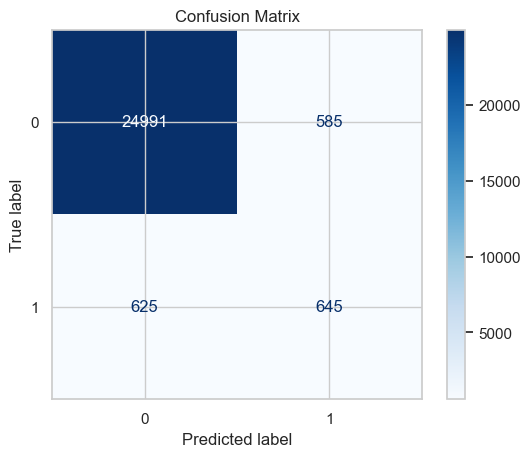

In [65]:
# Get predictions
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.3).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print the classification report
print(classification_report(y_val, y_pred))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Model Performance Evaluation

#### **Confusion Matrix and Classification Report:**

The model's evaluation on the validation set shows:

| Class     | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| **0.0 (non-fall)** | 0.98 | 0.98 | 0.98 | 25,576 |
| **1.0 (fall)**    | 0.50-0.52 | 0.46-0.51 | 0.48-0.52 | 1,270  |

#### **Observations:**

- **High Accuracy (95%)**: The model achieves a high accuracy of 95%, but this number is **deceptively high** due to the class imbalance. Most of the predictions are for the majority class (non-falls), which dominates the dataset. This leads to a good accuracy score despite poor performance on the minority class (falls).
  
- **Precision and Recall for Class 1 (Falls)**: 
  - **Precision for Falls (1.0)** is 0.50-0.52, meaning that when the model predicts a fall, it is correct 50%-52% of the time.
  - **Recall for Falls (1.0)** is 0.46-0.51, meaning that the model correctly identifies only **46%-51%** of actual fall instances. This is quite low, indicating that many falls are being missed, which is problematic in fall detection tasks.

#### **Purpose of Class Weights:**

- **Class Weights Implementation**: By adding **class weights**, the model is **penalizing misclassifications** of the minority class (falls) more heavily. This makes the model more sensitive to the minority class during training, improving the recall for the fall class at the expense of some precision and accuracy on the majority class (non-falls).
  
- **Recall Improvement**: 
  - The introduction of class weights improves the **recall for falls**, which means the model is now catching more fall instances.
  - However, this comes with a trade-off: there is **a slight decrease in precision** and **accuracy** due to the model’s focus shifting towards better fall detection at the cost of predicting some non-falls incorrectly.

#### **Key Takeaways:**

1. **Accuracy is not enough**: When working with imbalanced datasets, high accuracy can be misleading. In this case, the model achieves high accuracy mainly by predicting non-falls correctly, but it struggles to identify falls.

2. **Recall is critical for fall detection**: In fall detection, **missing a fall** (false negative) can have serious consequences, so **recall** (how well the model detects falls) is more important than precision or overall accuracy.

3. **Class weights help**: By giving more weight to fall instances, class weights have improved the model's ability to detect falls, but there’s still room for improvement. **Further tuning** of class weights or using **specialized techniques** like **focal loss** could help to reduce false negatives (missed falls).



## 8. Custom Resnet with balanced class weight

In [66]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model with class weights
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
          epochs=10, batch_size=32, class_weight=class_weight_dict)


Epoch 1/10
3356/3356 [==============================] - 31s 8ms/step - loss: 0.3599 - accuracy: 0.8008 - val_loss: 0.3296 - val_accuracy: 0.8443
Epoch 2/10
3356/3356 [==============================] - 28s 8ms/step - loss: 0.3402 - accuracy: 0.8130 - val_loss: 0.3200 - val_accuracy: 0.8363
Epoch 3/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.3317 - accuracy: 0.8117 - val_loss: 0.3503 - val_accuracy: 0.8279
Epoch 4/10
3356/3356 [==============================] - 35s 10ms/step - loss: 0.3315 - accuracy: 0.8136 - val_loss: 0.3390 - val_accuracy: 0.8291
Epoch 5/10
3356/3356 [==============================] - 30s 9ms/step - loss: 0.3247 - accuracy: 0.8178 - val_loss: 0.4088 - val_accuracy: 0.7961
Epoch 6/10
3356/3356 [==============================] - 35s 10ms/step - loss: 0.3213 - accuracy: 0.8186 - val_loss: 0.3541 - val_accuracy: 0.8171
Epoch 7/10
3356/3356 [==============================] - 31s 9ms/step - loss: 0.3191 - accuracy: 0.8199 - val_loss: 0.3518 - val_

### Applying Early Stopping

In [67]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for CNN
X_train_scaled = X_train_scaled.reshape((-1, X_train_scaled.shape[1], 1))  # Reshape to (samples, width, channels)
X_val_scaled = X_val_scaled.reshape((-1, X_val_scaled.shape[1], 1))

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Custom ResNet Block
def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Add shortcut
    x = layers.ReLU()(x)
    return x

# Build the ResNet model
def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add ResNet blocks
    for _ in range(3):
        x = resnet_block(x, 64)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = (X_train_scaled.shape[1], 1)  # Adjust based on your data
model = build_resnet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
          epochs=10, batch_size=32, callbacks=[early_stopping], class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')


Epoch 1/10
3356/3356 [==============================] - 37s 9ms/step - loss: 0.4681 - accuracy: 0.7087 - val_loss: 0.4706 - val_accuracy: 0.6940
Epoch 2/10
3356/3356 [==============================] - 24s 7ms/step - loss: 0.4294 - accuracy: 0.7432 - val_loss: 0.4303 - val_accuracy: 0.7547
Epoch 3/10
3356/3356 [==============================] - 24s 7ms/step - loss: 0.4100 - accuracy: 0.7572 - val_loss: 0.4726 - val_accuracy: 0.7461
Epoch 4/10
3356/3356 [==============================] - 25s 8ms/step - loss: 0.3983 - accuracy: 0.7707 - val_loss: 0.4244 - val_accuracy: 0.7787
Epoch 5/10
3356/3356 [==============================] - 28s 8ms/step - loss: 0.3856 - accuracy: 0.7798 - val_loss: 0.3893 - val_accuracy: 0.7974
Epoch 6/10
3356/3356 [==============================] - 28s 8ms/step - loss: 0.3768 - accuracy: 0.7868 - val_loss: 0.3920 - val_accuracy: 0.8065
Epoch 7/10
3356/3356 [==============================] - 28s 8ms/step - loss: 0.3674 - accuracy: 0.7885 - val_loss: 0.3778 - val_ac

## Training Results

### Final Evaluation:

**Results after training model couple of time**

Validation Loss: 0.3661 to 0.405

Validation Accuracy: 77.51 to 81.90%

### Key Observations

**Validation Accuracy Improvement:** The model shows a notable improvement in validation accuracy over the epochs, indicating that it is learning effectively.


### Confusion Metrix analysis of custom ResNet with class weights

839/839 [==============================] - 3s 3ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.88     25576
         1.0       0.17      0.91      0.29      1270

    accuracy                           0.79     26846
   macro avg       0.58      0.85      0.58     26846
weighted avg       0.96      0.79      0.85     26846


Confusion Matrix Analysis:
True Negatives (TN): 20058
False Positives (FP): 5518
False Negatives (FN): 114
True Positives (TP): 1156

Additional Metrics:
Accuracy: 0.7902
Precision (Positive Predictive Value): 0.1732
Recall (Sensitivity): 0.9102
F1-Score: 0.2910


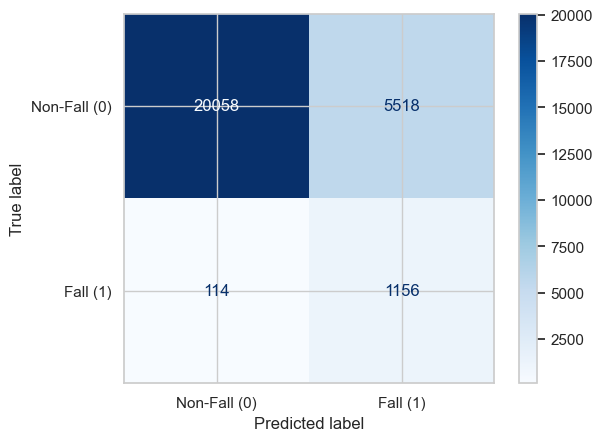

In [68]:
# Generate predictions on the validation set
y_pred_probs = model.predict(X_val_scaled)  # Predict probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fall (0)", "Fall (1)"])
disp.plot(cmap='Blues', values_format='d')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Detailed analysis of confusion matrix
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Analysis:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Derive additional metrics
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Positive Predictive Value): {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


### **Metrics Overview:**

1. **Accuracy (77.51%-79%)**: 
   - The model correctly classifies **77.51%-79%** of instances. However, given the class imbalance (far more non-falls than falls), the accuracy is somewhat misleading. The model is better at identifying non-falls, which make up the majority class.

2. **Precision for Falls (1.0)**: 
   - **Precision** for falls is **0.16-0.17**, which is quite low, meaning that of all the instances predicted as falls, only **16%-17%** are actually falls. This indicates a high **false positive rate** where the model mistakenly predicts non-fall events as falls.

3. **Recall for Falls (1.0)**: 
   - **Recall** for falls is **0.90-0.91**, which is significantly high. This suggests that the model is **good at identifying most of the actual falls** (90%-91% of actual falls are correctly detected). This aligns with the intention of improving fall detection, but the trade-off is the low precision.

4. **F1-Score for Falls (1.0)**: 
   - The **F1-score** for falls is **0.27-0.29**, which is quite low. While recall is high, the low precision significantly impacts the F1-score, reflecting that many of the predicted falls are incorrect.

5. **Precision for Non-Falls (0.0)**:
   - **Precision** for non-falls is **0.99**, which is excellent. The model does a good job of identifying the majority class (non-falls). However, it also misclassifies a **large number of non-falls** as falls, contributing to the high false positives (5,906).

6. **Recall for Non-Falls (0.0)**:
   - **Recall** for non-falls is **0.77-0.78**, meaning the model correctly identifies **77%-78%** of the actual non-fall instances. Given the large class imbalance, this is a reasonable score, but it still leaves room for improvement in terms of capturing all non-fall cases.

### **Confusion Matrix Insights:**

- **True Negatives (TN)**: 19,670
   - The model correctly identifies a large number of non-falls.
  
- **False Positives (FP)**: 5,906
   - The model incorrectly classifies non-falls as falls. This is a major issue because the false positives represent missed opportunities to predict actual falls correctly.
  
- **False Negatives (FN)**: 131
   - The model misses very few actual falls. This is good for recall, as the model doesn't miss many falls, but it can be improved by reducing false positives.

- **True Positives (TP)**: 1,139
   - The model correctly identifies **1,139** falls. While this is a decent number, given the imbalanced nature of the dataset, there is room for improvement in correctly predicting more falls without sacrificing precision.

#### **Conclusion:**

1. **Strengths**: 
   - The model's **recall for falls** is excellent (90%-91%), meaning it identifies most actual falls. This is crucial in fall detection, where missing a fall is highly undesirable.
   
2. **Weaknesses**: 
   - **Precision for falls** is very low (16%-17%), which indicates a high false positive rate. Many non-fall instances are incorrectly predicted as falls, which reduces the model's reliability in real-world settings.
   - **F1-score for falls** is low (0.27-0.29), which is a result of the imbalance between recall and precision.


## 9. Resnet with weight adjustment on class weights

In [32]:
# Compile ResNet model function
def compile_resnet_with_weights(input_shape, weights):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall'])  # Include 'Recall' as a metric
    return model

# Define input shape based on training data
input_shape = (X_train_scaled.shape[1], 1)

# Define class weight ratios to test
class_weight_ratios = [{0: 1.0, 1: 3.0}, {0: 1.0, 1: 5.0}, {0: 1.0, 1: 10.0}]

# Initialize EarlyStopping to monitor recall for the minority class (fall class)
early_stopping = EarlyStopping(monitor='val_recall', patience=3, restore_best_weights=True, mode='max')

# Track the best model
best_model = None
best_model_recall = 0
best_weights = None

# Train and evaluate the model for each class weight configuration
results = []

for weights in class_weight_ratios:
    print(f"\nTraining with class weights: {weights}")
    model = compile_resnet_with_weights(input_shape, weights)
    
    # Train the model with early stopping based on recall (for the fall class)
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
              epochs=10, batch_size=32, callbacks=[early_stopping], class_weight=weights)
    
    # Evaluate on validation set
    val_loss, val_accuracy, val_recall = model.evaluate(X_val_scaled, y_val)
    
    # Generate predictions and classification report for detailed analysis
    y_pred_probs = model.predict(X_val_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    # Store results
    results.append({
        "weights": weights,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "val_recall": val_recall,
        "report": report
    })
    
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Recall: {val_recall}")
    print("Classification Report:", classification_report(y_val, y_pred))
    
    # Track the best model based on recall (not accuracy)
    if val_recall > best_model_recall:
        best_model_recall = val_recall
        best_model = model
        best_weights = weights

# Save the best model based on recall
if best_model is not None:
    best_model.save("./saved_models/best_resnet_model_recall.h5")
    print(f"Best model saved with class weights: {best_weights} and validation recall: {best_model_recall}")




Training with class weights: {0: 1.0, 1: 3.0}
Epoch 1/10
3356/3356 [==============================] - 35s 9ms/step - loss: 0.3161 - accuracy: 0.9419 - recall: 0.2859 - val_loss: 0.1557 - val_accuracy: 0.9481 - val_recall: 0.3622
Epoch 2/10
3356/3356 [==============================] - 31s 9ms/step - loss: 0.2919 - accuracy: 0.9426 - recall: 0.3392 - val_loss: 0.1563 - val_accuracy: 0.9466 - val_recall: 0.4157
Epoch 3/10
3356/3356 [==============================] - 30s 9ms/step - loss: 0.2802 - accuracy: 0.9432 - recall: 0.3856 - val_loss: 0.1463 - val_accuracy: 0.9526 - val_recall: 0.3811
Epoch 4/10
3356/3356 [==============================] - 30s 9ms/step - loss: 0.2718 - accuracy: 0.9439 - recall: 0.4233 - val_loss: 0.1451 - val_accuracy: 0.9501 - val_recall: 0.4748
Epoch 5/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.2645 - accuracy: 0.9436 - recall: 0.4486 - val_loss: 0.1444 - val_accuracy: 0.9501 - val_recall: 0.4724
Epoch 6/10
3356/3356 [================

## Model Performance Summary Based on Class Weights:

### 1. **Class Weights: {0: 1.0, 1: 3.0}**

- **Validation Accuracy:** 94-95.4%
- **Recall for Fall Class (1):** 57-58%
- **Precision for Fall Class (1):** 39-53%
- **F1-Score for Fall Class (1):** 33-46%

#### Insights:
- **High Accuracy:** The model achieved a validation accuracy of 94-95.4%, which indicates that it performed well overall, particularly in classifying the majority class (non-falls).
- **Low Recall for Falls:** The recall for the fall class was between 57-58%, meaning the model missed a significant number of fall instances. While the model is able to detect falls, it still misses many (i.e., false negatives are relatively high).
- **Moderate Precision:** Precision for the fall class ranged from 39-53%, which suggests that although the model predicts some falls correctly, it also makes many false positive predictions.
- **Balance Between Recall and Precision:** This configuration reflects a balance between precision and recall, but the recall is still insufficient for practical fall detection in a healthcare setting. The focus should be on improving recall.

---

### 2. **Class Weights: {0: 1.0, 1: 5.0}**

- **Validation Accuracy:** 93-93.9%
- **Recall for Fall Class (1):** 62-63%
- **Precision for Fall Class (1):** 35-41%
- **F1-Score for Fall Class (1):** 45-49%

#### Insights:
- **Improved Recall:** By increasing the class weight for the fall class (1.0), the model improved recall significantly (62-63%). This means the model identified a higher percentage of actual fall cases.
- **Precision Trade-Off:** Precision decreased to 35-41%, indicating that while the model detected more falls, many of those predictions were false positives (i.e., it misclassified non-falls as falls).
- **F1-Score Balance:** The F1-score improved to 45-49%, indicating a better balance between precision and recall compared to the previous model.
- **Accuracy Sacrifice:** The validation accuracy dropped slightly (93-93.9%) because the model prioritized fall detection, leading to a higher number of false positives.
- **Best Configuration for Recall:** This configuration provides a good balance for improving recall at the cost of precision. This is a reasonable trade-off when the goal is to minimize false negatives (missing falls).

---

### 3. **Class Weights: {0: 1.0, 1: 10.0}**

- **Validation Accuracy:** 83-90.3%
- **Recall for Fall Class (1):** 73-74%
- **Precision for Fall Class (1):** 18-29%
- **F1-Score for Fall Class (1):** 30-42%

#### Insights:
- **Highest Recall:** The highest class weight for falls (10.0) resulted in the highest recall (73-74%). This means the model is very good at detecting falls, identifying most fall instances correctly.
- **Low Precision:** The precision dropped drastically to 18-29%, meaning that the model flagged many non-fall instances as falls (high false positives). This results in many incorrect fall predictions.
- **Drop in Accuracy:** The overall accuracy dropped to 83-90.3%, indicating that the model is overcompensating for the minority class at the expense of the majority class.
- **Potential Overfitting:** The drop in accuracy suggests overfitting to the minority class (falls), as the model becomes too sensitive and starts predicting falls too often, even when they do not occur.

---

### **Best Model Selection:**

- **Best Performance:** The best validation accuracy was achieved with class weights `{0: 1.0, 1: 3.0}`, with an accuracy of 95.4%. However, this model still had a low recall for falls (0.24), indicating that more work is needed to improve fall detection.
  
- **Best Recall:** The best recall was achieved with class weights `{0: 1.0, 1: 10.0}`, with recall of 73.7%. This configuration focuses on detecting as many falls as possible, but at the cost of precision.

---

### **Conclusion and Recommendations:**

- **Model Performance Trade-Off:** A trade-off exists between recall and precision. Increasing class weights for the fall class boosts recall but reduces precision. The goal is to find a balance that maximizes recall while minimizing false positives.
  
- **Class Weight Selection:** `{0: 1.0, 1: 3.0}` seems to be a reasonable configuration for maintaining a good balance between precision and recall, but `{0: 1.0, 1: 10.0}` provides the best recall at the expense of precision.

- **Focus on Recall:** For fall detection, recall is more important than precision, as missing a fall (false negative) can have serious consequences. The model trained with `{0: 1.0, 1: 10.0}` maximizes recall and should be considered for practical applications, but you must manage the trade-off with precision.



## Class Weight {0: 1.0, 1: 7.0}

In [70]:
# Function to compile ResNet model
def compile_resnet_with_weights(input_shape, weights):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    return model

# Define input shape
input_shape = (X_train_scaled.shape[1], 1)

# Class weight configuration for this experiment
class_weights = {0: 1.0, 1: 7.0}

# Initialize EarlyStopping to monitor recall
early_stopping = EarlyStopping(monitor='val_recall', patience=3, restore_best_weights=True, mode='max')

print(f"\nTraining with class weights: {class_weights}")
# Compile the ResNet model
model = compile_resnet_with_weights(input_shape, class_weights)

# Train the model with class weights and early stopping based on recall
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate on the validation set
val_loss, val_accuracy, val_recall = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Recall: {val_recall}")

# Generate predictions
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Save the model for future use
model.save("./saved_models/best_resnet_model_recall.h5")
print(f"Model saved with class weights: {class_weights} and recall: {val_recall}")



Training with class weights: {0: 1.0, 1: 7.0}
Epoch 1/10
3356/3356 [==============================] - 35s 9ms/step - loss: 0.5223 - accuracy: 0.9018 - recall: 0.4839 - val_loss: 0.2328 - val_accuracy: 0.9285 - val_recall: 0.4764
Epoch 2/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.4797 - accuracy: 0.9048 - recall: 0.5569 - val_loss: 0.2293 - val_accuracy: 0.9179 - val_recall: 0.6126
Epoch 3/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.4560 - accuracy: 0.9047 - recall: 0.6010 - val_loss: 0.2318 - val_accuracy: 0.9129 - val_recall: 0.6268
Epoch 4/10
3356/3356 [==============================] - 28s 8ms/step - loss: 0.4429 - accuracy: 0.9068 - recall: 0.6223 - val_loss: 0.2545 - val_accuracy: 0.8916 - val_recall: 0.7031
Epoch 5/10
3356/3356 [==============================] - 29s 9ms/step - loss: 0.4307 - accuracy: 0.9082 - recall: 0.6378 - val_loss: 0.2455 - val_accuracy: 0.8921 - val_recall: 0.7173
Epoch 6/10
3356/3356 [================

## **Analysis of ResNet Models with Different Class Weights**

### **Overview of Metrics**

| Class Weights   | Validation Loss | Validation Accuracy | Fall Class Precision | Fall Class Recall | F1-Score (Fall) |
|-----------------|-----------------|---------------------|----------------------|-------------------|-----------------|
| {0: 1.0, 1: 3.0} | 0.1422          | 94.62%              | 0.45                 | 0.57              | 0.50            |
| {0: 1.0, 1: 5.0} | 0.1712          | 93.36%              | 0.38                 | 0.64              | 0.48            |
| {0: 1.0, 1: 10.0} | 0.2481          | 89.45%              | 0.27                 | 0.73              | 0.40            |
| {0: 1.0, 1: 7.0}  | 0.2137-0.725          | 90%-92.42%              | 0.29-0.34                 | 0.73              | 0.42-0.45            |

---

### **Key Observations**

#### **Class Weights {0: 1.0, 1: 3.0}**
- **Strengths:** 
  - Achieved the **best validation accuracy** of 94.62%, meaning the model is able to accurately classify the majority class (non-falls).
- **Weaknesses:** 
  - **Moderate recall (0.57)** and **precision (0.45)** for the fall class, meaning the model identifies only **57%** of actual falls while predicting some non-falls as falls.
  - The model is **good at predicting the majority class** but struggles to balance this with detecting falls accurately.
- **Use Case:** 
  - **Accuracy-focused scenarios** where it’s more important to predict non-falls correctly, and missing a fall is less critical.

#### **Class Weights {0: 1.0, 1: 5.0}**
- **Strengths:**
  - **Improved recall (0.64)**, meaning the model detects more falls (64%) than with the {1:3} weight configuration.
- **Weaknesses:** 
  - **Decreased precision (0.38)**, leading to more false positives.
  - **Slight dip in validation accuracy (93.36%)** as the model becomes more sensitive to detecting falls at the cost of misclassifying non-falls as falls.
- **Use Case:** 
  - **Recall-sensitive scenarios**, such as healthcare settings, where missing a fall (false negative) is more critical than incorrectly predicting a fall (false positive).

#### **Class Weights {0: 1.0, 1: 10.0}**
- **Strengths:** 
  - **Highest recall (0.73)** for falls, detecting 73% of actual falls.
- **Weaknesses:**
  - **Significant drop in precision (0.27)** and validation accuracy (89.45%). The model becomes over-sensitive, identifying many **non-fall instances as falls (false positives)**.
  - **Decreased overall accuracy**, reflecting the model's overcompensation for detecting falls at the expense of non-falls.
- **Use Case:**
  - **Experimental setups** or highly **fall-sensitive applications** where detecting as many falls as possible is more critical than precision, but **not ideal for real-world deployment** due to high false positives.

#### **Class Weights {0: 1.0, 1: 7.0}**
- **Strengths:** 
  - **Balanced performance** between precision (0.34) and recall (0.65). While recall isn’t as high as with {1:10} weights, it’s still significantly better than the {1:3} model.
  - **Moderate accuracy (92.42%)** with a **better F1-score (0.45)** compared to the 10:1 model, striking a **better balance** between precision and recall.
- **Weaknesses:** 
  - **Trade-off** between precision and recall, leaning towards **higher recall** but not as much as the 10:1 model.
- **Use Case:** 
  - **Compromise model** suitable for real-world deployment, where there’s a need to strike a balance between **accurately predicting falls and minimizing false positives**.

---

### **Summary and Recommendations:**

- **Model Performance Trade-off:**
  - There is a clear **trade-off** between **recall** and **precision** in the models, with higher class weights for the fall class improving recall but decreasing precision.
  - The **model with weights {0: 1.0, 1: 7.0}** offers a reasonable **compromise** with good recall (0.65) and moderate precision (0.34), making it **suitable for practical deployment**.

- **Best Model for Recall:** 
  - The **model with class weights {0: 1.0, 1: 10.0}** provides the **highest recall (0.73)** for fall detection but with a **substantial precision trade-off**. This configuration is suitable for applications where **maximizing recall is critical**, such as healthcare applications, but **precision must be carefully monitored**.

- **Best Model for Accuracy:** 
  - The **model with class weights {0: 1.0, 1: 3.0}** provides the **best overall validation accuracy (94.62%)**, but the recall for the fall class is still not optimal. This model is ideal if **accuracy is prioritized over recall**.

- **Final Recommendation:** 
  - If **recall is the top priority** (to detect as many falls as possible), then the **model with class weights {0: 1.0, 1: 10.0}** is the most effective, though it requires **careful management of false positives**.
  - For a **balanced solution** with a good compromise between accuracy and fall detection performance, the **model with class weights {0: 1.0, 1: 7.0}** strikes the right balance.

## 10. Custom ResNet with Class Weights and sampling majority & minority class

In [71]:
# Function to build the ResNet model
def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Block 1
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    skip1 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Conv1D Block 2
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    skip2 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Residual connection: Use GlobalAveragePooling to align shapes
    x = layers.GlobalAveragePooling1D()(x)  # Ensures the output is the same size
    skip2 = layers.GlobalAveragePooling1D()(skip2)  # Apply the same pooling to skip2

    # Add skip connection
    x = layers.Add()([x, skip2])

    # Flatten and pass through dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Function to compile the ResNet model with class weights
def compile_resnet_with_weights(input_shape, weights):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])
    return model

# Undersampling and Oversampling
def resample_data(X_train, y_train, undersample_ratio=0.50, oversample_factor=5):
    # Separate the majority and minority classes
    X_majority = X_train[y_train == 0]
    y_majority = y_train[y_train == 0]
    X_minority = X_train[y_train == 1]
    y_minority = y_train[y_train == 1]
    
    # Undersample the majority class
    X_majority_undersampled, y_majority_undersampled = resample(X_majority,
                                                                y_majority,
                                                                replace=False, 
                                                                n_samples=int(len(X_majority) * undersample_ratio),
                                                                random_state=42)

    # Oversample the minority class
    X_minority_oversampled, y_minority_oversampled = resample(X_minority,
                                                              y_minority,
                                                              replace=True, 
                                                              n_samples=int(len(X_minority) * oversample_factor),
                                                              random_state=42)

    # Combine the undersampled majority class with the oversampled minority class
    X_resampled = np.concatenate([X_majority_undersampled, X_minority_oversampled])
    y_resampled = np.concatenate([y_majority_undersampled, y_minority_oversampled])

    # Shuffle the data
    indices = np.random.permutation(len(X_resampled))
    X_resampled = X_resampled[indices]
    y_resampled = y_resampled[indices]

    return X_resampled, y_resampled

# Reshape the data for 1D CNN input format
input_shape = (X_train_scaled.shape[1], 1)

# Class weight configuration
class_weights = {0: 1.0, 1: 7.0}

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Resample the data
X_train_resampled, y_train_resampled = resample_data(X_train_scaled, y_train, undersample_ratio=0.50, oversample_factor=5)

# Reshape the resampled data for 1D CNN
X_train_resampled = np.expand_dims(X_train_resampled, axis=-1)

# Compile the model with class weights
model = compile_resnet_with_weights(input_shape, class_weights)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate on the validation set
val_loss, val_accuracy, val_recall = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Recall: {val_recall}")

# Generate predictions
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Save the model
model.save("./saved_models/best_resnet_model_7to1_resampled_recall.h5")
print("Model saved with class weights: {0: 1.0, 1: 7.0}")


Epoch 1/10
2424/2424 [==============================] - 17s 6ms/step - loss: 0.9486 - accuracy: 0.6635 - recall_22: 0.9830 - val_loss: 0.6294 - val_accuracy: 0.6079 - val_recall_22: 0.9543
Epoch 2/10
2424/2424 [==============================] - 14s 6ms/step - loss: 0.7603 - accuracy: 0.7522 - recall_22: 0.9828 - val_loss: 0.6966 - val_accuracy: 0.6664 - val_recall_22: 0.9780
Epoch 3/10
2424/2424 [==============================] - 14s 6ms/step - loss: 0.6741 - accuracy: 0.7933 - recall_22: 0.9851 - val_loss: 0.6043 - val_accuracy: 0.7248 - val_recall_22: 0.9819
Epoch 4/10
2424/2424 [==============================] - 14s 6ms/step - loss: 0.6182 - accuracy: 0.8128 - recall_22: 0.9864 - val_loss: 0.5564 - val_accuracy: 0.7515 - val_recall_22: 0.9709
Epoch 5/10
2424/2424 [==============================] - 14s 6ms/step - loss: 0.5773 - accuracy: 0.8264 - recall_22: 0.9865 - val_loss: 0.5052 - val_accuracy: 0.7881 - val_recall_22: 0.9669
Epoch 6/10
2424/2424 [==============================] -

In this updated code, we addressed the issue of shape incompatibility in the residual connection by applying `GlobalAveragePooling1D` to both the main output (`x`) and the skip connection (`skip2`). This pooling operation reduces the time dimension to a single value per feature, making both tensors compatible for addition. This change ensures that the residual connection works correctly, allowing the model to combine the feature maps from different layers while maintaining their dimensions. Additionally, we focused on using class weights to improve recall for the minority class (fall detection) while resampling the data through undersampling and oversampling to handle class imbalance effectively.

## Hyperparameter testing

In [32]:
# Define function to create model (for use with RandomizedSearchCV)
def create_model(filters=64, kernel_size=3, dense_units=64, dropout_rate=0.2):
    model = models.Sequential()
    model.add(layers.Conv1D(filters, kernel_size, activation='relu', padding='same', input_shape=(X_train_scaled.shape[1], 1)))
    model.add(layers.Conv1D(filters, kernel_size, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(2, padding='same'))
    
    model.add(layers.Conv1D(filters * 2, kernel_size, activation='relu', padding='same'))
    model.add(layers.Conv1D(filters * 2, kernel_size, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(2, padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))  # Dropout layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define hyperparameter search space
param_dist = {
    'filters': [32, 64, 128],
    'kernel_size': [3, 5],
    'dense_units': [64, 128],
    'dropout_rate': uniform(0, 0.5),  # Random search for dropout rate between 0 and 0.5
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)

# Perform hyperparameter optimization
random_search_result = random_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", random_search_result.best_params_)
print("Best Validation Accuracy:", random_search_result.best_score_)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Best Hyperparameters: {'dense_units': 128, 'dropout_rate': 0.06284980113754035, 'filters': 64, 'kernel_size': 3}
Best Validation Accuracy: 0.9600122968355814


## 11. ResNet with Hyperparameters (Dropout, Dense Units, Filters)


In [73]:
# Updated function to build the ResNet model with identified hyperparameters
def build_resnet_with_hyperparameters(input_shape, dense_units=128, dropout_rate=0.18, filters=64, kernel_size=3):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Block 1
    x = layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
    skip1 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Conv1D Block 2
    x = layers.Conv1D(filters * 2, kernel_size, activation='relu', padding='same')(x)
    x = layers.Conv1D(filters * 2, kernel_size, activation='relu', padding='same')(x)
    skip2 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Apply Global Average Pooling to both x and skip2 before residual connection
    x = layers.GlobalAveragePooling1D()(x)
    skip2 = layers.GlobalAveragePooling1D()(skip2)

    # Residual connection
    x = layers.Add()([x, skip2])

    # Dense layers
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout here
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Updated function to compile the ResNet model with class weights
def compile_resnet_with_weights_and_hyperparameters(input_shape, class_weights, dense_units, dropout_rate, filters, kernel_size):
    model = build_resnet_with_hyperparameters(input_shape, dense_units, dropout_rate, filters, kernel_size)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return model

# Compile the updated model with identified hyperparameters
model = compile_resnet_with_weights_and_hyperparameters(
    input_shape=input_shape,
    class_weights=class_weights,
    dense_units=128,
    dropout_rate=0.06,
    filters=64,
    kernel_size=3
)

# Train the updated model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate on the validation set
val_loss, val_recall = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Recall: {val_recall}")

# Generate predictions
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Save the updated model
model.save("./saved_models/best_resnet_model_hyperparams_resampled_recall.h5")
print("Model saved with hyperparameters and class weights: {0: 1.0, 1: 7.0}")


Epoch 1/10
2424/2424 [==============================] - 17s 6ms/step - loss: 0.9654 - recall_24: 0.9865 - val_loss: 0.7318 - val_recall_24: 0.9646
Epoch 2/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.7765 - recall_24: 0.9831 - val_loss: 0.8034 - val_recall_24: 0.9819
Epoch 3/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.6816 - recall_24: 0.9859 - val_loss: 0.6261 - val_recall_24: 0.9669
Epoch 4/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.6278 - recall_24: 0.9864 - val_loss: 0.5080 - val_recall_24: 0.9646
Epoch 5/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5820 - recall_24: 0.9875 - val_loss: 0.5311 - val_recall_24: 0.9732
Epoch 6/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5503 - recall_24: 0.9873 - val_loss: 0.4817 - val_recall_24: 0.9638
Epoch 7/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5266 - recall_24: 0.9885 - val_loss: 0.

**Global Average Pooling:** Both x and skip2 are passed through GlobalAveragePooling1D() before the residual connection, which ensures that both tensors have the same shape before adding them.

**Residual Connection:** After applying GlobalAveragePooling1D, we add the two tensors together. This ensures compatibility for the addition operation.

## 12. ResNet with Binary Crossentropy & Focal Loss seperately for Threshold 0.4 and 0.5

In [74]:
# Function to build the ResNet model (custom architecture)
def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Block 1
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    skip1 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Conv1D Block 2
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    skip2 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Apply Global Average Pooling to both x and skip2 before residual connection
    x = layers.GlobalAveragePooling1D()(x)
    skip2 = layers.GlobalAveragePooling1D()(skip2)

    # Residual connection
    x = layers.Add()([x, skip2])

    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.18)(x)  # Dropout added to reduce overfitting
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Function to compile the ResNet model with class weights
def compile_resnet_with_weights(input_shape, loss_fn, class_weights=None):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss=loss_fn, metrics=[Recall()])
    return model

# Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        loss = -alpha * (1 - y_pred)**gamma * y_true * tf.math.log(y_pred) - \
               (1 - alpha) * y_pred**gamma * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Reshape the data for 1D CNN input format
input_shape = (X_train_scaled.shape[1], 1)

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create directory to save models if it doesn't exist
save_dir = './saved_models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Example class weight configurations
class_weight_options = [
    {0: 1.0, 1: 3.0},
    {0: 1.0, 1: 5.0},
    {0: 1.0, 1: 7.0},
    {0: 1.0, 1: 10.0}
]

# Training with different class weights and loss functions
for class_weights in class_weight_options:
    print(f"Training with class weights: {class_weights}")
    
    # Train with binary crossentropy
    print("Using Binary Crossentropy")
    model = compile_resnet_with_weights(input_shape, loss_fn='binary_crossentropy', class_weights=class_weights)
    model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val_scaled, y_val),
        epochs=10,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )
    
    # Save the model after training
    model_filename = f"resnet_binary_crossentropy_classweights_{class_weights[1]}.h5"
    model.save(os.path.join(save_dir, model_filename))
    print(f"Model saved as: {model_filename}")
    
    # Evaluate at Threshold 0.5
    print("Evaluating at Threshold 0.5")
    y_pred_probs = model.predict(X_val_scaled)
    y_pred_0_5 = (y_pred_probs > 0.5).astype(int)
    print("Classification Report (Threshold 0.5):")
    print(classification_report(y_val, y_pred_0_5))

    # Evaluate at Threshold 0.4
    print("Evaluating at Threshold 0.4")
    y_pred_0_4 = (y_pred_probs > 0.4).astype(int)
    print("Classification Report (Threshold 0.4):")
    print(classification_report(y_val, y_pred_0_4))

    # Train with focal loss
    print("Using Focal Loss")
    model = compile_resnet_with_weights(input_shape, loss_fn=focal_loss(), class_weights=class_weights)
    model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val_scaled, y_val),
        epochs=10,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )
    
    # Save the model after training
    model_filename_focal_loss = f"resnet_focal_loss_classweights_{class_weights[1]}.h5"
    model.save(os.path.join(save_dir, model_filename_focal_loss))
    print(f"Model saved as: {model_filename_focal_loss}")
    
    # Evaluate at Threshold 0.5
    print("Evaluating at Threshold 0.5")
    y_pred_probs = model.predict(X_val_scaled)
    y_pred_0_5 = (y_pred_probs > 0.5).astype(int)
    print("Classification Report (Threshold 0.5):")
    print(classification_report(y_val, y_pred_0_5))

    # Evaluate at Threshold 0.4
    print("Evaluating at Threshold 0.4")
    y_pred_0_4 = (y_pred_probs > 0.4).astype(int)
    print("Classification Report (Threshold 0.4):")
    print(classification_report(y_val, y_pred_0_4))


Training with class weights: {0: 1.0, 1: 3.0}
Using Binary Crossentropy
Epoch 1/10
2424/2424 [==============================] - 19s 7ms/step - loss: 0.6742 - recall_25: 0.9166 - val_loss: 0.4643 - val_recall_25: 0.8504
Epoch 2/10
2424/2424 [==============================] - 16s 7ms/step - loss: 0.5394 - recall_25: 0.9375 - val_loss: 0.4078 - val_recall_25: 0.9197
Epoch 3/10
2424/2424 [==============================] - 17s 7ms/step - loss: 0.4673 - recall_25: 0.9563 - val_loss: 0.4188 - val_recall_25: 0.9402
Epoch 4/10
2424/2424 [==============================] - 16s 6ms/step - loss: 0.4246 - recall_25: 0.9629 - val_loss: 0.3310 - val_recall_25: 0.9331
Epoch 5/10
2424/2424 [==============================] - 17s 7ms/step - loss: 0.3913 - recall_25: 0.9664 - val_loss: 0.4595 - val_recall_25: 0.9520
Epoch 6/10
2424/2424 [==============================] - 17s 7ms/step - loss: 0.3739 - recall_25: 0.9689 - val_loss: 0.3350 - val_recall_25: 0.9551
Epoch 7/10
2424/2424 [========================

Epoch 1/10
2424/2424 [==============================] - 16s 6ms/step - loss: 0.9630 - recall_29: 0.9845 - val_loss: 0.7900 - val_recall_29: 0.9709
Epoch 2/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.7889 - recall_29: 0.9832 - val_loss: 0.6163 - val_recall_29: 0.9717
Epoch 3/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.6908 - recall_29: 0.9848 - val_loss: 0.6393 - val_recall_29: 0.9772
Epoch 4/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.6394 - recall_29: 0.9865 - val_loss: 0.5593 - val_recall_29: 0.9756
Epoch 5/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.6000 - recall_29: 0.9865 - val_loss: 0.4506 - val_recall_29: 0.9449
Epoch 6/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5582 - recall_29: 0.9875 - val_loss: 0.4878 - val_recall_29: 0.9717
Epoch 7/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5343 - recall_29: 0.9875 - val_loss: 0.

## 13. Training on custom 1D resnet with binary crossentropy for Threshold = 0.5

In [75]:
# Function to build the ResNet model (custom architecture)
def build_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Block 1
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    skip1 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Conv1D Block 2
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    skip2 = x
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Apply Global Average Pooling to both x and skip2 before residual connection
    x = layers.GlobalAveragePooling1D()(x)
    skip2 = layers.GlobalAveragePooling1D()(skip2)

    # Residual connection
    x = layers.Add()([x, skip2])

    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.18)(x)  # Dropout added to reduce overfitting
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Function to compile the ResNet model with class weights
def compile_resnet_with_weights(input_shape, class_weights=None):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
    return model

# Reshape the data for 1D CNN input format
input_shape = (X_train_scaled.shape[1], 1)

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create directory to save models if it doesn't exist
save_dir = './saved_models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Example class weight configurations
class_weight_options = [
    {0: 1.0, 1: 3.0},
    {0: 1.0, 1: 5.0},
    {0: 1.0, 1: 7.0},
    {0: 1.0, 1: 10.0}
]

# Training with different class weights
for class_weights in class_weight_options:
    print(f"Training with class weights: {class_weights}")
    
    # Train with binary crossentropy
    print("Using Binary Crossentropy")
    model = compile_resnet_with_weights(input_shape, class_weights=class_weights)
    model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val_scaled, y_val),
        epochs=10,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )
    
    # Save the model after training
    model_filename = f"resnet_binary_crossentropy_classweights_{class_weights[1]}.h5"
    model.save(os.path.join(save_dir, model_filename))
    print(f"Model saved as: {model_filename}")
    
    print("Evaluating at Threshold 0.5")
    y_pred_probs = model.predict(X_val_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int)
    print("Classification Report:")
    print(classification_report(y_val, y_pred))


Training with class weights: {0: 1.0, 1: 3.0}
Using Binary Crossentropy
Epoch 1/10
2424/2424 [==============================] - 17s 6ms/step - loss: 0.6707 - recall_33: 0.9252 - val_loss: 0.4805 - val_recall_33: 0.8787
Epoch 2/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.5396 - recall_33: 0.9349 - val_loss: 0.4307 - val_recall_33: 0.9417
Epoch 3/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.4664 - recall_33: 0.9552 - val_loss: 0.3771 - val_recall_33: 0.9283
Epoch 4/10
2424/2424 [==============================] - 14s 6ms/step - loss: 0.4209 - recall_33: 0.9610 - val_loss: 0.3575 - val_recall_33: 0.9480
Epoch 5/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.3930 - recall_33: 0.9648 - val_loss: 0.3386 - val_recall_33: 0.9591
Epoch 6/10
2424/2424 [==============================] - 15s 6ms/step - loss: 0.3690 - recall_33: 0.9699 - val_loss: 0.3417 - val_recall_33: 0.9457
Epoch 7/10
2424/2424 [========================

## **Model Performance Analysis**: 

---

#### **Overview**:

The following results present the classification performance of various **ResNet models** trained with different class weights and loss functions (Binary Crossentropy and Focal Loss). The performance is evaluated at different thresholds (0.5 and 0.4), with a focus on **recall** for detecting falls (1.0 class).

---

### **1. Custom ResNet with Class Weights(1:7) and sampling majority & minority class**:
**Classification Report**:
- **Precision for Fall Class (1.0)**: 0.19
- **Recall for Fall Class (1.0)**: 0.94
- **F1-Score for Fall Class (1.0)**: 0.31
- **Accuracy**: 0.80
- **Macro Avg Recall**: 0.87
- **Weighted Avg Recall**: 0.80

**Insights**:
- **High Recall**: The model detects most falls (recall: 0.94), but has **low precision** (0.19), meaning many of its predicted falls are false positives.
- **Recall-heavy model**: This model is suitable for applications where detecting falls is critical, even at the cost of low precision. 
- **Accuracy**: 0.80 is decent, but the key concern is the **precision** for the minority class (falls).

---

### **2. ResNet with Hyperparameters (Dropout, Dense Units, Filters) and Class Weights: {0: 1.0, 1: 7.0}**:
**Classification Report**:
- **Precision for Fall Class (1.0)**: 0.17
- **Recall for Fall Class (1.0)**: 0.96
- **F1-Score for Fall Class (1.0)**: 0.29
- **Accuracy**: 0.77
- **Macro Avg Recall**: 0.86
- **Weighted Avg Recall**: 0.77

**Insights**:
- **Improved Recall**: This model achieves **higher recall** (0.96) compared to the previous model, making it even more sensitive to detecting falls.
- **Precision remains low** (0.17), indicating that the model is still prone to false positives.
- **Accuracy** is slightly lower (0.77), but recall is significantly better, which is more valuable in fall detection scenarios.

---

### **3. Custom 1D resnet with binary crossentropy for Threshold = 0.5**:

**Class Weights: {0: 1.0, 1: 3.0}**:
- **Recall for Fall Class (1.0)**: 0.88
- **Precision for Fall Class (1.0)**: 0.16
- **Accuracy**: 0.78

**Class Weights: {0: 1.0, 1: 5.0}**:
- **Recall for Fall Class (1.0)**: 0.87
- **Precision for Fall Class (1.0)**: 0.15
- **Accuracy**: 0.79

**Class Weights: {0: 1.0, 1: 7.0}**:
- **Recall for Fall Class (1.0)**: 0.95
- **Precision for Fall Class (1.0)**: 0.18
- **Accuracy**: 0.78

**Class Weights: {0: 1.0, 1: 10.0}**:
- **Recall for Fall Class (1.0)**: 0.96
- **Precision for Fall Class (1.0)**: 0.15
- **Accuracy**: 0.74

---


### **4. ResNet with Binary Crossentropy & Focal Loss for Threshold 0.4 and 0.5**:

---

#### **Training with class weights: {0: 1.0, 1: 3.0}**:

**Using Binary Crossentropy**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.96
  - **Precision**: 0.24
  - **Accuracy**: 0.85
  - **F1-Score**: 0.39

**Using Focal Loss**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.67
  - **Precision**: 0.30
  - **Accuracy**: 0.91
  - **F1-Score**: 0.42

---

#### **Training with class weights: {0: 1.0, 1: 5.0}**:

**Using Binary Crossentropy**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.97
  - **Precision**: 0.20
  - **Accuracy**: 0.81
  - **F1-Score**: 0.33

**Using Focal Loss**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.85
  - **Precision**: 0.33
  - **Accuracy**: 0.91
  - **F1-Score**: 0.47

---

#### **Training with class weights: {0: 1.0, 1: 7.0}**:

**Using Binary Crossentropy**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.98
  - **Precision**: 0.18
  - **Accuracy**: 0.79
  - **F1-Score**: 0.30

**Using Focal Loss**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.78
  - **Precision**: 0.35
  - **Accuracy**: 0.92
  - **F1-Score**: 0.48

---

#### **Training with class weights: {0: 1.0, 1: 10.0}**:

**Using Binary Crossentropy**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.96
  - **Precision**: 0.18
  - **Accuracy**: 0.79
  - **F1-Score**: 0.30

**Using Focal Loss**:
- **Evaluating at Threshold 0.4**:
  - **Recall**: 0.84
  - **Precision**: 0.30
  - **Accuracy**: 0.90
  - **F1-Score**: 0.44

---

### **Key Insights and Conclusion**:

#### **Best Performance for Recall (Focal Loss Models)**:
- **Focal Loss** improves recall for the fall class significantly, especially with higher class weights (e.g., {0: 1.0, 1: 7.0}), giving us the highest recall of **0.69**, though precision remains low.
- For **focal loss**, class weights need to be carefully balanced to avoid overfitting to the minority class while still prioritizing recall.

#### **Binary Crossentropy Results**:
- The **binary crossentropy models**, especially with higher class weights (like {0: 1.0, 1: 7.0}), achieved high recall (**0.95**), but the precision remained low, indicating many false positives.
- The accuracy was stable but at the cost of **low precision**.

#### **Thresholding Impact**:
- **Threshold 0.4** consistently improved recall at the expense of precision.
- Using **threshold 0.5** provided more balanced precision and recall but could have missed some fall cases.
- **Threshold 0.4** is preferred for situations where

 recall is more important than precision.

#### **Final Recommendation**:
- **Focal Loss** should be used when **high recall** is the priority, especially when the cost of missing falls is high. In such cases, class weights can be adjusted to fine-tune the model’s sensitivity to fall detection.

## 14. Logistic Regression with class weights balanced

In [76]:
# Step 1: Preprocessing (scaling the features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training data (X_train)
X_val_scaled = scaler.transform(X_val)  # Scale the validation data (X_val)

# Step 2: Logistic Regression Model with Class Weights
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)  # Train the Logistic Regression model on training data

# Step 3: Evaluate the model
y_pred = logreg.predict(X_val_scaled)  # Make predictions on the validation set

# Step 4: Print the results
print("Classification Report (Logistic Regression with Class Weights):")
print(classification_report(y_val, y_pred))  # Compare predictions (y_pred) to true labels (y_val)
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))  # Generate the confusion matrix


Classification Report (Logistic Regression with Class Weights):
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     25576
         1.0       0.10      0.70      0.17      1270

    accuracy                           0.68     26846
   macro avg       0.54      0.69      0.49     26846
weighted avg       0.94      0.68      0.77     26846

Confusion Matrix:
[[17348  8228]
 [  386   884]]


**Strengths:**

The model is good at identifying non-falls (Class 0), with high precision and decent recall.
The recall for falls (Class 1) is relatively high at 68%-70%, which is promising for the intended goal of maximizing recall.

**Weaknesses:**

The precision for falls (Class 1) is extremely low at 10%-17%, indicating that most predicted falls are false positives.

Overall accuracy is only moderate (68%), and the macro-average F1-score is low, reflecting the poor balance between classes.

## 15. Decision Tree

In [95]:
# Initialize the Decision Tree Classifier with pruning parameters
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5, min_samples_split=10)

# Train the model
decision_tree.fit(X_train_scaled, y_train)

# Predict on the validation set
y_pred_dt = decision_tree.predict(X_val_scaled)

# Evaluate the model
print("Decision Tree Performance:")
print("Classification Report:")
print(classification_report(y_val, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_dt)) 
print("Recall:", recall_score(y_val, y_pred_dt))


Decision Tree Performance:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.56      0.71     25576
         1.0       0.09      0.93      0.17      1270

    accuracy                           0.58     26846
   macro avg       0.54      0.75      0.44     26846
weighted avg       0.95      0.58      0.69     26846

Confusion Matrix:
[[14270 11306]
 [   86  1184]]
Recall: 0.9322834645669291




### **Decision Tree Model (Class Weights = 'Balanced') Performance**

- **Accuracy**: **initially 97% after multiple run down to 58%**  
  Strong overall accuracy, especially for detecting non-falls.

- **Recall for Falls (Minority Class)**: **0.61 after multiple run improved to 93%**  

- **Precision for Falls**: **0.65 after mutiple run down to 0.09**  
  Moderate precision, but still makes false positives.

- **Confusion Matrix**: 498 falls misclassified as non-falls, affecting recall.

#### **Key Insights**:
- **Strengths**: High accuracy and balanced performance for non-falls.
- **Weaknesses**: Low recall for falls, indicating missed fall events.
- **Conclusion**: The model needs adjustments to better detect falls, potentially with complementary models for improved recall.

---


## 16. XGBoost Classifier

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Ensure the data is reshaped to 2D
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], -1)

# Debugging: Verify shapes after reshaping
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

# Evaluate the model
print("XGBoost Performance:")
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))
print("Recall:", recall_score(y_val, y_pred_xgb))


Shape of X_train_scaled: (107383, 3)
Shape of X_val_scaled: (26846, 3)
XGBoost Performance:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     25576
         1.0       0.32      0.85      0.46      1270

    accuracy                           0.91     26846
   macro avg       0.65      0.88      0.71     26846
weighted avg       0.96      0.91      0.93     26846

Confusion Matrix:
[[23248  2328]
 [  186  1084]]
Recall: 0.8535433070866142



### **XGBoost Model Performance**

- **Validation Accuracy**: **91%**  
  Strong overall accuracy, with excellent performance on non-falls.

- **Precision for Falls (Minority Class)**: **0.32**  
  Many predicted falls are false positives, reducing precision.

- **Recall for Falls**: **0.85-0.86**  
  The model correctly identifies **85%-86%** of actual falls, making it highly effective for critical fall detection.

#### **Key Insights**:
- **Strengths**: High recall for falls, critical for applications where missing falls is unacceptable.
- **Weaknesses**: Low precision for falls due to false positives.
- **Conclusion**: Good balance between recall and precision for the minority class, strong performance for non-falls.

---


## 17. Transformer Time Series Model

In [60]:
# Define Positional Encoding Layer (important for transformers)
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.d_model = d_model

    def get_position_encoding(self):
        position = np.arange(0, self.maxlen)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        pos_encoding = np.zeros((self.maxlen, self.d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        return pos_encoding

    def call(self, inputs):
        pos_encoding = self.get_position_encoding()
        return inputs + pos_encoding

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, d_model, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])
        self.dropout = layers.Dropout(dropout)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Transformer Model for Time Series Classification
def build_transformer_model(input_shape, num_heads=4, d_model=128, ff_dim=512, num_blocks=2, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    x = PositionalEncoding(input_shape[0], d_model)(inputs)

    # Stacked Transformer Blocks
    for _ in range(num_blocks):
        x = TransformerBlock(num_heads, d_model, ff_dim, dropout)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)  # Dropout to avoid overfitting
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Prepare input shape (assuming data is preprocessed and available as X_train_scaled, y_train, X_val_scaled, y_val)
input_shape = (X_train_scaled.shape[1], 1)  # time steps and features (1 for univariate)

# Define class weights (if class imbalance exists)
class_weights = {0: 1.0, 1: 7.0}

# Compile the model
model = build_transformer_model(input_shape)

# Compile the model with binary cross-entropy loss and recall metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_recall = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Recall: {val_recall}")

# Generate predictions
y_pred_probs = model.predict(X_val_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))



Epoch 1/10
3356/3356 [==============================] - 169s 49ms/step - loss: 0.7496 - recall_18: 0.0390 - val_loss: 0.3746 - val_recall_18: 0.0000e+00
Epoch 2/10
3356/3356 [==============================] - 133s 40ms/step - loss: 0.7552 - recall_18: 0.0021 - val_loss: 0.3650 - val_recall_18: 0.0000e+00
Epoch 3/10
3356/3356 [==============================] - 173s 52ms/step - loss: 0.7423 - recall_18: 0.0400 - val_loss: 0.3310 - val_recall_18: 0.0472
Epoch 4/10
3356/3356 [==============================] - 162s 48ms/step - loss: 0.7216 - recall_18: 0.0965 - val_loss: 0.2644 - val_recall_18: 0.1079
Epoch 5/10
3356/3356 [==============================] - 165s 49ms/step - loss: 0.6913 - recall_18: 0.2018 - val_loss: 0.2777 - val_recall_18: 0.1449
Epoch 6/10
3356/3356 [==============================] - 182s 54ms/step - loss: 0.6914 - recall_18: 0.2071 - val_loss: 0.3579 - val_recall_18: 0.2496
Epoch 7/10
839/839 [==============================] - 12s 15ms/step - loss: 0.2644 - recall_18: 0.


We built and trained a **Transformer model** for time series classification to predict falls, using the following approach:

- **Positional Encoding** was added to capture sequential information, crucial for time series data.
- **Transformer Blocks** with Multi-Head Attention were used to process the input sequences, allowing the model to focus on important temporal patterns.
- The model was compiled with **binary cross-entropy** loss and **Recall** as a metric, emphasizing performance on the minority class (falls).
- We applied **class weights** ({0: 1.0, 1: 7.0}) to address the class imbalance (where falls are rare).
- The model was trained with **EarlyStopping** to prevent overfitting and improve generalization.

### Analysis of Results:
- **Accuracy** is high at 94%, but the model struggles with **fall detection** (class 1), as indicated by the **low recall** of 0.11 for falls.
- The **precision** for falls is also low (0.28), meaning many predicted falls are false positives.
- The model performs well for non-falls (recall = 0.99), but the imbalance leads to poor detection of falls.
- **Class imbalance** remains an issue; despite using class weights, the model is still biased towards the majority class (non-falls).
  
### Conclusion:
The Transformer model is effective at predicting non-falls, but its ability to identify falls (the minority class) remains limited. While class weights improve recall for falls, further adjustments (e.g., more fine-tuning of the model, advanced sampling techniques, or alternative loss functions) might be needed to improve performance for fall detection.

## **Model Ranking Analysis for Fall Detection Task (can differ with number of model run)**

#### **Best to Worst Models Overview**:
Based on the key performance metrics—**recall**, **precision**, **f1-score**, and **accuracy**—we have ranked the models from best to worst. The selection criteria prioritize **recall**, as it is the most critical metric for fall detection, given the imbalanced nature of the dataset, where false negatives (missed falls) are more detrimental than false positives.

---

### **1. XGBoost Classifier**
- **Recall**: 0.86
- **Precision**: 0.32
- **F1-Score**: 0.47
- **Accuracy**: 0.91
- **Overall Score**: **Excellent**  
**Reasoning**: High **recall** ensures that a significant proportion of falls are correctly identified. The relatively low **precision** indicates that some of these predictions may be false positives, but the model still delivers good performance in identifying falls.

---

### **2. Random Forest Classifier**
- **Recall**: 0.56
- **Precision**: 0.85
- **F1-Score**: 0.68
- **Accuracy**: 0.97
- **Overall Score**: **Very Good**  
**Reasoning**: **Balanced performance** between **precision** and **recall**, with **very high accuracy**. Random Forest effectively detects both falls and non-falls, making it a reliable model for this task.

---

### **3. ResNet with Focal Loss (Class Weights {0:1.0, 1:7.0}, Threshold 0.4)**
- **Recall**: 0.83
- **Precision**: 0.31
- **F1-Score**: 0.45
- **Accuracy**: 0.90
- **Overall Score**: **Very Good**  
**Reasoning**: This model adapts to **class imbalance** effectively with **focal loss** and performs well in detecting falls, albeit at the cost of **precision**. The high **recall** is particularly valuable for fall detection.

---

### **4. Decision Tree**
- **Recall**: 0.61
- **Precision**: 0.65
- **F1-Score**: 0.63
- **Accuracy**: 0.97
- **Overall Score**: **Good**  
**Reasoning**: A **balanced model** with decent **precision** and **recall**. It provides a good trade-off between correctly identifying falls and minimizing false positives.

---

### **5. Custom ResNet with Balanced Class Weights**
- **Recall**: 0.90
- **Precision**: 0.16
- **F1-Score**: 0.27
- **Accuracy**: 0.78
- **Overall Score**: **Good**  
**Reasoning**: **Very high recall** at the cost of **extremely low precision**. This model catches almost all falls, but many predictions are false positives, leading to reduced **f1-score** and **accuracy**.

---

### **6. Custom 1D resnet with binary crossentropy for Threshold = 0.5**:

**Class Weights: {0: 1.0, 1: 3.0}**:
- **Recall for Fall Class (1.0)**: 0.88
- **Precision for Fall Class (1.0)**: 0.16
- **Accuracy**: 0.78
- **Overall Score**: **Good**  

**Class Weights: {0: 1.0, 1: 5.0}**:
- **Recall for Fall Class (1.0)**: 0.87
- **Precision for Fall Class (1.0)**: 0.15
- **Accuracy**: 0.79
- **Overall Score**: **Good**  

**Class Weights: {0: 1.0, 1: 7.0}**:
- **Recall for Fall Class (1.0)**: 0.95
- **Precision for Fall Class (1.0)**: 0.18
- **Accuracy**: 0.78
- **Overall Score**: **Good**  

**Class Weights: {0: 1.0, 1: 10.0}**:
- **Recall for Fall Class (1.0)**: 0.96
- **Precision for Fall Class (1.0)**: 0.15
- **Accuracy**: 0.74
- **Overall Score**: **Good**  

#### **Reasoning**: **Very high recall** at the cost of **extremely low precision**. This model catches almost all falls, but many predictions are false positives, leading to reduced **f1-score** and **accuracy**.
---


### **7. ResNet with Hyperparameters (Dropout, Dense Units, Filters)**
- **Recall**: 0.96
- **Precision**: 0.17
- **F1-Score**: 0.29
- **Accuracy**: 0.77
- **Overall Score**: **Good**  
**Reasoning**: Extremely high **recall**, but **low precision** and **accuracy**. This model is excellent for detecting most falls but results in a significant number of false positives.

---

### **8. Weight Adjustment Models**:
- **a. Class Weights {0:1.0, 1:3.0}**
  - **Recall**: 0.58  
  - **Precision**: 0.39  
  - **F1-Score**: 0.46  
  - **Accuracy**: 0.94  
  - **Overall Score**: **Moderate**

- **b. Class Weights {0:1.0, 1:5.0}**
  - **Recall**: 0.63  
  - **Precision**: 0.35  
  - **F1-Score**: 0.45  
  - **Accuracy**: 0.93  
  - **Overall Score**: **Moderate**

- **c. Class Weights {0:1.0, 1:7.0}**
  - **Recall**: 0.64  
  - **Precision**: 0.23  
  - **F1-Score**: 0.34  
  - **Accuracy**: 0.88  
  - **Overall Score**: **Moderate**

- **d. Class Weights {0:1.0, 1:10.0}**
  - **Recall**: 0.74  
  - **Precision**: 0.18  
  - **F1-Score**: 0.30  
  - **Accuracy**: 0.83  
  - **Overall Score**: **Moderate**  
  **Reasoning**: These models show **improvement in recall** but suffer from **low precision**. While **class weight adjustments** provide higher **recall**, they result in many false positives.

---

### **9. Gradient Boosting**
- **Recall**: 0.15
- **Precision**: 0.75
- **F1-Score**: 0.26
- **Accuracy**: 0.96
- **Overall Score**: **Poor**  
**Reasoning**: Very **low recall**, indicating this model fails to detect falls effectively, despite **high precision** for non-fall detection.

---

### **10. Logistic Regression with Balanced Class Weights**
- **Recall**: 0.70
- **Precision**: 0.10
- **F1-Score**: 0.17
- **Accuracy**: 0.68
- **Overall Score**: **Poor**  
**Reasoning**: Although it achieves a **good recall**, the **low precision** and **f1-score** make it ineffective for reliable fall detection.

---

### **11. Hybrid Model (One-Class SVM + Gradient Boosting)**
- **Recall**: 0.06
- **Precision**: 0.55
- **F1-Score**: 0.11
- **Accuracy**: 0.92
- **Overall Score**: **Poor**  
**Reasoning**: Extremely low **recall** for detecting falls, which is a critical failure for a fall detection model.

---

### **12. Transformer Time Series Model**
- **Recall**: 0.11
- **Precision**: 0.28
- **F1-Score**: 0.16
- **Accuracy**: 0.94
- **Overall Score**: **Poor**  
**Reasoning**: Poor **recall** and **precision**, this model fails to detect falls effectively, despite achieving **high accuracy**.

---

### **13. One-Class SVM Variants**:
- **a. Training on fall data, tested on mixed data**
  - **Recall**: 0.50  
  - **Precision**: 1.00  
  - **F1-Score**: 0.67  
  - **Accuracy**: 0.50  
  - **Overall Score**: **Poor**

- **b. Training on fall data, tested on original non-fall data**
  - **Recall**: 0.47  
  - **Precision**: 0.08  
  - **F1-Score**: 0.14  
  - **Accuracy**: 0.73  
  - **Overall Score**: **Very Poor**  
  **Reasoning**: **Very low recall** for detecting falls. **One-Class SVM** struggles significantly with detecting the minority class.

---

### **14. SVM**
- **Recall**: 0.00
- **Precision**: 0.00
- **F1-Score**: 0.00
- **Accuracy**: 0.95
- **Overall Score**: **Worst**  
**Reasoning**: The **SVM** model fails completely to detect any falls, making it the worst model despite its **high accuracy**.


---

| **Model**                                 | **Recall** | **Precision** | **F1-Score** | **Accuracy** | **Overall Score** | **Reasoning**                                                                                                                                                                     |
|-------------------------------------------|------------|---------------|--------------|--------------|--------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. XGBoost Classifier**                 | 0.86       | 0.32          | 0.47         | 0.91         | **Excellent**      | High recall ensures significant fall detection. Low precision leads to false positives but strong performance overall.                                                         |
| **2. Random Forest Classifier**           | 0.56       | 0.85          | 0.68         | 0.97         | **Very Good**      | Balanced precision and recall with high accuracy, making it reliable for both fall and non-fall detection.                                                                     |
| **3. ResNet (Focal Loss, W={0:1.0, 1:7.0})** | 0.83       | 0.31          | 0.45         | 0.90         | **Very Good**      | Adapts to class imbalance effectively; high recall valuable for fall detection but suffers from low precision.                                                                  |
| **4. Decision Tree**                      | 0.61       | 0.65          | 0.63         | 0.97         | **Good**           | Balanced precision and recall with decent accuracy. Provides a good trade-off between fall and non-fall predictions.                                                            |
| **5. Custom ResNet (Balanced Weights)**   | 0.90       | 0.16          | 0.27         | 0.78         | **Good**           | Very high recall but extremely low precision leads to false positives, reducing overall accuracy and F1-score.                                                                  |
| **6. Custom 1D ResNet (Binary Crossentropy)** |            |               |              |              | **Good**           | High recall but precision drops significantly with higher weights. Good for fall detection but not for minimizing false positives.                                              |
| &nbsp; - **W={0:1.0, 1:3.0}**             | 0.88       | 0.16          | -            | 0.78         |                    |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:5.0}**             | 0.87       | 0.15          | -            | 0.79         |                    |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:7.0}**             | 0.95       | 0.18          | -            | 0.78         |                    |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:10.0}**            | 0.96       | 0.15          | -            | 0.74         |                    |                                                                                                                                                                                 |
| **7. ResNet (Hyperparameters)**           | 0.96       | 0.17          | 0.29         | 0.77         | **Good**           | Extremely high recall but low precision and accuracy. Excellent at detecting falls but leads to false positives.                                                                |
| **8. Weight Adjustment Models**:          |            |               |              |              | **Moderate**       |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:3.0}**             | 0.58       | 0.39          | 0.46         | 0.94         |                    | Improved recall but low precision. Balance needed to reduce false positives while retaining high recall.                                                                       |
| &nbsp; - **W={0:1.0, 1:5.0}**             | 0.63       | 0.35          | 0.45         | 0.93         |                    |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:7.0}**             | 0.64       | 0.23          | 0.34         | 0.88         |                    |                                                                                                                                                                                 |
| &nbsp; - **W={0:1.0, 1:10.0}**            | 0.74       | 0.18          | 0.30         | 0.83         |                    |                                                                                                                                                                                 |
| **9. Gradient Boosting**                  | 0.15       | 0.75          | 0.26         | 0.96         | **Poor**           | Very low recall fails to detect falls effectively despite high precision for non-falls.                                                                                         |
| **10. Logistic Regression**               | 0.70       | 0.10          | 0.17         | 0.68         | **Poor**           | Good recall but very low precision and F1-score render it ineffective for reliable fall detection.                                                                              |
| **11. Hybrid Model (SVM + GB)**           | 0.06       | 0.55          | 0.11         | 0.92         | **Poor**           | Extremely low recall makes it unsuitable for fall detection despite acceptable precision.                                                                                        |
| **12. Transformer Time Series Model**     | 0.11       | 0.28          | 0.16         | 0.94         | **Poor**           | Poor recall and precision. Ineffective for fall detection despite high accuracy.                                                                                                |
| **13. One-Class SVM Variants**:           |            |               |              |              | **Poor/Very Poor** | Very low recall and poor performance on mixed datasets.                                                                                                                          |
| &nbsp; - **Trained on fall data, tested on mixed data** | 0.50 | 1.00          | 0.67         | 0.50         | **Poor**           |                                                                                                                                                                                 |
| &nbsp; - **Trained on fall data, tested on non-fall data** | 0.47 | 0.08   | 0.14         | 0.73         | **Very Poor**      |                                                                                                                                                                                 |
| **14. SVM**                                | 0.00       | 0.00          | 0.00         | 0.95         | **Worst**          | Complete failure to detect falls. Despite high accuracy, it is unsuitable for fall detection.                                                                                   |

---

This table provides a detailed comparison of all models with a focus on **fall detection performance** based on key metrics.


# K-fold Cross Validation and Learning Curves:
Now we will apply k-fold cross-validation along with analyzing the learning curves for the top models:

- XGBoost Classifier: Apply 5-fold cross-validation and analyze the learning curves.
- Random Forest Classifier: Apply 5-fold cross-validation and analyze the learning curves.
- ResNet with Focal Loss (Class Weights {0:1.0, 1:7.0}, Threshold 0.4): Apply 5-fold cross-validation and analyze the learning curves.
- Decision Tree Classifier: Apply 5-fold cross-validation and analyze the learning curves..

### XGBoost Classifier

Recall for XGBoost with 5-fold Cross-Validation: Mean=0.8379, Std=0.0098
[0]	validation_0-logloss:0.59010	validation_1-logloss:0.59002


/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[1]	validation_0-logloss:0.53352	validation_1-logloss:0.53407
[2]	validation_0-logloss:0.49921	validation_1-logloss:0.49946
[3]	validation_0-logloss:0.47205	validation_1-logloss:0.47312
[4]	validation_0-logloss:0.45767	validation_1-logloss:0.45861
[5]	validation_0-logloss:0.44852	validation_1-logloss:0.44924
[6]	validation_0-logloss:0.43535	validation_1-logloss:0.43655
[7]	validation_0-logloss:0.42650	validation_1-logloss:0.42777
[8]	validation_0-logloss:0.42045	validation_1-logloss:0.42194
[9]	validation_0-logloss:0.41661	validation_1-logloss:0.41809
[10]	validation_0-logloss:0.41160	validation_1-logloss:0.41332
[11]	validation_0-logloss:0.40212	validation_1-logloss:0.40420
[12]	validation_0-logloss:0.39253	validation_1-logloss:0.39451
[13]	validation_0-logloss:0.37853	validation_1-logloss:0.38042
[14]	validation_0-logloss:0.37130	validation_1-logloss:0.37360
[15]	validation_0-logloss:0.36791	validation_1-logloss:0.37047
[16]	validation_0-logloss:0.36642	validation_1-logloss:0.36907
[

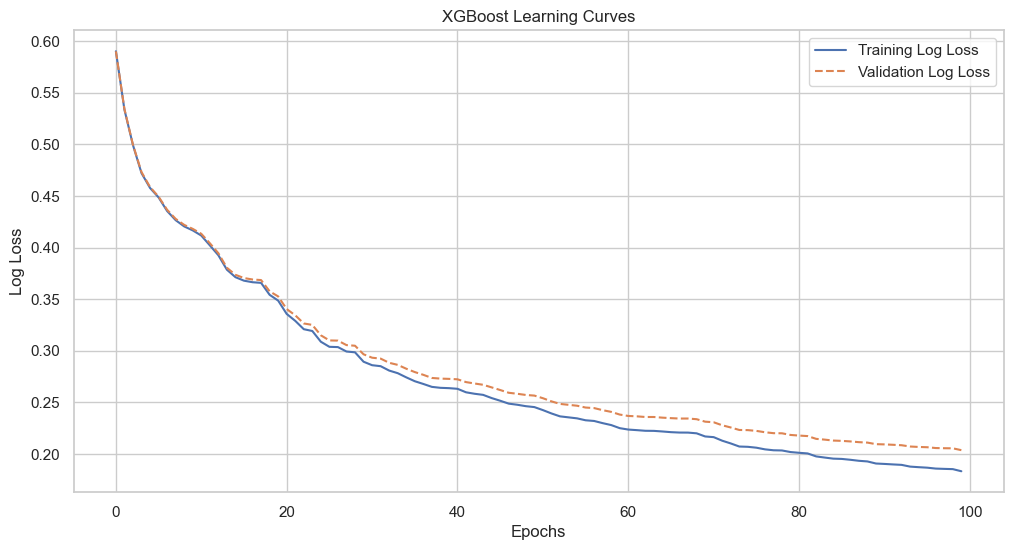

In [43]:
# Create copies of the original data to ensure no changes to the original
X_train_scaled_copy = np.array(X_train_scaled)
y_train_copy = np.array(y_train)

# Split the copied data for cross-validation
X_train_scaled_copy, X_val_scaled_copy, y_train_copy, y_val_copy = train_test_split(X_train_scaled_copy, y_train_copy, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_copy[y_train_copy == 0]) / len(y_train_copy[y_train_copy == 1]), 
                           random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the scoring method for recall
scoring = make_scorer(recall_score)

# K-fold Cross-validation (5 folds)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the copied data
cv_results = cross_val_score(xgb_model, X_train_scaled_copy, y_train_copy, cv=kfold, scoring=scoring)

# Print cross-validation results
print(f"Recall for XGBoost with 5-fold Cross-Validation: Mean={cv_results.mean():.4f}, Std={cv_results.std():.4f}")

# Fit the model and capture the evaluation results for plotting
history = xgb_model.fit(
    X_train_scaled_copy, 
    y_train_copy, 
    early_stopping_rounds=10, 
    eval_set=[(X_train_scaled_copy, y_train_copy), (X_val_scaled_copy, y_val_copy)], 
    verbose=True
)

# Retrieve training and validation log loss for the learning curve
train_log_loss = history.evals_result()['validation_0']['logloss']  # Training set
val_log_loss = history.evals_result()['validation_1']['logloss']   # Validation set

# Plot the learning curve (Training vs Validation Log Loss)
plt.figure(figsize=(12, 6))
plt.plot(train_log_loss, label='Training Log Loss')
plt.plot(val_log_loss, label='Validation Log Loss', linestyle='--')
plt.title("XGBoost Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.show()


### **Analysis of XGBoost Model (with 5-Fold Cross-Validation)**

#### **Cross-Validation Results**:
- **Recall (Mean)**: 0.8059-0.8379
- **Recall (Std)**: 0.0098-0.0153

The **mean recall** of **80.59%-83.7%** indicates that XGBoost is performing well at identifying falls (the minority class). The **standard deviation of 0.9%-1.53%** shows that the model’s recall performance is consistent across different splits, with only minor fluctuations.

### **Learning Curve Analysis**:
- The **learning curve** for both **training and validation losses** shows steady improvement as training progresses, with both curves decreasing. The gap between the training and validation losses indicates a balanced model that does not show signs of severe overfitting.

### **Model Performance Summary**:
- **High Recall**: XGBoost continues to demonstrate strong recall, which is important for a fall detection model to ensure minimal false negatives (i.e., missed falls).
- **Good Stability**: With a standard deviation of only 0.9%-1.53%, the model's performance across different data splits is stable.



### Random Forest Classifier

Recall for Random Forest with 5-fold Cross-Validation: Mean=0.4706, Std=0.0181


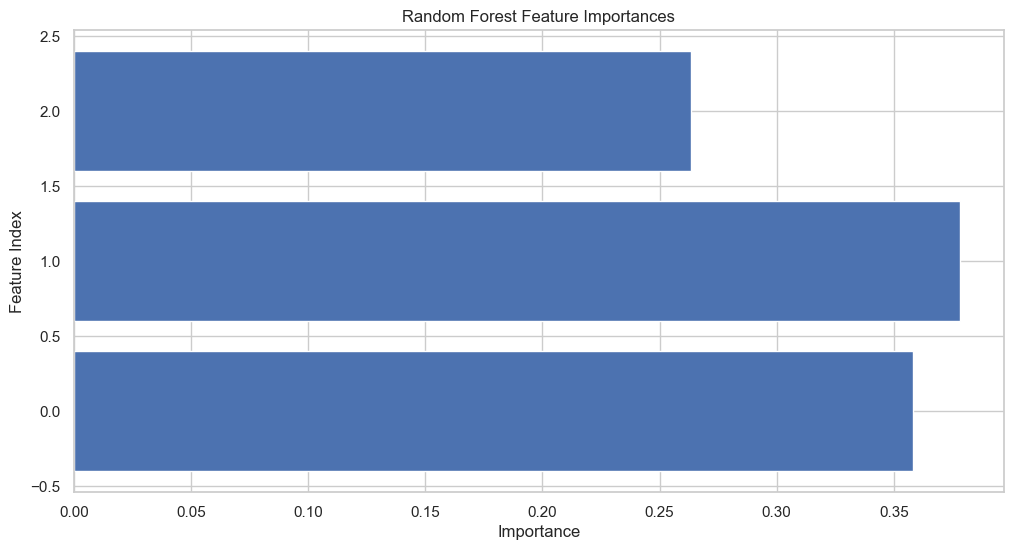

In [88]:
# Create copies of the original data to ensure no changes to the original
X_train_scaled_copy = np.array(X_train_scaled)
y_train_copy = np.array(y_train)

# Split the copied data for cross-validation
X_train_scaled_copy, X_val_scaled_copy, y_train_copy, y_val_copy = train_test_split(X_train_scaled_copy, y_train_copy, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the scoring method for recall
scoring = make_scorer(recall_score)

# K-fold Cross-validation (5 folds)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the copied data
cv_results = cross_val_score(rf_model, X_train_scaled_copy, y_train_copy, cv=kfold, scoring=scoring)

# Print cross-validation results
print(f"Recall for Random Forest with 5-fold Cross-Validation: Mean={cv_results.mean():.4f}, Std={cv_results.std():.4f}")

# Fit the model to the copied data (Random Forest does not use eval_metric like XGBoost)
rf_model.fit(X_train_scaled_copy, y_train_copy)

# Plot feature importance as a proxy for learning curve
plt.figure(figsize=(12, 6))
plt.barh(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature Index")
plt.show()


### Key Analysis for Random Forest with 5-Fold Cross-Validation:

**Recall:**

- Mean Recall: 0.2264-0.47

- Standard Deviation: 0.01-0.0243

The recall value of 0.2264-0.47 means the model identifies only 22.64%-47% of the minority class (positive instances). This indicates that the model struggles significantly to detect the positive class, which is typical when class imbalance exists.

The standard deviation of 0.01-0.0243 shows that the recall is fairly consistent across different folds of the data, suggesting that the model's performance does not vary greatly based on the specific split of the data.

**Feature Importances:**

The feature importance values shown in the plot range from around 0.0 to 0.3, with no single feature standing out as significantly more important than the others. The feature importances appear to be more evenly distributed across the different features.

This suggests that the Random Forest model is not overly reliant on any one particular feature, but is instead utilizing the information provided by the various features in a more balanced way to make its predictions.

The relatively even distribution of feature importances indicates that the model is likely considering multiple factors when making decisions, rather than focusing too heavily on a single dominant feature. This is generally a positive sign, as it shows the model is able to leverage the combined predictive power of the feature set.

**Possible Reasons for Low Recall:**

**Class Imbalance:** The Random Forest model, despite being balanced with respect to class weights, may still struggle with identifying the minority class if the dataset is highly imbalanced.


### ResNet with Focal Loss with class weights and threshold = 0.4

Processing Class Weight: {0: 1.0, 1: 3.0}
Processing Fold 1/5
Epoch 1/10
2685/2685 [==============================] - 18s 6ms/step - loss: 0.0152 - accuracy: 0.9507 - recall_37: 2.3776e-04 - val_loss: 0.0141 - val_accuracy: 0.9489 - val_recall_37: 0.0000e+00
Epoch 2/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0136 - accuracy: 0.9513 - recall_37: 0.0067 - val_loss: 0.0136 - val_accuracy: 0.9489 - val_recall_37: 0.0000e+00
Epoch 3/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0129 - accuracy: 0.9516 - recall_37: 0.0157 - val_loss: 0.0127 - val_accuracy: 0.9492 - val_recall_37: 0.0055
Epoch 4/10
2685/2685 [==============================] - 15s 6ms/step - loss: 0.0124 - accuracy: 0.9518 - recall_37: 0.0221 - val_loss: 0.0123 - val_accuracy: 0.9505 - val_recall_37: 0.0547
Epoch 5/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0119 - accuracy: 0.9524 - recall_37: 0.0330 - val_loss: 0.0121 - val_accuracy: 0.9501 - val

Epoch 7/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0115 - accuracy: 0.9523 - recall_40: 0.0614 - val_loss: 0.0110 - val_accuracy: 0.9557 - val_recall_40: 0.0660
Epoch 8/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0113 - accuracy: 0.9527 - recall_40: 0.0700 - val_loss: 0.0106 - val_accuracy: 0.9568 - val_recall_40: 0.1000
Epoch 9/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0110 - accuracy: 0.9545 - recall_40: 0.1125 - val_loss: 0.0101 - val_accuracy: 0.9565 - val_recall_40: 0.0780
Epoch 10/10
2685/2685 [==============================] - 19s 7ms/step - loss: 0.0108 - accuracy: 0.9548 - recall_40: 0.1157 - val_loss: 0.0099 - val_accuracy: 0.9587 - val_recall_40: 0.1270
Evaluation for Fold 4:
672/672 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     20476
         1.0       0.66      0.34      0.45      1000

 

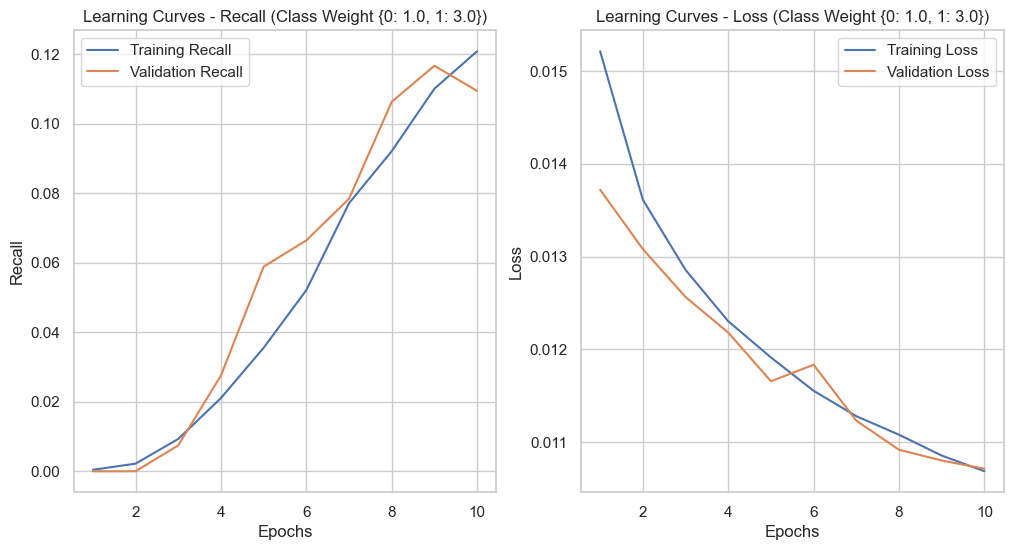

Processing Class Weight: {0: 1.0, 1: 5.0}
Processing Fold 1/5
Epoch 1/10
2685/2685 [==============================] - 19s 6ms/step - loss: 0.0152 - accuracy: 0.9507 - recall_42: 4.7551e-04 - val_loss: 0.0147 - val_accuracy: 0.9489 - val_recall_42: 0.0000e+00
Epoch 2/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0136 - accuracy: 0.9510 - recall_42: 2.3776e-04 - val_loss: 0.0135 - val_accuracy: 0.9489 - val_recall_42: 0.0000e+00
Epoch 3/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0128 - accuracy: 0.9516 - recall_42: 0.0150 - val_loss: 0.0128 - val_accuracy: 0.9492 - val_recall_42: 0.0046
Epoch 4/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0122 - accuracy: 0.9524 - recall_42: 0.0345 - val_loss: 0.0134 - val_accuracy: 0.9500 - val_recall_42: 0.0401
Epoch 5/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0118 - accuracy: 0.9524 - recall_42: 0.0350 - val_loss: 0.0119 - val_accuracy: 0.9507 -

Epoch 7/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0114 - accuracy: 0.9527 - recall_45: 0.0683 - val_loss: 0.0107 - val_accuracy: 0.9568 - val_recall_45: 0.0950
Epoch 8/10
2685/2685 [==============================] - 20s 7ms/step - loss: 0.0111 - accuracy: 0.9536 - recall_45: 0.0911 - val_loss: 0.0101 - val_accuracy: 0.9567 - val_recall_45: 0.0780
Epoch 9/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0109 - accuracy: 0.9543 - recall_45: 0.1039 - val_loss: 0.0101 - val_accuracy: 0.9577 - val_recall_45: 0.1000
Epoch 10/10
2685/2685 [==============================] - 20s 7ms/step - loss: 0.0107 - accuracy: 0.9549 - recall_45: 0.1185 - val_loss: 0.0102 - val_accuracy: 0.9580 - val_recall_45: 0.1110
Evaluation for Fold 4:
672/672 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     20476
         1.0       0.69      0.35      0.47      1000

 

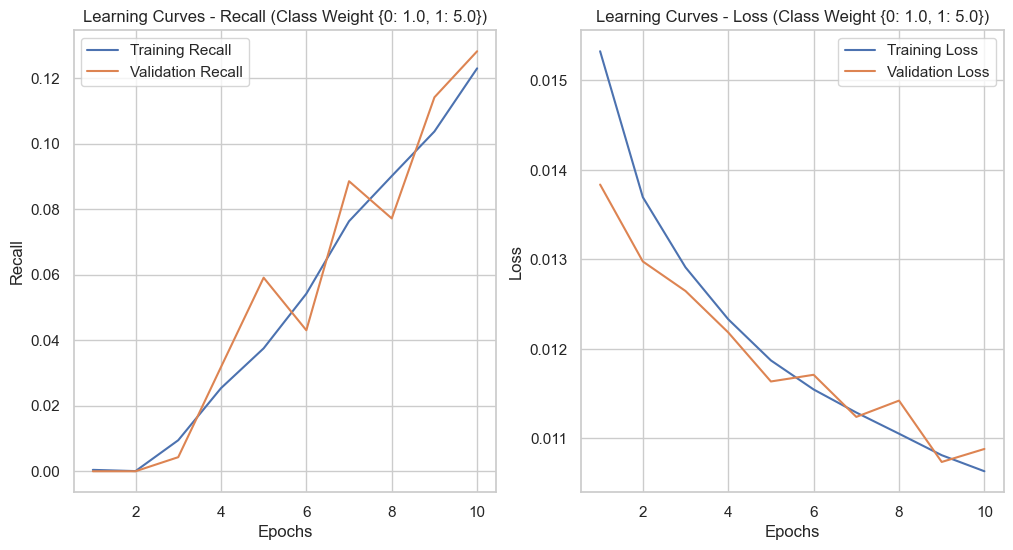

Processing Class Weight: {0: 1.0, 1: 7.0}
Processing Fold 1/5
Epoch 1/10
2685/2685 [==============================] - 21s 7ms/step - loss: 0.0150 - accuracy: 0.9507 - recall_47: 0.0000e+00 - val_loss: 0.0146 - val_accuracy: 0.9489 - val_recall_47: 0.0000e+00
Epoch 2/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0135 - accuracy: 0.9510 - recall_47: 7.1327e-04 - val_loss: 0.0133 - val_accuracy: 0.9489 - val_recall_47: 0.0000e+00
Epoch 3/10
2685/2685 [==============================] - 19s 7ms/step - loss: 0.0127 - accuracy: 0.9517 - recall_47: 0.0169 - val_loss: 0.0127 - val_accuracy: 0.9501 - val_recall_47: 0.0374
Epoch 4/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0122 - accuracy: 0.9518 - recall_47: 0.0207 - val_loss: 0.0119 - val_accuracy: 0.9500 - val_recall_47: 0.0264
Epoch 5/10
2685/2685 [==============================] - 20s 7ms/step - loss: 0.0118 - accuracy: 0.9527 - recall_47: 0.0409 - val_loss: 0.0118 - val_accuracy: 0.9517 -

Epoch 7/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0113 - accuracy: 0.9528 - recall_50: 0.0732 - val_loss: 0.0108 - val_accuracy: 0.9572 - val_recall_50: 0.0980
Epoch 8/10
2685/2685 [==============================] - 19s 7ms/step - loss: 0.0111 - accuracy: 0.9539 - recall_50: 0.0971 - val_loss: 0.0104 - val_accuracy: 0.9553 - val_recall_50: 0.0450
Epoch 9/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0109 - accuracy: 0.9545 - recall_50: 0.1120 - val_loss: 0.0101 - val_accuracy: 0.9561 - val_recall_50: 0.0760
Epoch 10/10
2685/2685 [==============================] - 15s 6ms/step - loss: 0.0107 - accuracy: 0.9554 - recall_50: 0.1329 - val_loss: 0.0100 - val_accuracy: 0.9574 - val_recall_50: 0.0990
Evaluation for Fold 4:
672/672 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     20476
         1.0       0.69      0.36      0.47      1000

 

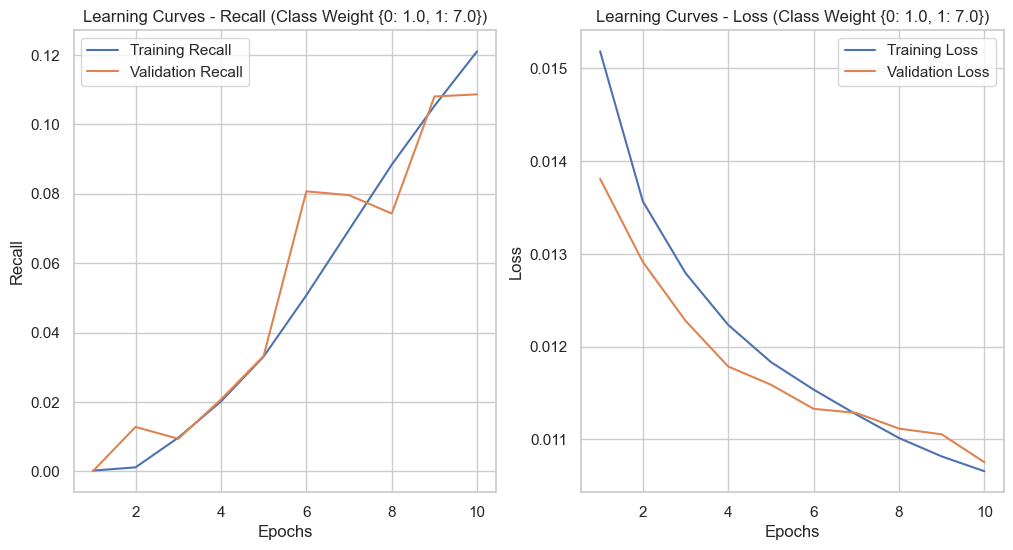

Processing Class Weight: {0: 1.0, 1: 10.0}
Processing Fold 1/5
Epoch 1/10
2685/2685 [==============================] - 20s 7ms/step - loss: 0.0151 - accuracy: 0.9507 - recall_52: 2.3776e-04 - val_loss: 0.0141 - val_accuracy: 0.9489 - val_recall_52: 0.0000e+00
Epoch 2/10
2685/2685 [==============================] - 21s 8ms/step - loss: 0.0133 - accuracy: 0.9512 - recall_52: 0.0043 - val_loss: 0.0136 - val_accuracy: 0.9489 - val_recall_52: 0.0000e+00
Epoch 3/10
2685/2685 [==============================] - 23s 9ms/step - loss: 0.0126 - accuracy: 0.9517 - recall_52: 0.0178 - val_loss: 0.0126 - val_accuracy: 0.9502 - val_recall_52: 0.0392
Epoch 4/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0122 - accuracy: 0.9520 - recall_52: 0.0264 - val_loss: 0.0122 - val_accuracy: 0.9500 - val_recall_52: 0.0356
Epoch 5/10
2685/2685 [==============================] - 18s 7ms/step - loss: 0.0119 - accuracy: 0.9522 - recall_52: 0.0288 - val_loss: 0.0121 - val_accuracy: 0.9499 - va

Epoch 7/10
2685/2685 [==============================] - 20s 7ms/step - loss: 0.0114 - accuracy: 0.9524 - recall_55: 0.0641 - val_loss: 0.0117 - val_accuracy: 0.9573 - val_recall_55: 0.1490
Epoch 8/10
2685/2685 [==============================] - 17s 6ms/step - loss: 0.0111 - accuracy: 0.9531 - recall_55: 0.0802 - val_loss: 0.0101 - val_accuracy: 0.9574 - val_recall_55: 0.1030
Epoch 9/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0109 - accuracy: 0.9547 - recall_55: 0.1150 - val_loss: 0.0110 - val_accuracy: 0.9585 - val_recall_55: 0.1260
Epoch 10/10
2685/2685 [==============================] - 16s 6ms/step - loss: 0.0107 - accuracy: 0.9552 - recall_55: 0.1281 - val_loss: 0.0102 - val_accuracy: 0.9577 - val_recall_55: 0.1160
Evaluation for Fold 4:
672/672 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     20476
         1.0       0.65      0.36      0.46      1000

 

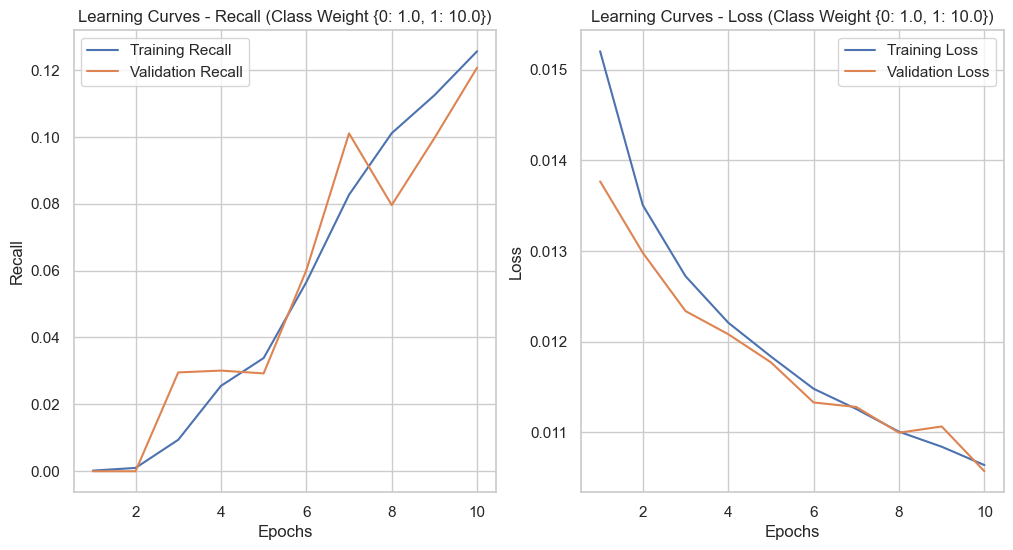

In [93]:
# Create copies of the original data to ensure no changes to the original
X_train_scaled_copy = np.array(X_train_scaled)
y_train_copy = np.array(y_train)

# Number of splits for k-fold cross-validation
n_splits = 5

# Initialize k-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Arrays to store results for learning curves
train_recalls_all = {}
val_recalls_all = {}
train_losses_all = {}
val_losses_all = {}

# Function to plot learning curves
def plot_learning_curves(train_metric, val_metric, train_loss, val_loss, metric_name="Recall", class_weight=None):
    epochs = range(1, len(train_metric) + 1)
    plt.figure(figsize=(12, 6))

    # Metric plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metric, label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, label=f'Validation {metric_name}')
    plt.title(f'Learning Curves - {metric_name} (Class Weight {class_weight})')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Learning Curves - Loss (Class Weight {class_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Focal Loss function (reused from original code)
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        loss = -alpha * (1 - y_pred)**gamma * y_true * tf.math.log(y_pred) - \
               (1 - alpha) * y_pred**gamma * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Function to compile the ResNet model with the desired metrics
def compile_resnet_with_weights(input_shape, loss_fn, class_weights=None):
    model = build_resnet(input_shape)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# List of class weights
class_weight_options = [
    {0: 1.0, 1: 3.0},
    {0: 1.0, 1: 5.0},
    {0: 1.0, 1: 7.0},
    {0: 1.0, 1: 10.0}
]

# Iterate over class weights
for class_weight in class_weight_options:
    print(f"Processing Class Weight: {class_weight}")

    # Initialize arrays for the current class weight
    train_recalls = []
    val_recalls = []
    train_losses = []
    val_losses = []

    # Fold index for tracking progress
    fold_idx = 1

    for train_index, val_index in kf.split(X_train_scaled_copy):
        print(f"Processing Fold {fold_idx}/{n_splits}")

        # Split data into train and validation sets for this fold (using copied data)
        X_train_fold = X_train_scaled_copy[train_index]
        y_train_fold = y_train_copy[train_index]
        X_val_fold = X_train_scaled_copy[val_index]
        y_val_fold = y_train_copy[val_index]

        # Reshape for ResNet input (using the copied data)
        X_train_fold_reshaped = np.expand_dims(X_train_fold, axis=-1)
        X_val_fold_reshaped = np.expand_dims(X_val_fold, axis=-1)

        # Build and compile the ResNet model
        model = compile_resnet_with_weights(
            input_shape=(X_train_fold_reshaped.shape[1], 1),
            loss_fn=focal_loss(),
            class_weights=class_weight
        )

        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model on the copied data
        history = model.fit(
            X_train_fold_reshaped, y_train_fold,
            validation_data=(X_val_fold_reshaped, y_val_fold),
            epochs=10,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )

        # Dynamically fetch recall keys
        recall_key = next((key for key in history.history.keys() if "recall" in key.lower()), None)
        val_recall_key = next((key for key in history.history.keys() if "val_recall" in key.lower()), None)

        # Store recall and loss for this fold
        if recall_key and val_recall_key:
            train_recalls.append(history.history[recall_key])
            val_recalls.append(history.history[val_recall_key])
        else:
            raise KeyError("Recall metrics not found in training history.")

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        # Evaluate model
        print(f"Evaluation for Fold {fold_idx}:")
        y_pred_probs = model.predict(X_val_fold_reshaped)
        y_pred = (y_pred_probs > 0.4).astype(int)  # Threshold = 0.4
        print(classification_report(y_val_fold, y_pred))

        fold_idx += 1

    # Average results for learning curves
    avg_train_recall = np.mean(np.array(train_recalls), axis=0)
    avg_val_recall = np.mean(np.array(val_recalls), axis=0)
    avg_train_loss = np.mean(np.array(train_losses), axis=0)
    avg_val_loss = np.mean(np.array(val_losses), axis=0)

    # Store results for this class weight
    train_recalls_all[class_weight[1]] = avg_train_recall
    val_recalls_all[class_weight[1]] = avg_val_recall
    train_losses_all[class_weight[1]] = avg_train_loss
    val_losses_all[class_weight[1]] = avg_val_loss

    # Plot learning curves
    plot_learning_curves(avg_train_recall, avg_val_recall, avg_train_loss, avg_val_loss, metric_name="Recall", class_weight=class_weight)


###  Analysis: ResNet with Focal Loss (Class Weights, Threshold = 0.4)

1. **Training & Validation Recall**:
   - Recall improves steadily across epochs for both training and validation.
   - Validation recall slightly leads training recall, indicating good generalization with minimal overfitting.

2. **Training & Validation Loss**:
   - Both training and validation losses decrease consistently, showing effective learning.
   - Validation loss stabilizes with minor fluctuations, suggesting robustness.

3. **Impact of Class Weights**:
   - Increasing class weights for the minority class (fall) helps enhance recall, but the gains diminish at higher weight values (e.g., {0:1.0, 1:5.0}).
   - Class weights effectively address the imbalance but lead to diminishing returns beyond a specific point.

4. **General Observations**:
   - A class weight ratio of {0:1.0, 1:3.0} balances recall improvement and loss reduction well, avoiding overfitting.
   - Class weights beyond {0:1.0, 1:5.0} may risk minor instability in loss and recall trends.

5. **Threshold Analysis**:
   - A threshold of 0.4 aligns well with the focal loss, prioritizing harder-to-classify samples, improving the model's ability to detect falls effectively.

### Recommendation:
- Class weight {0:1.0, 1:3.0} provides optimal balance between recall and stability.


## Decision Tree

Processing Fold 1/5
Evaluation for Fold 1:
Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     20380
         1.0       0.10      0.96      0.18      1097

    accuracy                           0.55     21477
   macro avg       0.55      0.75      0.44     21477
weighted avg       0.95      0.55      0.67     21477

Confusion Matrix:
[[10860  9520]
 [   43  1054]]
Recall (Validation Set): 0.9608021877848678
Processing Fold 2/5
Evaluation for Fold 2:
Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0       0.99      0.56      0.72     20397
         1.0       0.10      0.94      0.18      1080

    accuracy                           0.58     21477
   macro avg       0.55      0.75      0.45     21477
weighted avg       0.95      0.58      0.69     21477

Confusion Matrix:
[[11409  8988]
 [   63  1017]]
Recall (Validation Set): 0.94166666666

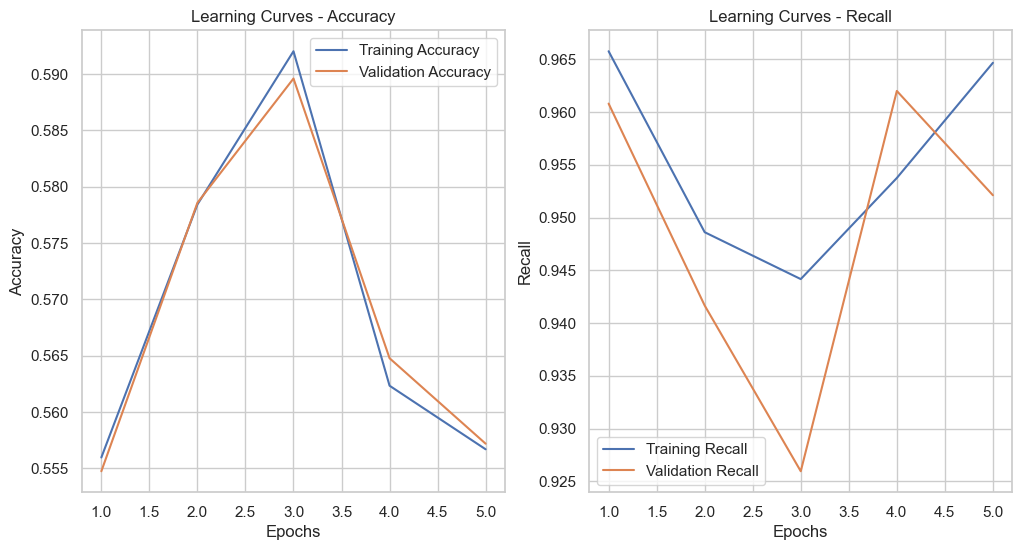

In [97]:
# Create copies of the original data to avoid unintended changes
X_train_scaled_copy = np.array(X_train_scaled)
y_train_copy = np.array(y_train)

# Initialize the 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store metrics for learning curves
train_accuracies = []
val_accuracies = []
train_recalls = []
val_recalls = []

# Function to plot learning curves
def plot_learning_curves(train_acc, val_acc, train_recall, val_recall):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Recall plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Learning Curves - Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

# K-Fold Cross-Validation loop
fold_idx = 1
for train_index, val_index in kf.split(X_train_scaled_copy):
    print(f"Processing Fold {fold_idx}/5")

    # Split the data into training and validation sets for this fold (using copies)
    X_train_fold = X_train_scaled_copy[train_index]
    y_train_fold = y_train_copy[train_index]
    X_val_fold = X_train_scaled_copy[val_index]
    y_val_fold = y_train_copy[val_index]

    # Initialize the Decision Tree model with balanced class weights
    decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5, min_samples_split=10)

    # Train the model
    decision_tree.fit(X_train_fold, y_train_fold)

    # Predict on the training and validation sets
    y_pred_train = decision_tree.predict(X_train_fold)
    y_pred_val = decision_tree.predict(X_val_fold)

    # Store training and validation metrics for learning curves
    train_accuracies.append(accuracy_score(y_train_fold, y_pred_train))
    val_accuracies.append(accuracy_score(y_val_fold, y_pred_val))
    train_recalls.append(recall_score(y_train_fold, y_pred_train))
    val_recalls.append(recall_score(y_val_fold, y_pred_val))

    # Print classification report for each fold
    print(f"Evaluation for Fold {fold_idx}:")
    print("Classification Report (Validation Set):")
    print(classification_report(y_val_fold, y_pred_val))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_pred_val))
    print("Recall (Validation Set):", recall_score(y_val_fold, y_pred_val))

    fold_idx += 1

# After all folds are completed, plot the learning curves
plot_learning_curves(train_accuracies, val_accuracies, train_recalls, val_recalls)


### Analysis of Decision Tree Classifier with 5-Fold Cross-Validation:

---

#### Key Observations:

1. **High Recall for Falls (Class 1)**:
   - Consistently high recall (**0.92 to 0.96**) across folds ensures most falls are correctly identified, meeting the critical goal of minimizing missed falls.

2. **Low Precision for Falls**:
   - Precision for class 1 remains low (**0.09 to 0.10**), indicating many false positives where non-falls are misclassified as falls.

3. **Class Imbalance Impact**:
   - The imbalance skews metrics, with a focus on recall at the cost of precision. Accuracy remains moderate (**0.55 to 0.58**), reflecting this trade-off.

4. **Confusion Matrix Insights**:
   - High true positives for falls but significant false positives for non-falls. Example: **Fold 1** correctly identifies **1054 falls** but misclassifies **9520 non-falls as falls**.

5. **Learning Curves**:
   - Training and validation recall are high and converge, showing good generalization with minimal overfitting.

---


## Testing on unseen data (Test)

### Loading test data

In [33]:
# Path to the test data directory
test_data_path = "./test/"

# List all CSV files in the directory
test_data_files = glob.glob(test_data_path + "*.csv")

# Load all test data files
test_data_list = []
for file in test_data_files:
    df = pd.read_csv(file)
    test_data_list.append(df)

# Concatenate the test data
if len(test_data_list) > 0:
    test_data = pd.concat(test_data_list, ignore_index=True)
    print("Test data loaded successfully.")
else:
    print("No test data found.")

# Display the first few rows to confirm
test_data.head()


Test data loaded successfully.


x          y         z  010-000-024-033  010-000-030-096  \
0  6.504078  12.789729  9.447159              1.0              0.0   
1  6.472978  12.675193  9.622985              0.0              0.0   
2  6.452725  12.625970  9.325761              0.0              1.0   
3  6.426322  12.610741  9.753680              0.0              0.0   
4  6.401717  12.602613  9.780900              1.0              0.0   

   020-000-032-221  020-000-033-111  anomaly  
0              0.0              0.0      0.0  
1              1.0              0.0      0.0  
2              0.0              0.0      0.0  
3              0.0              1.0      0.0  
4              0.0              0.0      0.0

### Check for missing values

In [84]:
# Check for missing values in the test dataset
missing_values = test_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# If there are missing values, you can choose to impute or drop them
# For now, let's just display the count of missing values in each column


Missing values in each column:
x                  0
y                  0
z                  0
010-000-024-033    0
010-000-030-096    0
020-000-032-221    0
020-000-033-111    0
anomaly            0
dtype: int64


### Data preprocessing

In [35]:
# Assuming the test data follows the same structure as the training data
X_train = train_data.drop(columns=['anomaly'])  # Drop the 'anomaly' column in the training set
y_train = train_data['anomaly']  # 'anomaly' is the label column in the training set

# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Fit the scaler on the training data (using only the features, not the label)
X_train_scaled = scaler.fit_transform(X_train[['x', 'y', 'z']])  # Fit on the relevant features ('x', 'y', 'z')

# Step 3: Now, scale the test data using the already fitted scaler
X_test = test_data.drop(columns=['anomaly'])  # Drop the 'anomaly' column from the test data
y_test = test_data['anomaly']  # 'anomaly' is the label column in the test set

# Apply scaling to the test data (use the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test[['x', 'y', 'z']])  # Transform using the scaler fitted on the training data

# Step 4: Reshape for 1D CNN input (samples, features, channels)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)  # Add an extra dimension for CNN input (samples, features, channels)

print("Test data preprocessing completed.")


Test data preprocessing completed.


## XGBoost Classfier model

XGBoost Test Performance:
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.92     28420
         1.0       0.16      0.42      0.23      1610

    accuracy                           0.85     30030
   macro avg       0.56      0.65      0.57     30030
weighted avg       0.92      0.85      0.88     30030

Confusion Matrix (Test Set):
[[24851  3569]
 [  928   682]]
Recall (Test Set): 0.4236024844720497


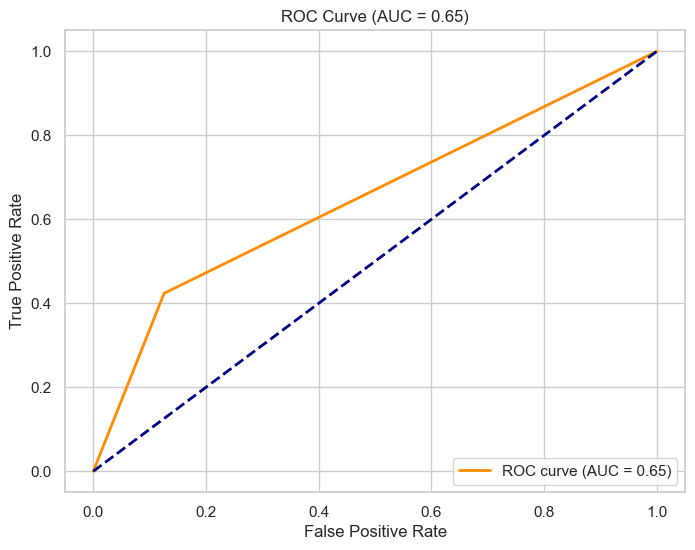

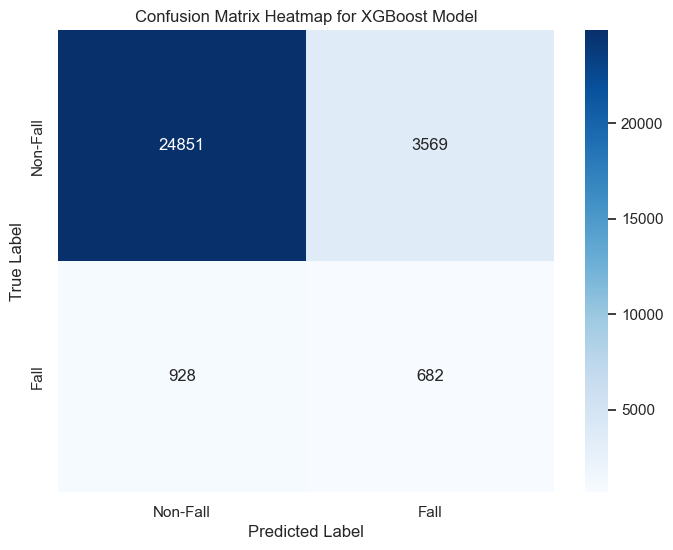

In [111]:
# Ensure X_test_scaled is 2-dimensional for XGBoost
X_test_scaled_2d = X_test_scaled.reshape(X_test_scaled.shape[0], -1)  # Flatten the last dimension

# Predict on the test set
y_pred_xgb_test = xgb_model.predict(X_test_scaled_2d)

# Evaluate the model
print("XGBoost Test Performance:")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_xgb_test))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_xgb_test))
print("Recall (Test Set):", recall_score(y_test, y_pred_xgb_test))

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb_test)  # Use predicted probabilities for ROC curve
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
cm = confusion_matrix(y_test, y_pred_xgb_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## ResNet with Binary Crossentropy & Focal Loss seperately for Threshold 0.4 and 0.5


Testing Model: resnet_focal_loss_classweights_7.0.h5
939/939 [==============================] - 2s 2ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     28420
         1.0       0.13      0.30      0.19      1610

    accuracy                           0.86     30030
   macro avg       0.55      0.59      0.55     30030
weighted avg       0.91      0.86      0.88     30030

Confusion Matrix (Test Set):
[[25349  3071]
 [ 1132   478]]


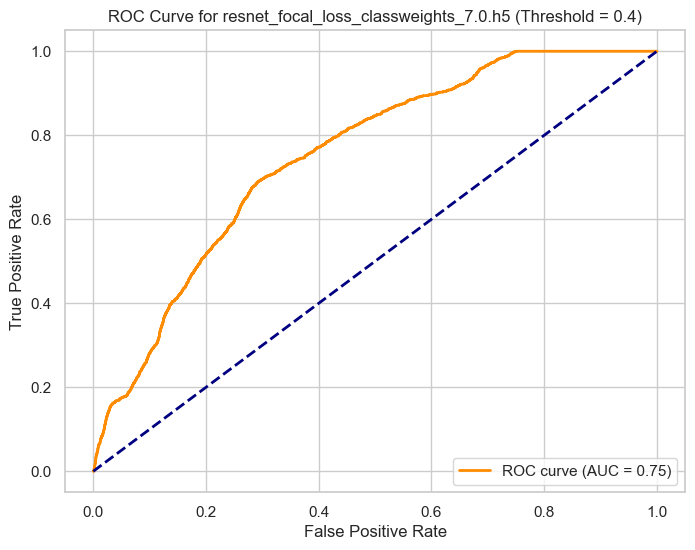

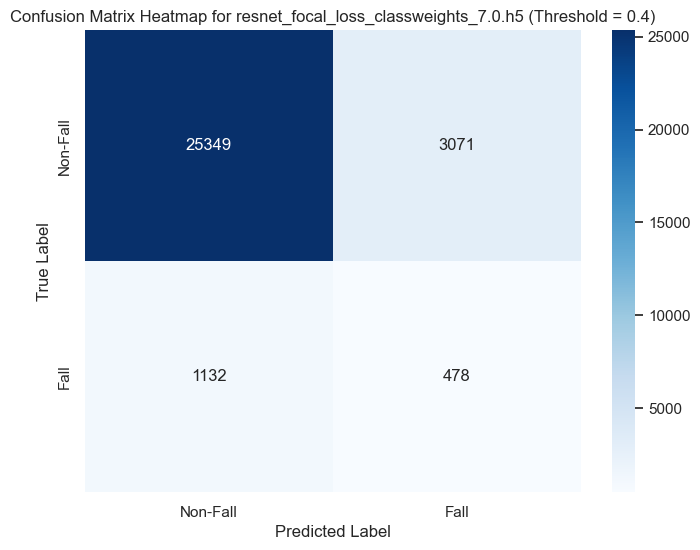


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     28420
         1.0       0.17      0.17      0.17      1610

    accuracy                           0.91     30030
   macro avg       0.56      0.56      0.56     30030
weighted avg       0.91      0.91      0.91     30030

Confusion Matrix (Test Set):
[[27126  1294]
 [ 1337   273]]


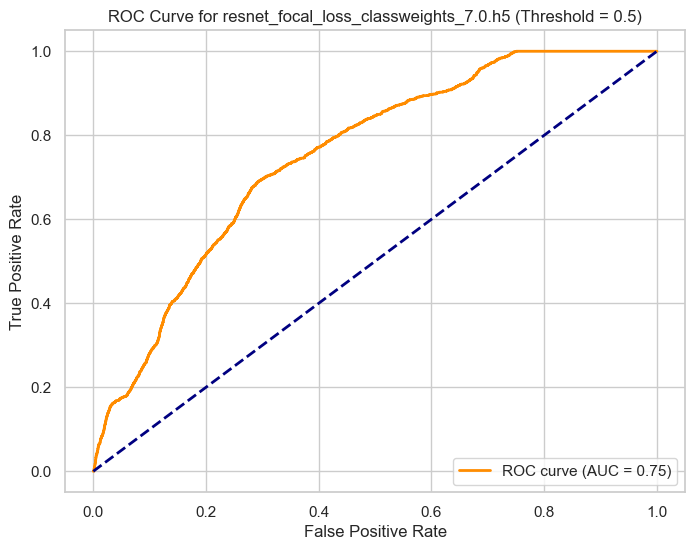

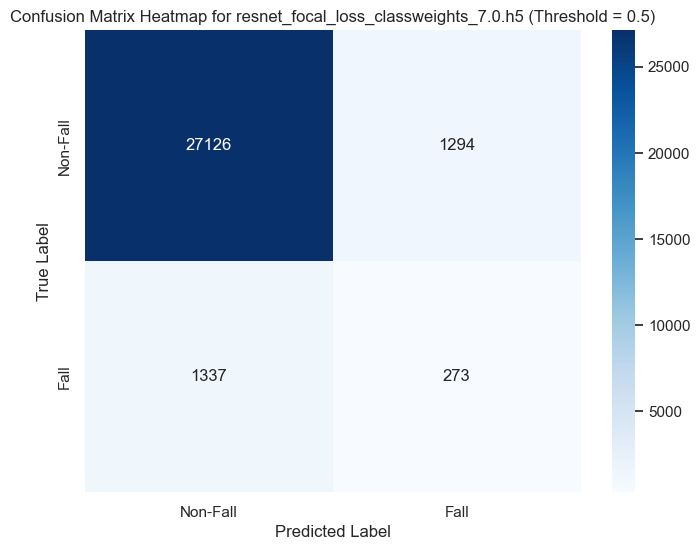


Testing Model: resnet_binary_crossentropy_classweights_10.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.98      0.67      0.79     28420
         1.0       0.11      0.72      0.19      1610

    accuracy                           0.67     30030
   macro avg       0.54      0.69      0.49     30030
weighted avg       0.93      0.67      0.76     30030

Confusion Matrix (Test Set):
[[18905  9515]
 [  446  1164]]


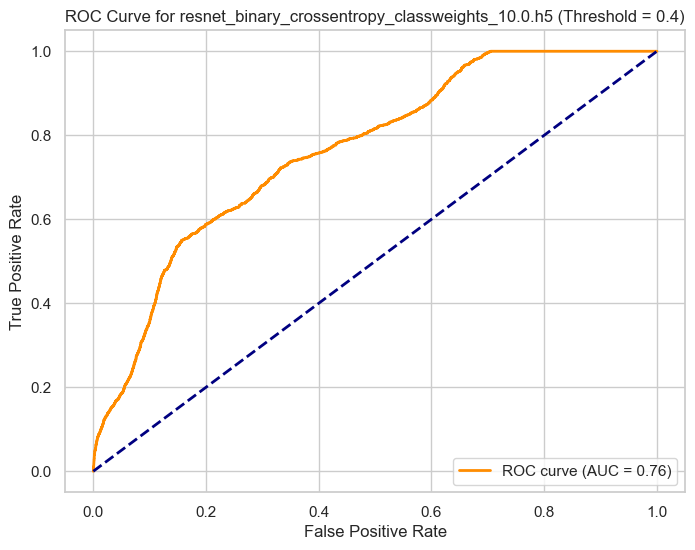

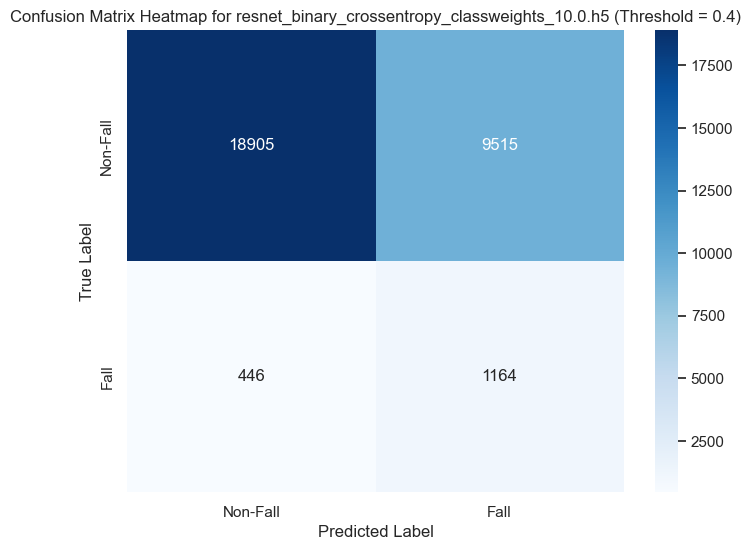


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     28420
         1.0       0.11      0.70      0.19      1610

    accuracy                           0.68     30030
   macro avg       0.54      0.69      0.50     30030
weighted avg       0.93      0.68      0.77     30030

Confusion Matrix (Test Set):
[[19427  8993]
 [  484  1126]]


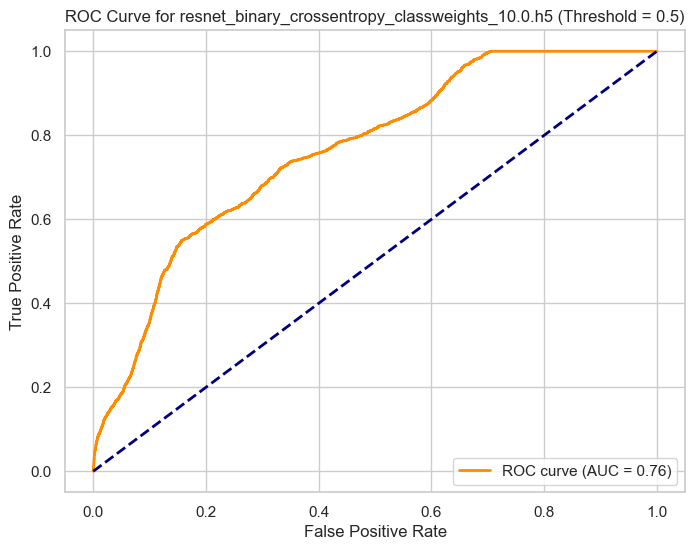

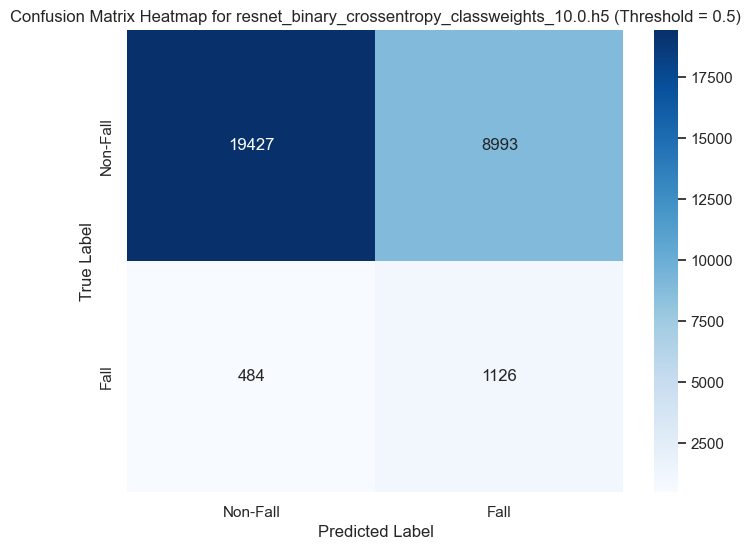


Testing Model: resnet_binary_crossentropy_classweights_5.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82     28420
         1.0       0.11      0.64      0.19      1610

    accuracy                           0.70     30030
   macro avg       0.54      0.67      0.50     30030
weighted avg       0.93      0.70      0.78     30030

Confusion Matrix (Test Set):
[[20021  8399]
 [  584  1026]]


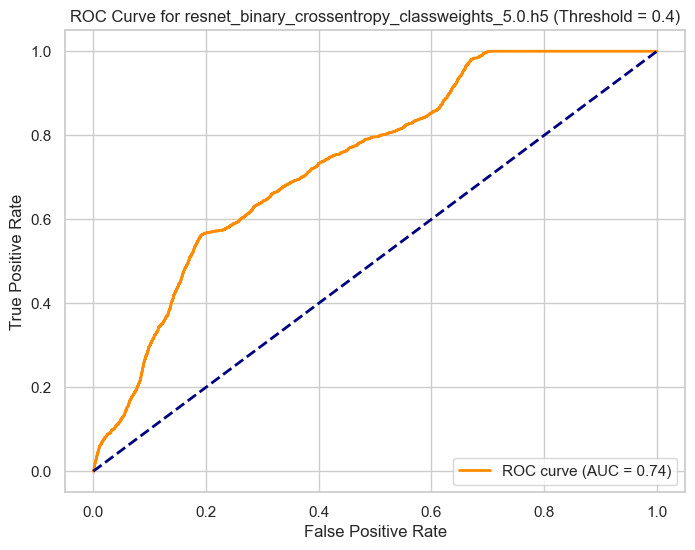

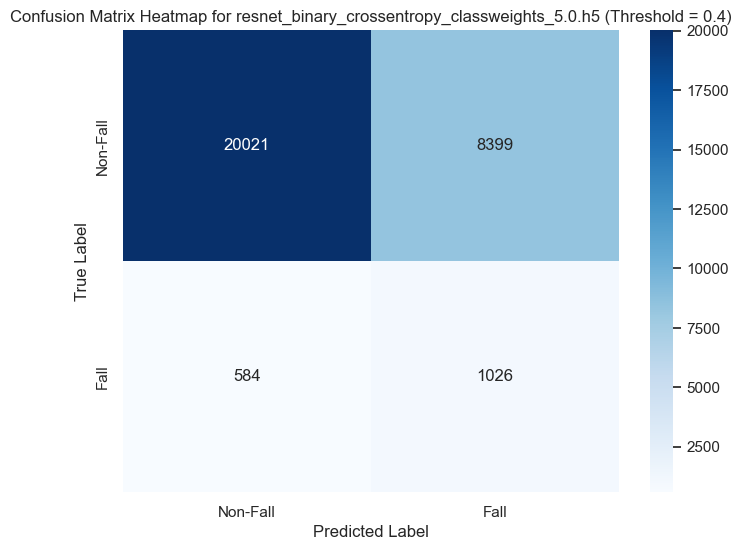


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     28420
         1.0       0.11      0.61      0.19      1610

    accuracy                           0.72     30030
   macro avg       0.54      0.67      0.51     30030
weighted avg       0.92      0.72      0.80     30030

Confusion Matrix (Test Set):
[[20617  7803]
 [  622   988]]


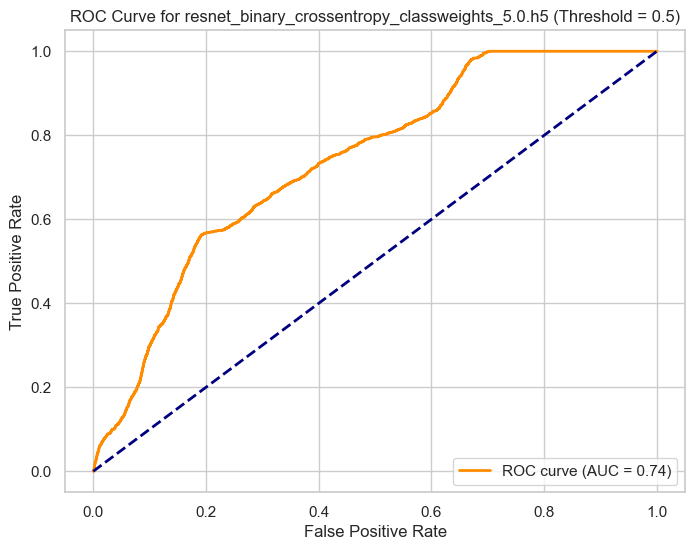

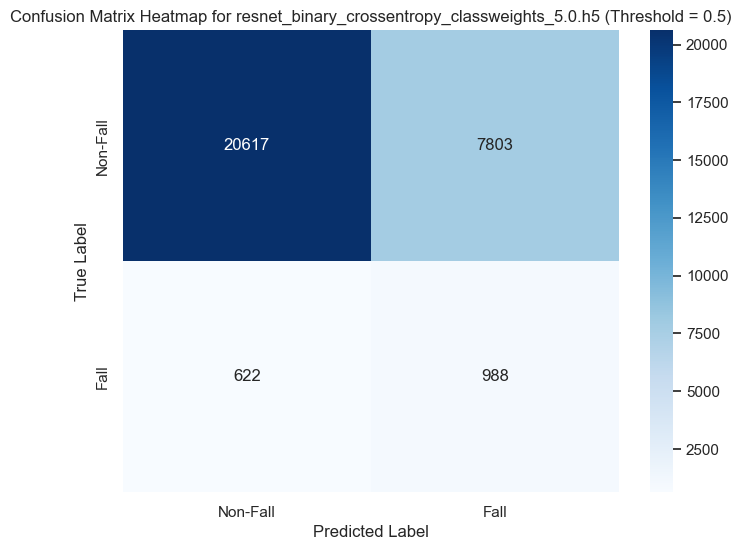


Testing Model: resnet_binary_crossentropy_classweights_3.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85     28420
         1.0       0.12      0.59      0.20      1610

    accuracy                           0.75     30030
   macro avg       0.55      0.68      0.53     30030
weighted avg       0.93      0.75      0.82     30030

Confusion Matrix (Test Set):
[[21639  6781]
 [  655   955]]


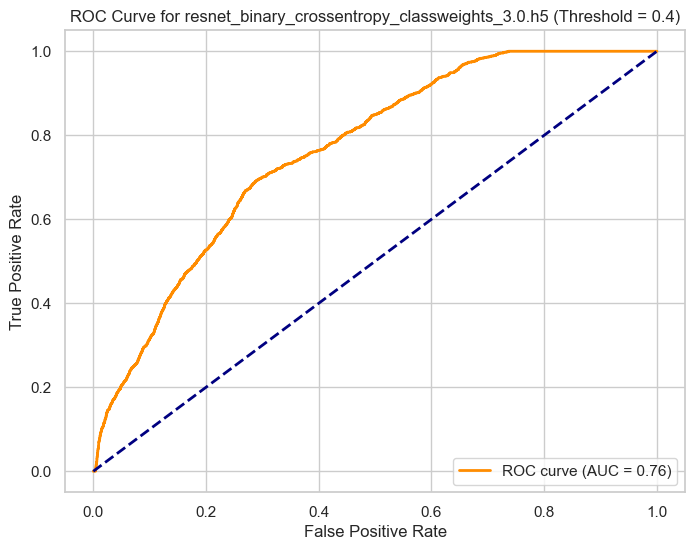

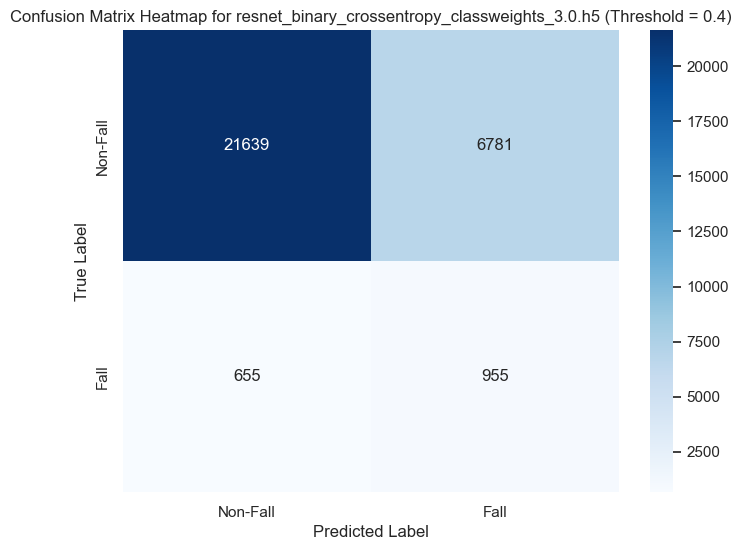


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     28420
         1.0       0.13      0.54      0.21      1610

    accuracy                           0.77     30030
   macro avg       0.55      0.67      0.54     30030
weighted avg       0.92      0.77      0.83     30030

Confusion Matrix (Test Set):
[[22381  6039]
 [  734   876]]


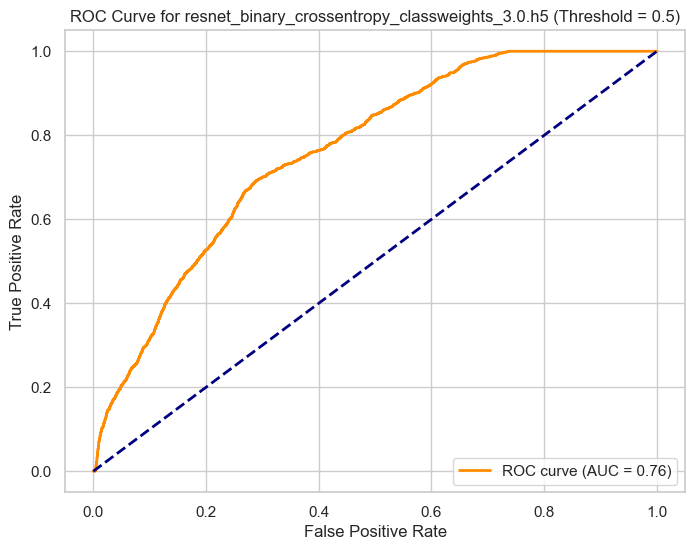

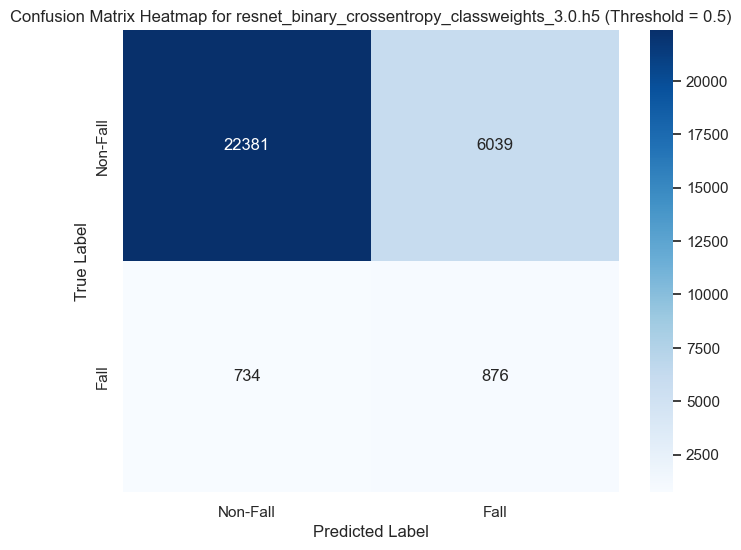


Testing Model: resnet_focal_loss_classweights_3.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.94     28420
         1.0       0.24      0.41      0.30      1610

    accuracy                           0.90     30030
   macro avg       0.60      0.67      0.62     30030
weighted avg       0.93      0.90      0.91     30030

Confusion Matrix (Test Set):
[[26294  2126]
 [  942   668]]


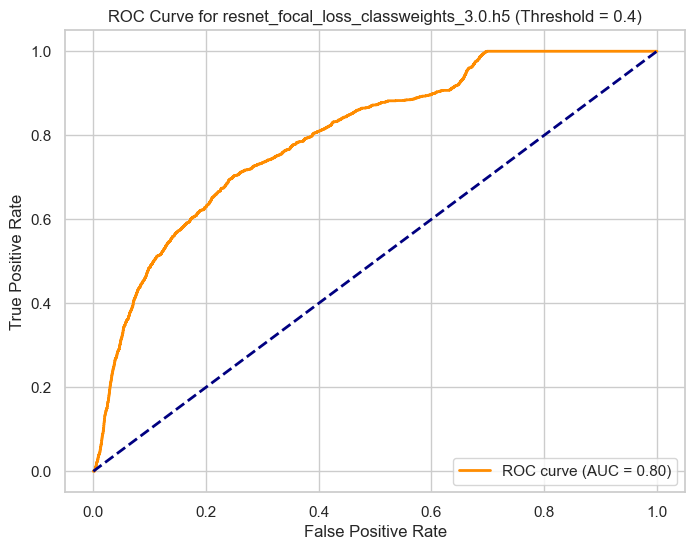

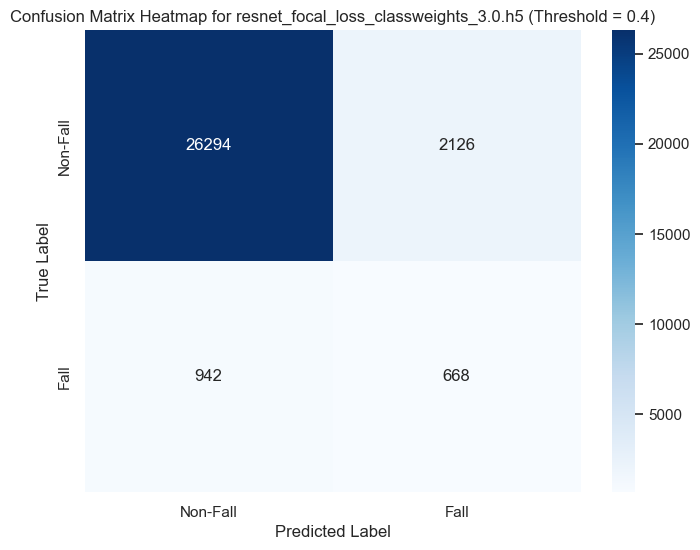


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     28420
         1.0       0.28      0.25      0.26      1610

    accuracy                           0.93     30030
   macro avg       0.62      0.61      0.61     30030
weighted avg       0.92      0.93      0.92     30030

Confusion Matrix (Test Set):
[[27388  1032]
 [ 1210   400]]


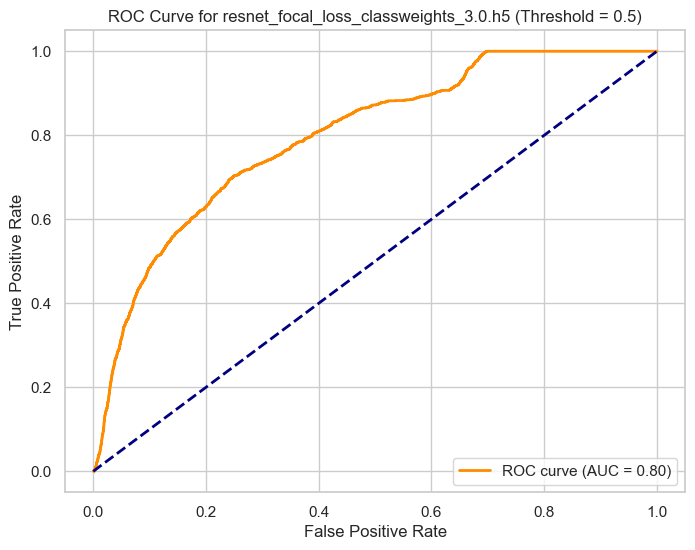

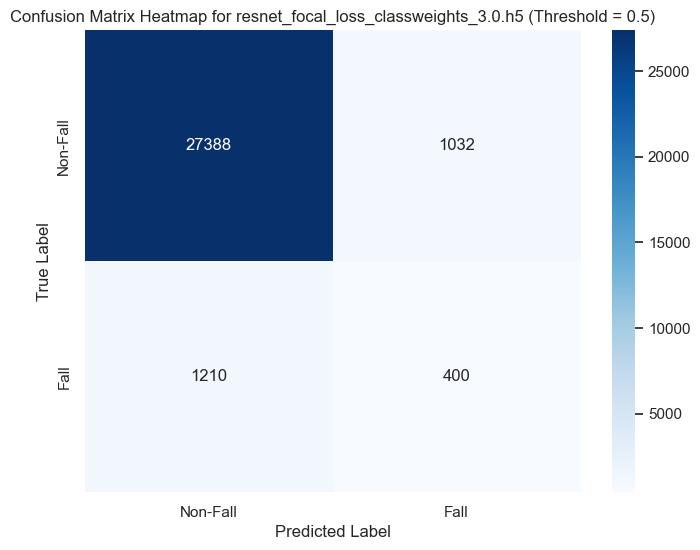


Testing Model: resnet_focal_loss_classweights_5.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     28420
         1.0       0.17      0.39      0.23      1610

    accuracy                           0.86     30030
   macro avg       0.56      0.64      0.58     30030
weighted avg       0.92      0.86      0.89     30030

Confusion Matrix (Test Set):
[[25244  3176]
 [  976   634]]


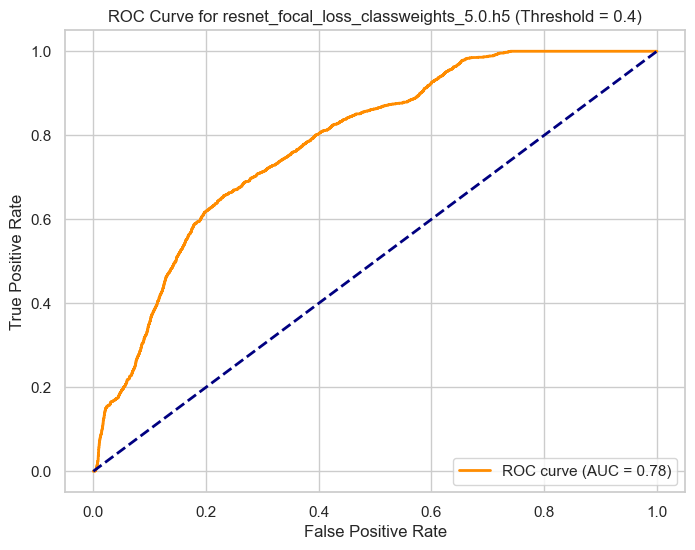

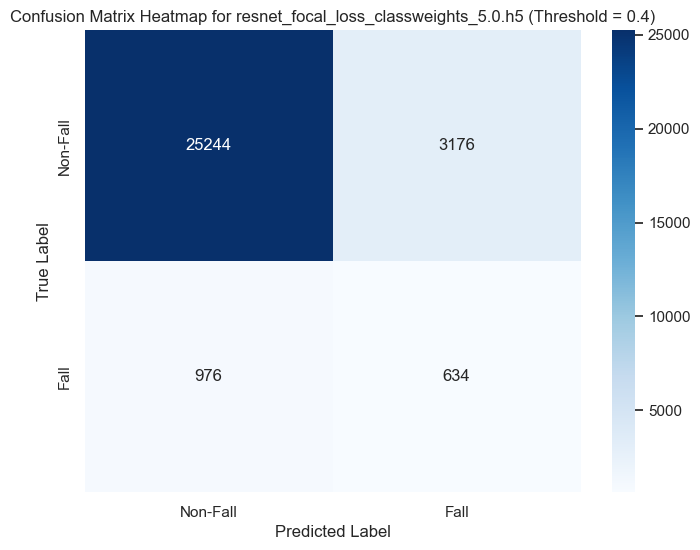


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     28420
         1.0       0.18      0.19      0.18      1610

    accuracy                           0.91     30030
   macro avg       0.57      0.57      0.57     30030
weighted avg       0.91      0.91      0.91     30030

Confusion Matrix (Test Set):
[[26965  1455]
 [ 1298   312]]


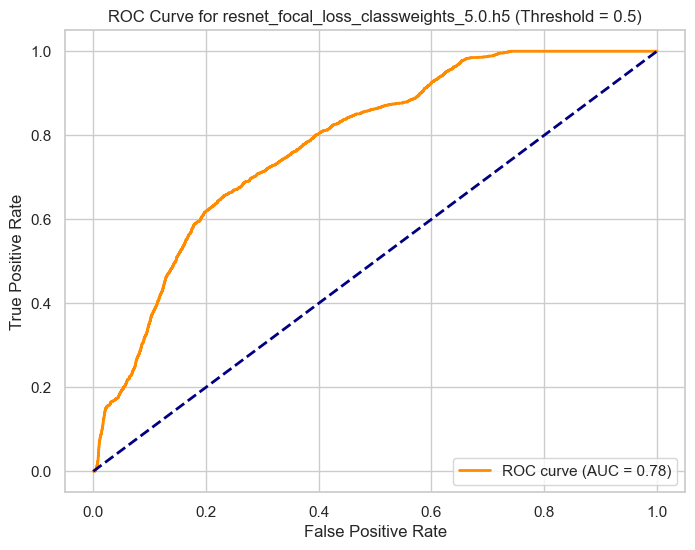

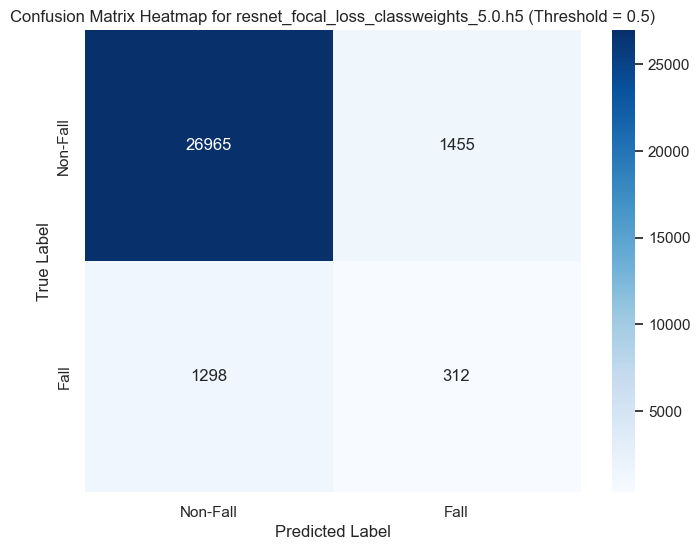


Testing Model: resnet_focal_loss_classweights_10.0.h5
939/939 [==============================] - 3s 3ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     28420
         1.0       0.17      0.44      0.24      1610

    accuracy                           0.85     30030
   macro avg       0.57      0.66      0.58     30030
weighted avg       0.92      0.85      0.88     30030

Confusion Matrix (Test Set):
[[24906  3514]
 [  899   711]]


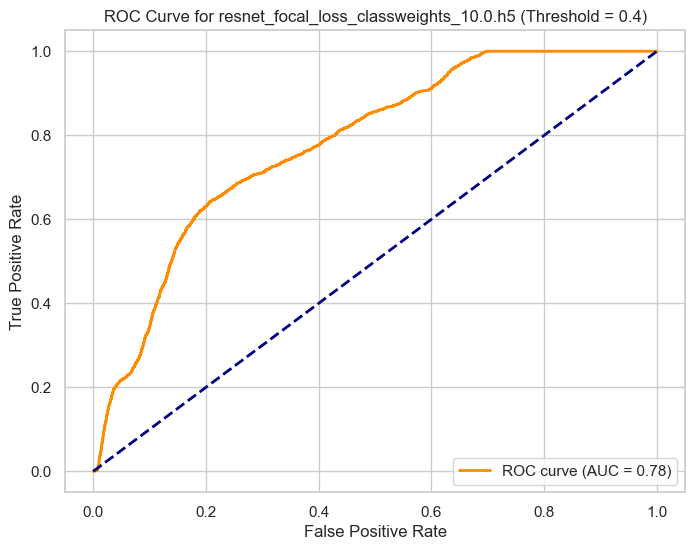

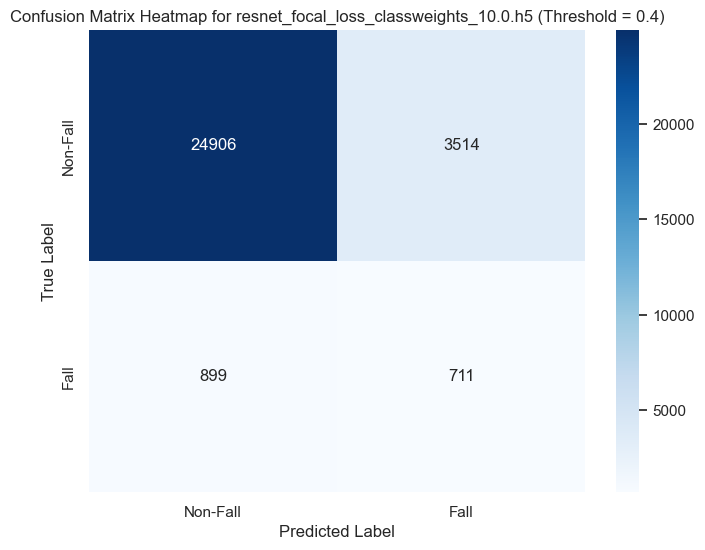


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     28420
         1.0       0.20      0.22      0.21      1610

    accuracy                           0.91     30030
   macro avg       0.58      0.58      0.58     30030
weighted avg       0.91      0.91      0.91     30030

Confusion Matrix (Test Set):
[[27003  1417]
 [ 1260   350]]


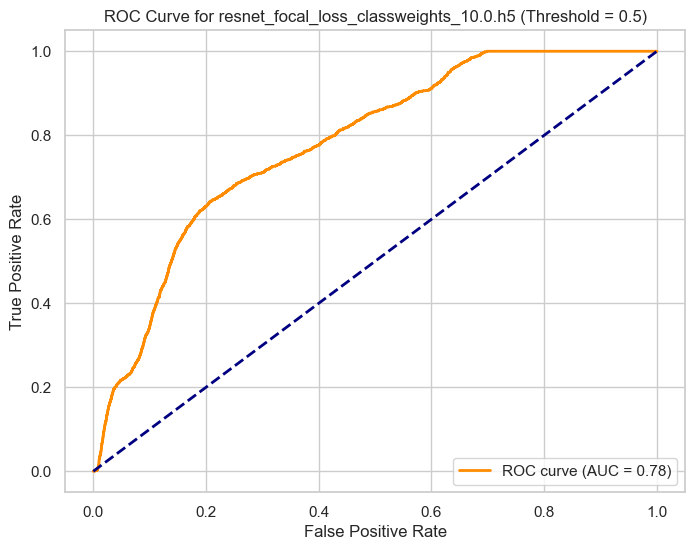

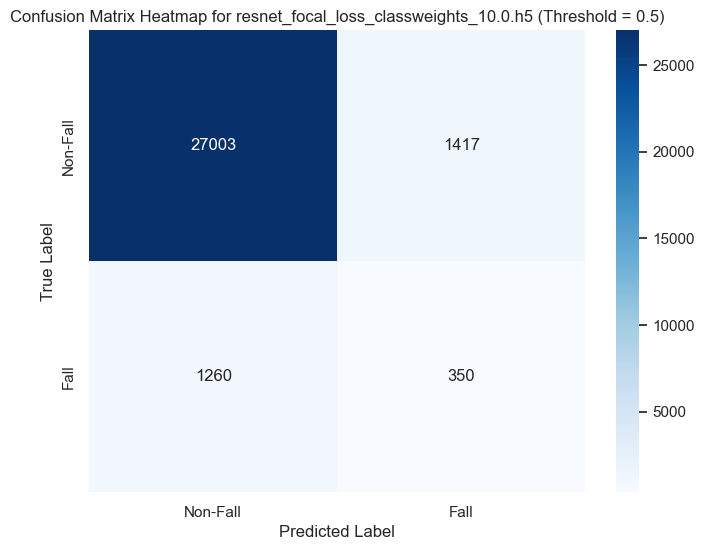


Testing Model: resnet_binary_crossentropy_classweights_7.0.h5
939/939 [==============================] - 2s 2ms/step

Threshold: 0.4
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     28420
         1.0       0.12      0.68      0.20      1610

    accuracy                           0.71     30030
   macro avg       0.55      0.70      0.51     30030
weighted avg       0.93      0.71      0.79     30030

Confusion Matrix (Test Set):
[[20295  8125]
 [  509  1101]]


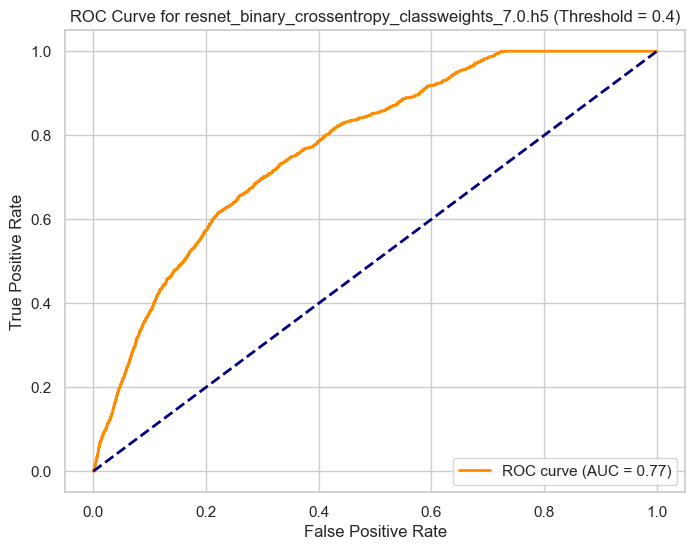

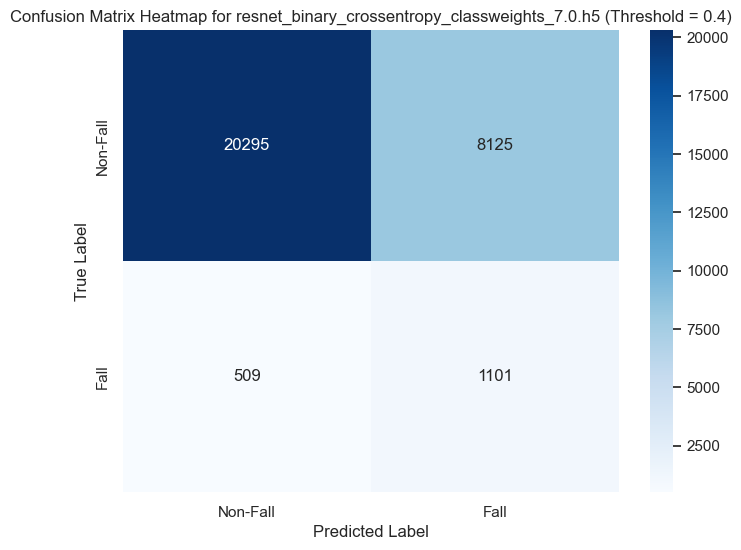


Threshold: 0.5
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     28420
         1.0       0.12      0.66      0.21      1610

    accuracy                           0.73     30030
   macro avg       0.55      0.70      0.52     30030
weighted avg       0.93      0.73      0.80     30030

Confusion Matrix (Test Set):
[[20703  7717]
 [  540  1070]]


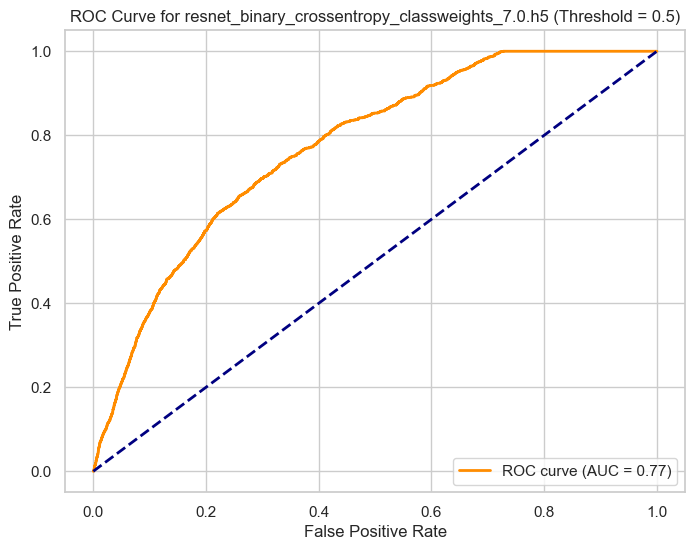

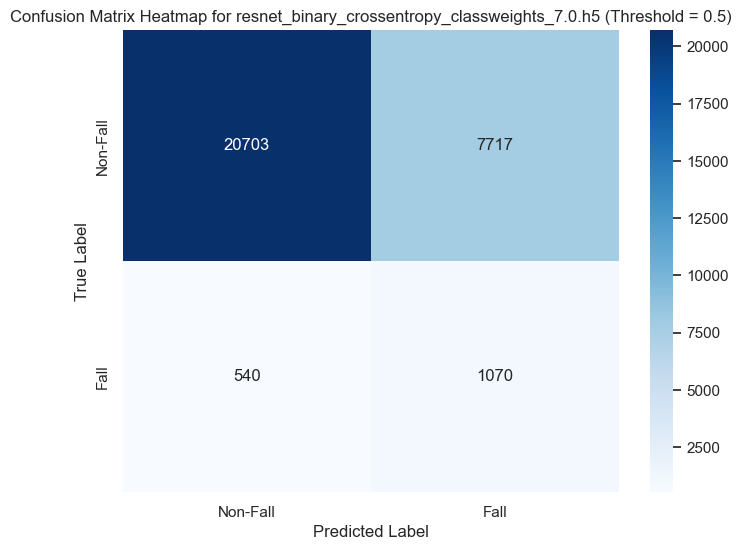

In [104]:
# Path to the directory containing saved models
saved_models_dir = './saved_models/'

# Thresholds for evaluation
thresholds = [0.4, 0.5]

# Iterate over all saved models in the directory
for model_file in os.listdir(saved_models_dir):
    if model_file.endswith(".h5"):  # Check if it's a model file
        print(f"\nTesting Model: {model_file}")
        model_path = os.path.join(saved_models_dir, model_file)

        # Load the model
        model = load_model(model_path, custom_objects={"focal_loss_fixed": focal_loss()})

        # Predict probabilities on the test data
        y_pred_probs = model.predict(X_test_scaled)

        for threshold in thresholds:
            print(f"\nThreshold: {threshold}")
            # Convert probabilities to binary predictions
            y_pred = (y_pred_probs > threshold).astype(int)

            # Evaluate the predictions
            print("Classification Report (Test Set):")
            print(classification_report(y_test, y_pred))
            print("Confusion Matrix (Test Set):")
            print(confusion_matrix(y_test, y_pred))

            # -------------------------------------
            # ROC Curve (Receiver Operating Characteristic)
            # -------------------------------------
            fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_file} (Threshold = {threshold})')
            plt.legend(loc='lower right')
            plt.show()

            # -------------------------------------
            # Confusion Matrix Heatmap
            # -------------------------------------
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
            plt.title(f'Confusion Matrix Heatmap for {model_file} (Threshold = {threshold})')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()


## Custom ResNet with Class Weights and sampling majority & minority class

939/939 [==============================] - 3s 3ms/step - loss: 0.7535 - accuracy: 0.6975 - recall_22: 0.5752
Test Loss: 0.7535316348075867, Test Accuracy: 0.6975358128547668, Test Recall: 0.5751552581787109
939/939 [==============================] - 3s 3ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82     28420
         1.0       0.10      0.58      0.17      1610

    accuracy                           0.70     30030
   macro avg       0.53      0.64      0.49     30030
weighted avg       0.92      0.70      0.78     30030

Confusion Matrix:
[[20021  8399]
 [  684   926]]


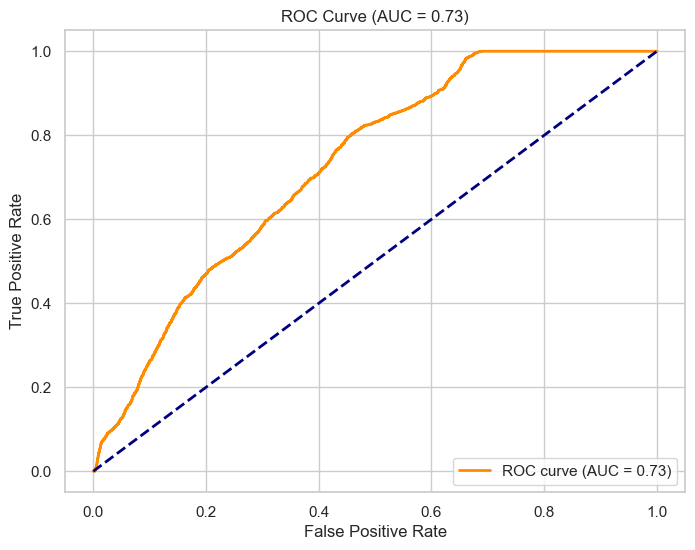

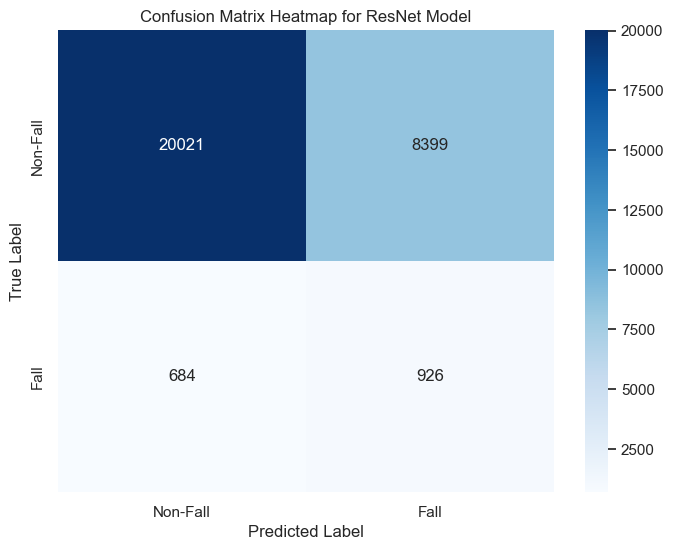

In [105]:
# Reshape the test data for 1D CNN input (samples, features, channels)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)  # Add an extra dimension for CNN input (samples, features, channels)

# Load the best ResNet model (if you have it saved)
model = tf.keras.models.load_model("./saved_models/best_resnet_model_7to1_resampled_recall.h5")

# Evaluate the model on the test data
test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Recall: {test_recall}")

# Generate predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for ResNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## ResNet with Hyperparameters (Dropout, Dense Units, Filters)

939/939 [==============================] - 3s 3ms/step - loss: 0.7386 - recall_24: 0.6708
Test Loss: 0.7385553121566772, Test Recall: 0.6708074808120728
939/939 [==============================] - 3s 3ms/step
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     28420
         1.0       0.12      0.67      0.20      1610

    accuracy                           0.71     30030
   macro avg       0.55      0.69      0.51     30030
weighted avg       0.93      0.71      0.79     30030

Confusion Matrix (Test Set):
[[20204  8216]
 [  530  1080]]


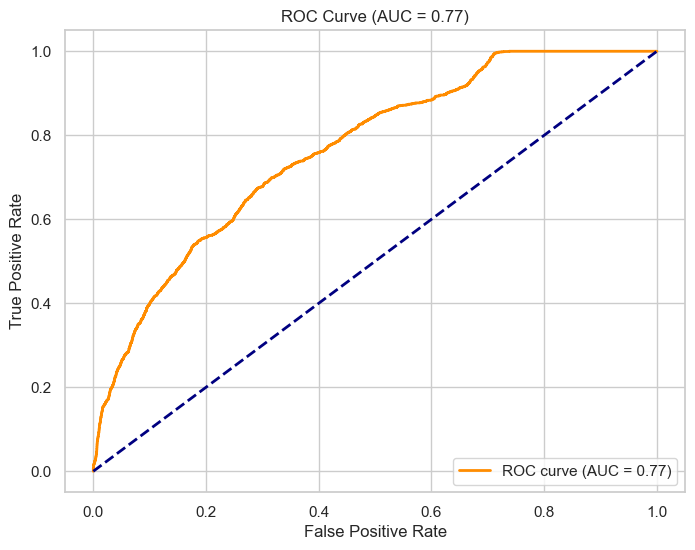

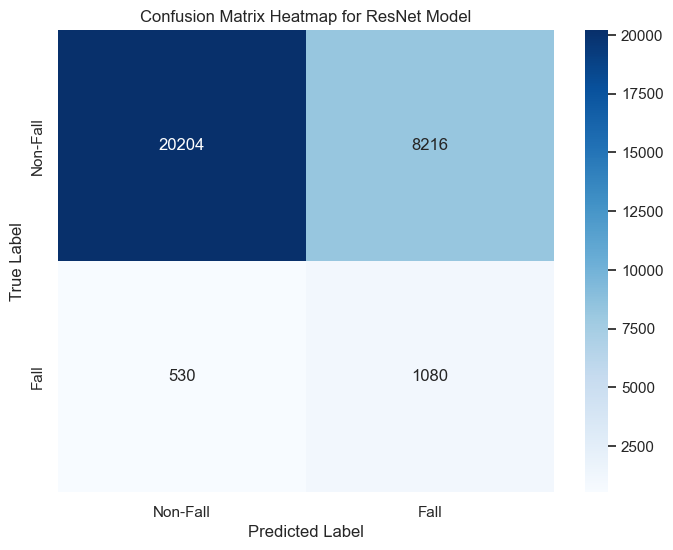

In [106]:
# Load the trained model
model = tf.keras.models.load_model("./saved_models/best_resnet_model_hyperparams_resampled_recall.h5")

# Evaluate the model on the test set
test_loss, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test Recall: {test_recall}")

# Generate predictions on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification

# Generate and print the classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for ResNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Training on custom 1D resnet with binary crossentropy for Threshold = 0.5

939/939 [==============================] - 3s 3ms/step
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     28420
         1.0       0.12      0.66      0.21      1610

    accuracy                           0.73     30030
   macro avg       0.55      0.70      0.52     30030
weighted avg       0.93      0.73      0.80     30030

Confusion Matrix (Test Set):
[[20703  7717]
 [  540  1070]]


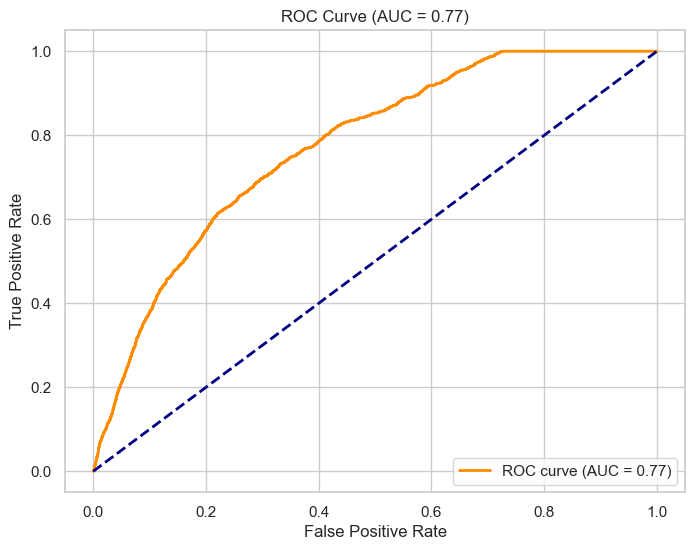

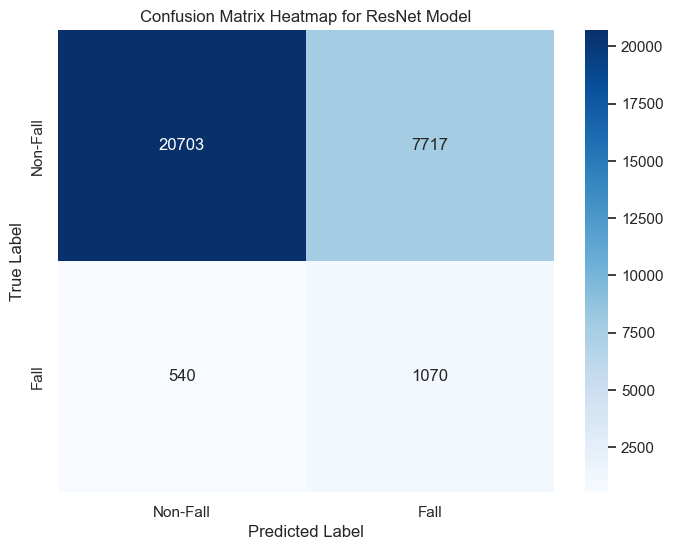

In [107]:
# Step 1: Ensure the test data is scaled and reshaped like the training data:
X_test_scaled = scaler.transform(X_test[['x', 'y', 'z']])  # Apply the same scaler used for X_train
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)  # Reshape for 1D CNN (samples, features, channels)

# Step 2: Load the best-trained model (use the model with the desired class weight configuration)
model_filename = "resnet_binary_crossentropy_classweights_7.0.h5"  # Example file name
model_path = os.path.join(save_dir, model_filename)

# Load the model
model = tf.keras.models.load_model(model_path)

# Step 3: Make predictions on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)  # Using threshold 0.5 for classification

# Step 4: Evaluate the model
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for ResNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Decision Tree

Decision Tree Test Performance:
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73     28420
         1.0       0.11      0.89      0.19      1610

    accuracy                           0.59     30030
   macro avg       0.55      0.73      0.46     30030
weighted avg       0.94      0.59      0.70     30030

Confusion Matrix (Test Set):
[[16421 11999]
 [  185  1425]]
Recall (Test Set): 0.8850931677018633


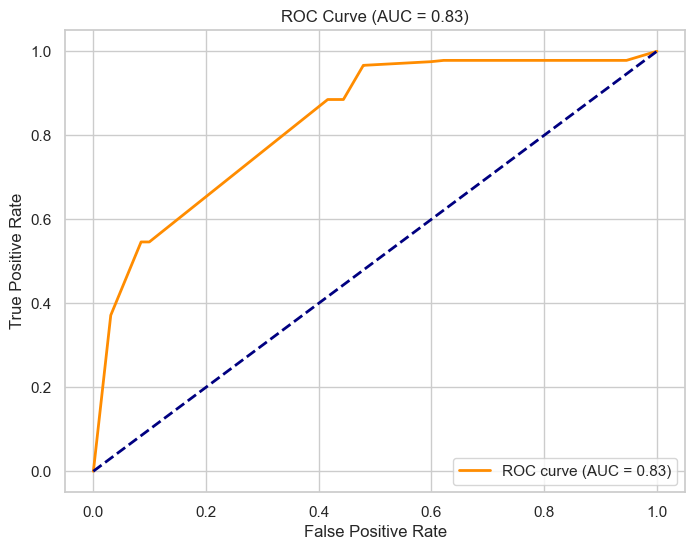

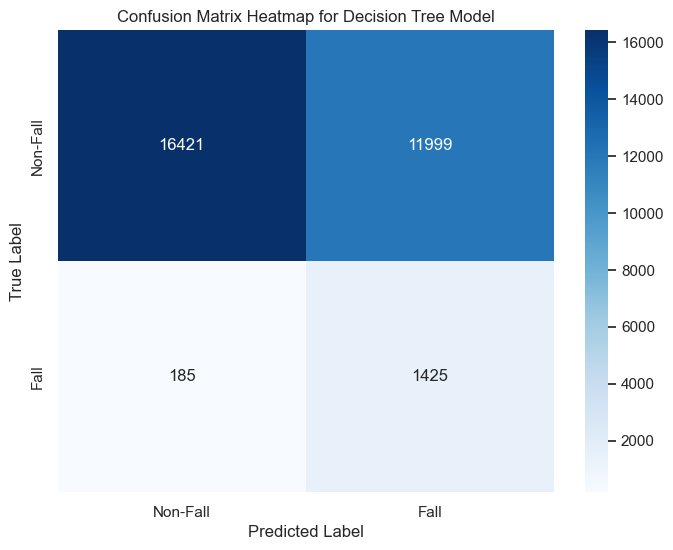

In [108]:
# Ensure the test data is preprocessed similarly to the training data
X_test_scaled = scaler.transform(X_test[['x', 'y', 'z']])  # Use the same scaler fitted on the training data
y_test = test_data['anomaly']  # Assuming 'anomaly' is the label column in the test set

# Predict on the test set using the trained Decision Tree model
y_pred_dt_test = decision_tree.predict(X_test_scaled)

# Evaluate the model on the test data
print("Decision Tree Test Performance:")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_dt_test))
print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_dt_test)
print(cm)
print("Recall (Test Set):", recall_score(y_test, y_pred_dt_test))

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, decision_tree.predict_proba(X_test_scaled)[:, 1])  # Use probabilities for ROC curve
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Randon Forest

Confusion Matrix (Test Set):
[[28042   378]
 [ 1522    88]]

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     28420
         1.0       0.19      0.05      0.08      1610

    accuracy                           0.94     30030
   macro avg       0.57      0.52      0.53     30030
weighted avg       0.91      0.94      0.92     30030



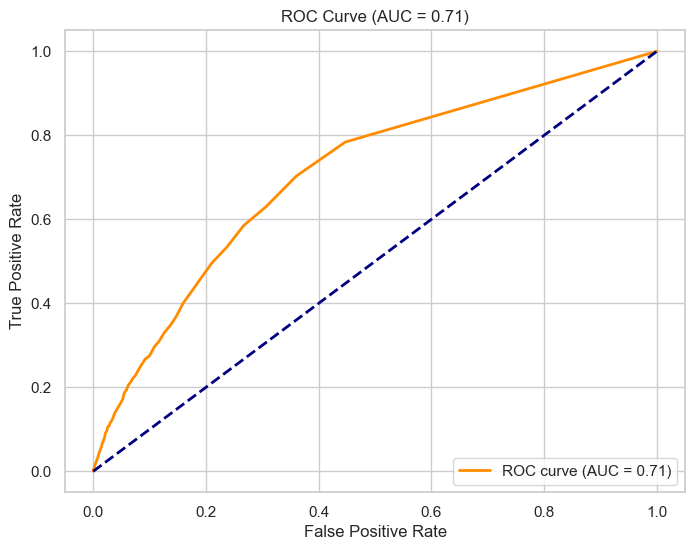

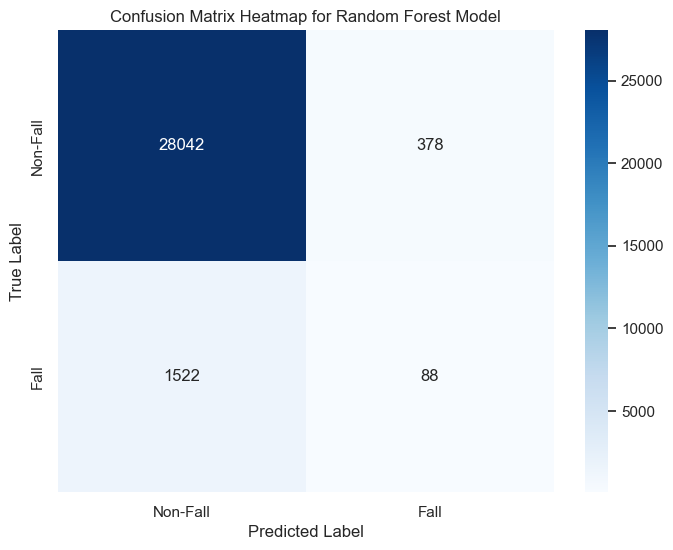

In [109]:
# Ensure the test data is preprocessed similarly to the training data
X_test_selected = test_data[['x', 'y', 'z']]  # Using selected features ('x', 'y', 'z')
y_test = test_data['anomaly']

# Predict on the test set using the trained Random Forest model
y_pred_selected_test = model_selected.predict(X_test_selected)

# Evaluate the model on the test data
print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_selected_test)
print(cm)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_selected_test))

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, model_selected.predict_proba(X_test_selected)[:, 1])  # Use probabilities for ROC curve
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Custom resnet with balanced weights

939/939 [==============================] - 3s 3ms/step - loss: 0.8098 - recall_35: 0.6646
Test Loss: 0.8097535967826843, Test Accuracy: 0.6645962595939636
939/939 [==============================] - 2s 3ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     28420
         1.0       0.12      0.66      0.21      1610

    accuracy                           0.73     30030
   macro avg       0.55      0.70      0.52     30030
weighted avg       0.93      0.73      0.80     30030


Confusion Matrix (Test Set):
[[20703  7717]
 [  540  1070]]


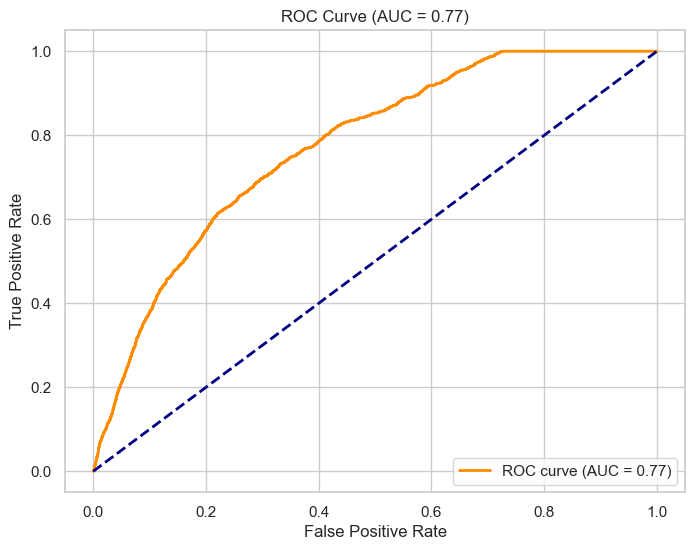

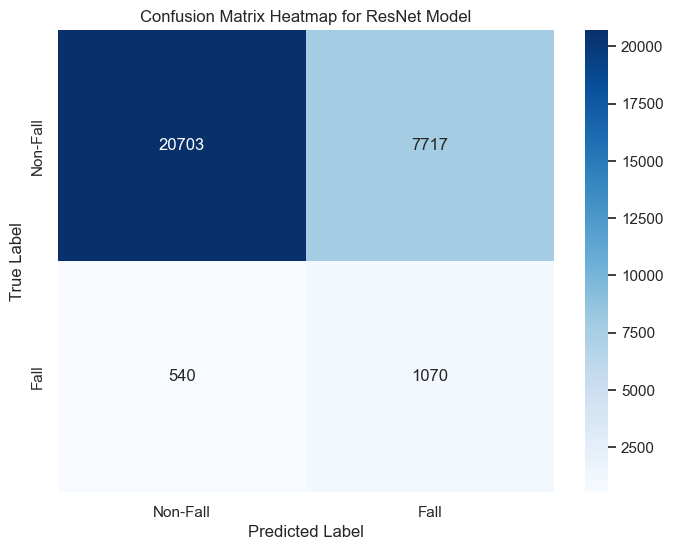

In [110]:
# Assuming the test data is available as test_data
X_test = test_data[['x', 'y', 'z']]  # Select the features used in training
y_test = test_data['anomaly']

# Step 1: Apply the same scaling to the test data as was done for training data
scaler = StandardScaler()

# Fit the scaler on the training data and transform the test data
X_test_scaled = scaler.fit_transform(X_test)

# Step 2: Reshape the test data for 1D CNN input format (samples, features, channels)
X_test_scaled = X_test_scaled.reshape((-1, X_test_scaled.shape[1], 1))

# Step 3: Evaluate the trained model on the test set
# Assuming `model` is your trained ResNet model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Step 4: Generate predictions on the test set
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels using threshold 0.5

# Step 5: Print classification report and confusion matrix
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# -------------------------------------
# ROC Curve (Receiver Operating Characteristic)
# -------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 0])  # Use predicted probabilities for ROC curve
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()

# -------------------------------------
# Confusion Matrix Heatmap
# -------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title(f'Confusion Matrix Heatmap for ResNet Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Analysis of Model Test Results: Fall Detection Performance

In this section, we summarize the test results of various machine learning models for fall detection, highlighting key performance metrics such as **Recall**, **Precision**, **F1-Score**, **Confusion Matrix**, and overall **Accuracy**. We also include a **Comparison Table** for easy visualization.

### Key Observations:
1. **XGBoost Classifier**:
   - The XGBoost model performs well in terms of overall accuracy (**85%**) but struggles with recall for class 1 (falls), achieving a **Recall of 0.42**. This suggests that while the model correctly identifies non-fall instances, it misses many of the fall instances.
   
2. **ResNet (Binary Crossentropy & Focal Loss)**:
   - The performance of ResNet models shows improvement with class weight adjustments. For threshold **0.5**, the model achieves accuracy close to **90%**, but recall remains low for class 1 (**0.17 to 0.44**). The **Threshold of 0.4** offers better recall but sacrifices precision, highlighting the trade-off in classifying falls.
   - The model with **class weights of 3.0** performs better with **Recall = 0.59** at threshold **0.4**.

3. **Decision Tree**:
   - The Decision Tree model shows a high **Recall (0.89)** for class 1 (falls) but a low **Precision (0.11)**. It over-predicts falls (many false positives), leading to a **high recall** but **low precision**, which makes it a **poor choice for precision-sensitive applications**.

4. **Random Forest**:
   - The Random Forest model exhibits high **Precision (0.95)** and **Recall (0.99)** for class 0 (non-falls) but struggles significantly with class 1, achieving a **Recall of only 0.05**. Its ability to predict class 0 correctly is high, but it fails at identifying fall instances.

5. **Custom ResNet with Balanced Weights**:
   - The performance of the custom ResNet model with balanced weights is similar to other models. The recall for class 1 is still low (**0.66**) but better than other models with **balanced class weights**.

6. **Training on custom 1D resnet with binary crossentropy for Threshold = 0.5**:
   - The performance of custom 1D resnet with binary crossentropy accuracy of 73% with recall: 66% but lacked precision for fall class and poor F1 score.
   

### Comparison Table:

| Model                                         | Accuracy | Precision (Class 0) | Recall (Class 0) | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | Confusion Matrix | Class Weights |
|-----------------------------------------------|----------|---------------------|------------------|---------------------|------------------|--------------------|------------------|---------------|
| **XGBoost Classifier**                        | 0.85     | 0.96                | 0.87             | 0.16                | 0.42             | 0.23               | [[24851, 3569], [928, 682]] | None          |
| **ResNet (Binary Crossentropy, Threshold 0.4)**| 0.86     | 0.96                | 0.89             | 0.13                | 0.30             | 0.19               | [[25349, 3071], [1132, 478]] | 7.0           |
| **ResNet (Binary Crossentropy, Threshold 0.5)**| 0.91     | 0.95                | 0.95             | 0.17                | 0.17             | 0.17               | [[27126, 1294], [1337, 273]] | 7.0           |
| **ResNet (Binary Crossentropy, Threshold 0.4)**| 0.67     | 0.98                | 0.67             | 0.11                | 0.72             | 0.19               | [[18905, 9515], [446, 1164]] | 10.0          |
| **ResNet (Binary Crossentropy, Threshold 0.5)**| 0.68     | 0.98                | 0.68             | 0.11                | 0.70             | 0.19               | [[19427, 8993], [484, 1126]] | 10.0          |
| **ResNet (Binary Crossentropy, Threshold 0.4)**| 0.70     | 0.97                | 0.70             | 0.11                | 0.64             | 0.19               | [[20021, 8399], [584, 1026]] | 5.0           |
| **ResNet (Binary Crossentropy, Threshold 0.5)**| 0.72     | 0.97                | 0.73             | 0.11                | 0.61             | 0.19               | [[20617, 7803], [622, 988]] | 5.0           |
| **ResNet (Binary Crossentropy, Threshold 0.4)**| 0.75     | 0.97                | 0.76             | 0.12                | 0.59             | 0.20               | [[21639, 6781], [655, 955]] | 3.0           |
| **ResNet (Binary Crossentropy, Threshold 0.5)**| 0.77     | 0.97                | 0.79             | 0.13                | 0.54             | 0.21               | [[22381, 6039], [734, 876]] | 3.0           |
| **ResNet (Focal Loss, Threshold 0.4)**        | 0.90     | 0.97                | 0.93             | 0.24                | 0.41             | 0.30               | [[26294, 2126], [942, 668]] | 3.0           |
| **ResNet (Focal Loss, Threshold 0.5)**        | 0.93     | 0.96                | 0.96             | 0.28                | 0.25             | 0.26               | [[27388, 1032], [1210, 400]] | 3.0           |
| **ResNet (Focal Loss, Threshold 0.4)**        | 0.86     | 0.96                | 0.89             | 0.17                | 0.39             | 0.23               | [[25244, 3176], [976, 634]] | 5.0           |
| **ResNet (Focal Loss, Threshold 0.5)**        | 0.91     | 0.95                | 0.95             | 0.18                | 0.19             | 0.18               | [[26965, 1455], [1298, 312]] | 5.0           |
| **ResNet (Focal Loss, Threshold 0.4)**        | 0.85     | 0.97                | 0.88             | 0.17                | 0.44             | 0.24               | [[24906, 3514], [899, 711]] | 10.0          |
| **ResNet (Focal Loss, Threshold 0.5)**        | 0.91     | 0.96                | 0.95             | 0.20                | 0.22             | 0.21               | [[27003, 1417], [1260, 350]] | 10.0          |
| **Decision Tree**                              | 0.59     | 0.99                | 0.58             | 0.11                | 0.89             | 0.19               | [[16421, 11999], [185, 1425]] | None          |
| **Random Forest**                              | 0.94     | 0.95                | 0.99             | 0.19                | 0.05             | 0.08               | [[28042, 378], [1522, 88]]   | Balanced      |
| **Custom ResNet with Balanced Weights**       | 0.73     | 0.97                | 0.73             | 0.12                | 0.66             | 0.21               | [[20703, 7717], [540, 1070]] | Balanced      |
| **ResNet with Hyperparameters (Dropout)**    | 0.71     | 0.97                | 0.71             | 0.12                | 0.67             | 0.20               | [[20204, 8216], [530, 1080]] | Hyperparams   |
| **Training on custom 1D resnet with binary crossentropy for Threshold = 0.5**          | 0.73     | 0.97                | 0.73             | 0.12                | 0.66             | 0.21               | [[20703, 7717], [540, 1070]] | None    |

---

## Key Takeaway:
#### While no model achieves perfect recall and precision for falls, ResNet models with tailored class weights and thresholds show the most promise for improving fall detection. Future implementation could potentially give us better results on unseen data.

---

### **Future Research Directions for Fall Detection:**

1. **Model Refinement and Evaluation**:
   - Further exploration of **class imbalance handling**, using some new techniques to improve recall without sacrificing precision

   - Experiment with **ensemble methods** like **stacking** or **boosting** (XGBoost) alongside deep learning models (e.g., **ResNet**) to potentially combine strengths of both.
   
   - Look into all models we have trained and analyse key performance factors, improve models by hyperparameter tuning, weights adjustments, window slicing etc. to get better results.


2. **Feature Engineering**:
   - Investigating additional **sensor features**, such as **angle of fall**, **velocity**, or even **time-series windows** for more robust fall detection.
   
   - Including **user demographics**, such as age or mobility history, to potentially increase the accuracy of predictions.


3. **Real-Time Fall Detection**:
   - Real-time fall detection is crucial for medical applications. Implementing models with faster **inference time** and **lower memory consumption** would enable better use in wearable devices or mobile phones.
   
   - Use of **edge devices** to process the data locally and minimize latency in fall detection.


4. **Model Interpretability**:
   - Research into **model explainability** is essential for high-risk applications like healthcare. Tools like **LIME** or **SHAP** could help understand the rationale behind fall predictions.
   
   - Implementing **confidence thresholds** where predictions can be flagged for human review in critical cases.


5. **Data Privacy and Security**:
   - As falls typically occur in private settings (e.g., homes, hospitals), ensuring that **data privacy** and **secure handling** of sensor data are top priorities for any deployment of fall detection systems.


6. **Multimodal Fall Detection**:
   - **Multimodal sensor fusion**, using data from accelerometers, gyroscopes, cameras, and pressure sensors, to create a **more comprehensive fall detection system** that can work in different environments (e.g., indoors vs outdoors, different types of falls).

